## In this notebook we georeference GEDI and ICESat-2 data


## Import packages

In [1]:
import warnings
warnings.filterwarnings("ignore") # suppress warnings

In [2]:
import os
import sys
import h5py
import pyproj
import datetime 
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx  # For adding a basemap
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.interpolate import griddata
from shapely.geometry import Point, box
from geoviews import opts, tile_sources as gvts
from sliderule import sliderule, icesat2, earthdata

In [3]:
function_path = os.path.expanduser("~/geoscience/carbon_estimation/code/functions")
sys.path.append(function_path)

# Explicitly set the GDAL_DATA environment variable to point to the correct data directory
# os.environ['GDAL_DATA'] = '/bsuhome/tnde/miniconda3/envs/veg_height/share/gdal'
# os.environ['GDAL_DATA'] = '/bsuhome/tnde/miniconda3/envs/lpdaac_tutorials/share/gdal'

# Check the default PROJ data directory
print(pyproj.datadir.get_data_dir())
# # If needed, explicitly set the PROJ data directory before running the script. This might not be necessary for everyone
# pyproj.datadir.set_data_dir("/bsuhome/tnde/miniconda3/envs/lpdaac_tutorials/share/proj") # This manually set the PROJ data directory if the correct grid transformation does not appear.
# pyproj.datadir.set_data_dir("/bsuhome/tnde/miniconda3/envs/veg_height/share/proj") # This manually set the PROJ data directory if the correct grid transformation does not appear.

/bsuscratch/tnde/miniforge3/envs/sail_env/share/proj


## Loading GEDI Data

In [4]:
from helper_functions import load_gedi_data
gedi_dir_l1b = "/bsuhome/tnde/scratch/carbon_estimation/data/gedi_data/gedi_finder/gedi01_B_002/output/"
gedi_dir_l2a = "/bsuhome/tnde/scratch/carbon_estimation/data/gedi_data/gedi_finder/gedi02_A_002/output/"
gedi_dir_l2b = "/bsuhome/tnde/scratch/carbon_estimation/data/gedi_data/gedi_finder/gedi02_B_002/output/"

# Load GEDI data with acquisition date
merged_gedi_gdf_l1b = load_gedi_data(gedi_dir_l1b, 'GEDI01_B')
merged_gedi_gdf_l2a = load_gedi_data(gedi_dir_l2a, 'GEDI02_A')
merged_gedi_gdf_l2b = load_gedi_data(gedi_dir_l2b, 'GEDI02_B')

print("L1B length:", len(merged_gedi_gdf_l1b))
print("L2A length:", len(merged_gedi_gdf_l2a))
print("L2B length:", len(merged_gedi_gdf_l2b))

L1B length: 23303
L2A length: 23265
L2B length: 23303


In [5]:
merged_gedi_gdf_l1b.crs

<Projected CRS: EPSG:6340>
Name: NAD83(2011) / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United States (USA) - between 120°W and 114°W onshore and offshore - California, Idaho, Nevada, Oregon, Washington.
- bounds: (-120.0, 30.88, -114.0, 49.01)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [6]:
# Check if the data has a Z column in its geometry; if False, then we will use the ground elevation as the Z axis/column.
has_z = merged_gedi_gdf_l1b.geometry.has_z.any()
print("Does the GeoDataFrame have a Z column in its geometry?", has_z)

Does the GeoDataFrame have a Z column in its geometry? False


In [7]:
display(merged_gedi_gdf_l1b[["elevation", "elevation_NAVD88_gedi_from_crs"]].head())
diff = merged_gedi_gdf_l1b["elevation_NAVD88_gedi_from_crs"] - merged_gedi_gdf_l1b["elevation"]
display("Difference:", diff)
display("Description of the difference:", diff.describe())

elevation  elevation_NAVD88_gedi_from_crs
0  1879.3390                     1896.689532
1  1874.0612                     1891.411996
2  1857.5990                     1874.950036
3  1869.7548                     1887.106053
4  1869.7548                     1887.106261

'Difference:'

0        17.350532
1        17.350796
2        17.351036
3        17.351253
4        17.351461
           ...    
78766    17.444483
78767    17.445840
78768    17.447168
78769    17.449812
78770    17.449738
Length: 23303, dtype: float64

'Description of the difference:'

count    23303.000000
mean        17.230157
std          0.178787
min         16.836043
25%         17.086572
50%         17.268431
75%         17.382781
max         17.491932
dtype: float64

In [8]:
# merged_gedi_gdf_l1b2 = merged_gedi_gdf_l1b.to_crs("epsg:6340")
# merged_gedi_gdf_l1b2[["geometry", "elevation"]].head()

In [9]:
# merged_gedi_gdf_l1b3 = merged_gedi_gdf_l1b.to_crs("epsg:26911")
# merged_gedi_gdf_l1b3[["geometry", "elevation"]].head()

In [10]:
# merged_gedi_gdf_l1b4 = merged_gedi_gdf_l1b.to_crs("epsg:5703")
# merged_gedi_gdf_l1b4[["geometry", "elevation"]].head()

## Merging GEDI Data Sets
### Method 1: `merge` method

Here, we merge the three data sets; L1B, L2A, and L2B, using their short numbers.

We can use `merge()` since `shot_number` values perfectly match across data sets.

In [11]:
# Search for common columns in the three data sets. These columns will give us the basis/critterion for merging the data sets.
common_cols = set(merged_gedi_gdf_l1b.columns)&set(merged_gedi_gdf_l2a.columns)&set(merged_gedi_gdf_l2b.columns)
common_cols = list(common_cols) # Convert back to list
common_cols

['Northing',
 'BEAM',
 'elevation_NAVD88_gedi_from_pipe',
 'acquisition_date',
 'date',
 'Longitude',
 'elevation',
 'Easting',
 'geometry',
 'elevation_NAVD88_gedi_from_crs',
 'index',
 'Latitude']

In [12]:
print(len(merged_gedi_gdf_l1b["shot_number_x"].unique()), 
     len(merged_gedi_gdf_l2a["shot_number"].unique()),
     len(merged_gedi_gdf_l2b["shot_number"].unique()))

23303 23265 23303


In [13]:
from helper_functions import merge_gedi_data
data_list = [merged_gedi_gdf_l1b, merged_gedi_gdf_l2a, merged_gedi_gdf_l2b]
col_list = ["shot_number_x", "shot_number", "shot_number"]
surfix_list = ["_l1b", "_l2a", "_l2b"]
method1 = "merge"

final_merged_gdf = merge_gedi_data(data_list, col_list, surfix_list, method1)
print(f"Final merged dataset size: {len(final_merged_gdf)}")
# Display the first few rows
display(final_merged_gdf.head()) 
display(final_merged_gdf[["Latitude_l1b", "Latitude_l2a", "Latitude", "Longitude_l1b", "Longitude_l2a", "Longitude"]])

Final merged dataset size: 23262


BEAM_l2a        shot_number  Latitude_l2a  Longitude_l2a  index_l2a  \
0  BEAM1011  34511100200281473     43.309238    -116.831206     113648   
1  BEAM1011  34511100200281474     43.309520    -116.830618     113649   
2  BEAM1011  34511100200281475     43.309801    -116.830030     113650   
3  BEAM1011  34511100200281476     43.310082    -116.829441     113651   
4  BEAM1011  34511100200281477     43.310364    -116.828854     113652   

   degrade_flag    delta_time  digital_elevation_model  \
0             0  4.908651e+07                1798.0383   
1             0  4.908651e+07                1798.0383   
2             0  4.908651e+07                1797.0074   
3             0  4.908651e+07                1795.8794   
4             0  4.908651e+07                1795.8794   

   digital_elevation_model_srtm  elev_lowestmode  ...  stale_return_flag_l2b  \
0                     1799.5100        1799.3198  ...                      0   
1                     1799.5100        1801.7000  ...                      0   
2                     1798.5099        1798.3579  ...                      0   
3                     1797.5099        1796.2415  ...                      0   
4                     1797.5098        1796.0858  ...                      0   

   surface_flag_l2b                        geometry  acquisition_date  \
0                 1  POINT (513688.965 4795169.966)     2019204022957   
1                 1   POINT (513736.57 4795201.316)     2019204022957   
2                 1  POINT (513784.205 4795232.651)     2019204022957   
3                 1  POINT (513831.832 4795263.988)     2019204022957   
4                 1  POINT (513879.447 4795295.327)     2019204022957   

                 date        Easting      Northing  elevation  \
0 2019-07-23 02:29:57  513688.964915  4.795170e+06  1798.0383   
1 2019-07-23 02:29:57  513736.570004  4.795201e+06  1798.0383   
2 2019-07-23 02:29:57  513784.205063  4.795233e+06  1797.0074   
3 2019-07-23 02:29:57  513831.832065  4.795264e+06  1795.8794   
4 2019-07-23 02:29:57  513879.447137  4.795295e+06  1795.8794   

   elevation_NAVD88_gedi_from_pipe  elevation_NAVD88_gedi_from_crs  
0                      1814.884409                     1815.427281  
1                      1814.885509                     1815.428389  
2                      1813.855711                     1814.398598  
3                      1812.728813                     1813.271707  
4                      1812.729917                     1813.272818  

[5 rows x 283 columns]

Latitude_l1b  Latitude_l2a   Latitude  Longitude_l1b  Longitude_l2a  \
0         43.309240     43.309238  43.309238    -116.831209    -116.831206   
1         43.309521     43.309520  43.309520    -116.830621    -116.830618   
2         43.309802     43.309801  43.309801    -116.830033    -116.830030   
3         43.310084     43.310082  43.310082    -116.829445    -116.829441   
4         43.310365     43.310364  43.310364    -116.828857    -116.828854   
...             ...           ...        ...            ...            ...   
23260     43.219620     43.219620  43.219620    -116.688407    -116.688407   
23261     43.221042     43.221071  43.221071    -116.690981    -116.691036   
23262     43.220763     43.220791  43.220791    -116.690398    -116.690453   
23263     43.220485     43.220513  43.220513    -116.689817    -116.689872   
23264     43.220205     43.220234  43.220234    -116.689232    -116.689288   

        Longitude  
0     -116.831206  
1     -116.830618  
2     -116.830030  
3     -116.829441  
4     -116.828854  
...           ...  
23260 -116.688407  
23261 -116.691036  
23262 -116.690453  
23263 -116.689872  
23264 -116.689288  

[23262 rows x 6 columns]

In [14]:
# Count missing values per column
missing_values = final_merged_gdf.isna().sum()
print(missing_values[missing_values > 0])  # Display only columns with missing values

# Count rows where L2A or L2B data is missing
missing_l1b = final_merged_gdf["shot_number_x"].isna().sum()  # From L1B
missing_l2a = final_merged_gdf["shot_number"].isna().sum()  # From L2A
missing_l2b = final_merged_gdf["geolocation_shot_number_l2b"].isna().sum()  # From L2B

print(f"Missing L1B records: {missing_l1b}")
print(f"Missing L2A records: {missing_l2a}")
print(f"Missing L2B records: {missing_l2b}")

# Show rows where data is missing
pd.set_option("display.max_columns", None)
missing_data = final_merged_gdf[final_merged_gdf.isna().any(axis=1)]
display(missing_data.head())

Series([], dtype: int64)
Missing L1B records: 0
Missing L2A records: 0
Missing L2B records: 0


Empty GeoDataFrame
Columns: [BEAM_l2a, shot_number, Latitude_l2a, Longitude_l2a, index_l2a, degrade_flag, delta_time, digital_elevation_model, digital_elevation_model_srtm, elev_lowestmode, elevation_bias_flag, num_detectedmodes, quality_flag, rh_0, rh_1, rh_2, rh_3, rh_4, rh_5, rh_6, rh_7, rh_8, rh_9, rh_10, rh_11, rh_12, rh_13, rh_14, rh_15, rh_16, rh_17, rh_18, rh_19, rh_20, rh_21, rh_22, rh_23, rh_24, rh_25, rh_26, rh_27, rh_28, rh_29, rh_30, rh_31, rh_32, rh_33, rh_34, rh_35, rh_36, rh_37, rh_38, rh_39, rh_40, rh_41, rh_42, rh_43, rh_44, rh_45, rh_46, rh_47, rh_48, rh_49, rh_50, rh_51, rh_52, rh_53, rh_54, rh_55, rh_56, rh_57, rh_58, rh_59, rh_60, rh_61, rh_62, rh_63, rh_64, rh_65, rh_66, rh_67, rh_68, rh_69, rh_70, rh_71, rh_72, rh_73, rh_74, rh_75, rh_76, rh_77, rh_78, rh_79, rh_80, rh_81, rh_82, rh_83, rh_84, rh_85, rh_86, ...]
Index: []

In [15]:
# Check if some of the short numbers in the merged data set are different
check = final_merged_gdf[final_merged_gdf["shot_number_x"] != final_merged_gdf["shot_number"]][["shot_number_x", "shot_number", "geolocation_shot_number_l2b"]]
check

Empty DataFrame
Columns: [shot_number_x, shot_number, geolocation_shot_number_l2b]
Index: []

rh_100: length = 23262, min = 0.0
rh_90: length = 23262, min = 0.0
rh_80: length = 23262, min = 0.0


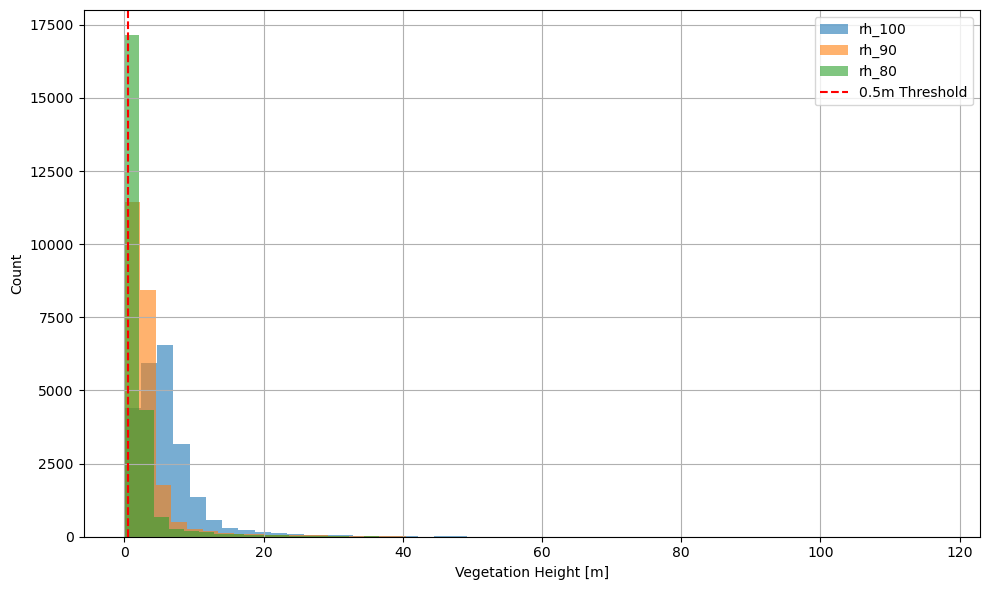

In [16]:
# List of RH metrics to plot
rh_metrics = ["rh_100", "rh_90", "rh_80"]

plt.figure(figsize=(10, 6))

# Plot each RH metric
for rh in rh_metrics:
    print(f"{rh}: length = {len(final_merged_gdf[rh])}, min = {np.min(final_merged_gdf[rh])}")
    plt.hist(final_merged_gdf[rh], bins=50, alpha=0.6, label=f"{rh}")#, edgecolor="black")

# vertical threshold line
plt.axvline(x=0.5, color="r", linestyle='--', label="0.5m Threshold")

plt.xlabel("Vegetation Height [m]")
plt.ylabel("Count")
# plt.title("Distribution of GEDI Vegetation Heights (RH Metrics)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
final_merged_gdf

BEAM_l2a         shot_number  Latitude_l2a  Longitude_l2a  index_l2a  \
0      BEAM1011   34511100200281473     43.309238    -116.831206     113648   
1      BEAM1011   34511100200281474     43.309520    -116.830618     113649   
2      BEAM1011   34511100200281475     43.309801    -116.830030     113650   
3      BEAM1011   34511100200281476     43.310082    -116.829441     113651   
4      BEAM1011   34511100200281477     43.310364    -116.828854     113652   
...         ...                 ...           ...            ...        ...   
23260  BEAM1011  162661100300129252     43.219620    -116.688407      47565   
23261  BEAM1011  162661100300129255     43.221071    -116.691036      47568   
23262  BEAM1011  162661100300129256     43.220791    -116.690453      47569   
23263  BEAM1011  162661100300129257     43.220513    -116.689872      47570   
23264  BEAM1011  162661100300129258     43.220234    -116.689288      47571   

       degrade_flag    delta_time  digital_elevation_model  \
0                 0  4.908651e+07                1798.0383   
1                 0  4.908651e+07                1798.0383   
2                 0  4.908651e+07                1797.0074   
3                 0  4.908651e+07                1795.8794   
4                 0  4.908651e+07                1795.8794   
...             ...           ...                      ...   
23260            30  1.205054e+08                1490.9960   
23261            30  1.205054e+08                1502.7910   
23262            30  1.205054e+08                1498.8707   
23263            30  1.205054e+08                1498.8707   
23264            30  1.205054e+08                1489.3998   

       digital_elevation_model_srtm  elev_lowestmode  elevation_bias_flag  \
0                         1799.5100        1799.3198                    0   
1                         1799.5100        1801.7000                    0   
2                         1798.5099        1798.3579                    0   
3                         1797.5099        1796.2415                    0   
4                         1797.5098        1796.0858                    0   
...                             ...              ...                  ...   
23260                     1487.7383        5209.6748                    0   
23261                     1503.7350        1504.6700                    0   
23262                     1502.7356        1501.4163                    0   
23263                     1497.7363        1496.0585                    0   
23264                     1491.7371        1493.7004                    0   

       num_detectedmodes  quality_flag  rh_0  rh_1  rh_2  rh_3  rh_4  rh_5  \
0                      1             1 -5.13 -4.27 -3.74 -3.40 -3.10 -2.92   
1                      1             1 -4.87 -4.08 -3.63 -3.29 -3.07 -2.84   
2                      1             1 -5.02 -4.19 -3.74 -3.44 -3.22 -3.03   
3                      1             1 -4.57 -3.74 -3.33 -3.03 -2.80 -2.62   
4                      1             1 -4.64 -3.82 -3.33 -3.03 -2.77 -2.58   
...                  ...           ...   ...   ...   ...   ...   ...   ...   
23260                  0             0  0.00  0.00  0.00  0.00  0.00  0.00   
23261                  1             0 -1.82 -1.78 -1.71 -1.67 -1.60 -1.56   
23262                  1             0 -2.15 -2.12 -2.04 -1.97 -1.93 -1.86   
23263                  1             0 -1.97 -1.93 -1.86 -1.78 -1.71 -1.67   
23264                  1             0 -2.00 -1.97 -1.89 -1.86 -1.78 -1.71   

       rh_6  rh_7  rh_8  rh_9  rh_10  rh_11  rh_12  rh_13  rh_14  rh_15  \
0     -2.73 -2.58 -2.43 -2.32  -2.21  -2.13  -2.02  -1.94  -1.87  -1.79   
1     -2.69 -2.54 -2.39 -2.28  -2.17  -2.06  -1.98  -1.91  -1.83  -1.76   
2     -2.84 -2.69 -2.58 -2.47  -2.36  -2.24  -2.17  -2.06  -1.98  -1.91   
3     -2.47 -2.32 -2.21 -2.09  -2.02  -1.91  -1.83  -1.76  -1.68  -1.61   
4     -2.43 -2.32 -2.17 -2.09  -1.98  -1.91  -1.83  -1.76  -1.68  -1.61   
.

### ML Data

In [18]:
print(len(final_merged_gdf[final_merged_gdf["stale_return_flag"] != 0]["stale_return_flag"]))
print(len(final_merged_gdf[final_merged_gdf["degrade_flag"] != 0]["degrade_flag"]))

final_merged_gdf = final_merged_gdf[final_merged_gdf["stale_return_flag"] == 0]
final_merged_gdf = final_merged_gdf[final_merged_gdf["degrade_flag"] == 0]

print(len(final_merged_gdf[final_merged_gdf["stale_return_flag"] != 0]["stale_return_flag"]))
print(len(final_merged_gdf[final_merged_gdf["degrade_flag"] != 0]["degrade_flag"]))
print(len(final_merged_gdf))
23262 - 3858 - 8024

3858
8024
0
0
13408


11380

In [19]:
print(len(merged_gedi_gdf_l1b[merged_gedi_gdf_l1b["stale_return_flag"] != 0]))
print(len(merged_gedi_gdf_l1b[merged_gedi_gdf_l1b["geolocation_degrade"] != 0]))
23303 - (3863 + 8041)

3863
8041


11399

In [20]:
print(len(merged_gedi_gdf_l2b[merged_gedi_gdf_l2b["stale_return_flag"] != 0]))
print(len(merged_gedi_gdf_l2b[merged_gedi_gdf_l2b["geolocation_degrade_flag"] != 0]))
23303 - (3863 + 8039)

3863
8039


11401

In [21]:
# for col in merged_gedi_gdf_l2b.columns:
#     print(col)

In [22]:
cols = ["date", "shot_number", "BEAM_l2a", "Latitude_l2a", "Longitude_l2a", 
        "quality_flag", "num_detectedmodes", "rh_80", "rh_85", "rh_90", "rh_95", "rh_98", 
        "rh_99", "rh_100", "sensitivity", "solar_elevation", "geometry_l2a", 
        "Easting_l2a", "Northing_l2a", "elevation_NAVD88_gedi_from_crs_l2a", 
        "GEDI02_A_slope_ratio_utm", "GEDI02_A_slope_degrees_utm", "GEDI02_A_slope_rise_run", 
        "rx_sample_count", "cover_z_10", "cover_z_15", "cover_z_20", "cover_z_25", 
        "cover_z_27", "cover_z_28", "cover_z_29", "fhd_normal", "pai_z_10", "pai_z_15", 
        "pai_z_20", "pai_z_25", "pai_z_27", "pai_z_28", "pai_z_29", "pavd_z_10", 
        "pavd_z_15", "pavd_z_20", "pavd_z_25", "pavd_z_27", "pavd_z_28", "pavd_z_29", "rh100"]#, "degrade_flag", "stale_return_flag"]



# cols = ["date", "shot_number", "BEAM_l2a", "Latitude_l2a", "Longitude_l2a", 
#         "quality_flag", "num_detectedmodes", "rh_30", "rh_40", "rh_50", "rh_60", "rh_70", "rh_71", "rh_72", "rh_73", "rh_74", 
#         "rh_75", "rh_76", "rh_77", "rh_78", "rh_79", "rh_80", "rh_81", "rh_82", "rh_83", "rh_84", 
#         "rh_85", "rh_86", "rh_87", "rh_88", "rh_89", "rh_90", "rh_91", "rh_92", "rh_93", 
#         "rh_94", "rh_95", "rh_96", "rh_97", "rh_98", 
#         "rh_99", "rh_100", "sensitivity", "solar_elevation", "geometry_l2a", 
#         "Easting_l2a", "Northing_l2a", "elevation_NAVD88_gedi_from_crs_l2a", 
#         "GEDI02_A_slope_ratio_utm", "GEDI02_A_slope_degrees_utm", "GEDI02_A_slope_rise_run", 
#         "rx_sample_count", "cover_z_10", "cover_z_15", "cover_z_20", "cover_z_25", 
#         "cover_z_27", "cover_z_28", "cover_z_29", "fhd_normal", "pai_z_10", "pai_z_15", 
#         "pai_z_20", "pai_z_25", "pai_z_27", "pai_z_28", "pai_z_29", "pavd_z_10", 
#         "pavd_z_15", "pavd_z_20", "pavd_z_25", "pavd_z_27", "pavd_z_28", "pavd_z_29", "rh100", 
#         "degrade_flag", "stale_return_flag"]

# drop = ["elevation_NAVD88_gedi_from_pipe_l2a", "elevation_l2a", "degrade_flag", "quality_flag", "rhog", "rhov"]

In [23]:
# for col in final_merged_gdf.columns:
#     print(col)
ml_data = final_merged_gdf[cols]
ml_data.head()

# final_merged_gdf["veg_height"] = final_merged_gdf["elev_highestreturn"] - final_merged_gdf["elev_lowestmode"]
# final_merged_gdf[["elev_highestreturn", "elev_lowestmode", "rh_100", "veg_height"]]

date        shot_number  BEAM_l2a  Latitude_l2a  \
0 2019-07-23 02:29:57  34511100200281473  BEAM1011     43.309238   
1 2019-07-23 02:29:57  34511100200281474  BEAM1011     43.309520   
2 2019-07-23 02:29:57  34511100200281475  BEAM1011     43.309801   
3 2019-07-23 02:29:57  34511100200281476  BEAM1011     43.310082   
4 2019-07-23 02:29:57  34511100200281477  BEAM1011     43.310364   

   Longitude_l2a  quality_flag  num_detectedmodes  rh_80  rh_85  rh_90  rh_95  \
0    -116.831206             1                  1   1.08   1.34   1.68   2.21   
1    -116.830618             1                  1   0.97   1.19   1.49   1.94   
2    -116.830030             1                  1   1.12   1.42   1.79   2.43   
3    -116.829441             1                  1   0.93   1.16   1.46   1.91   
4    -116.828854             1                  1   0.89   1.12   1.42   1.83   

   rh_98  rh_99  rh_100  sensitivity  solar_elevation  \
0   2.73   3.10    4.04     0.976120         1.137563   
1   2.43   2.73    3.63     0.975038         1.137287   
2   3.14   3.67    4.90     0.976903         1.137010   
3   2.39   2.69    3.59     0.971373         1.136734   
4   2.28   2.58    3.37     0.973743         1.136458   

                     geometry_l2a    Easting_l2a  Northing_l2a  \
0  POINT (513688.965 4795169.966)  513688.964915  4.795170e+06   
1   POINT (513736.57 4795201.316)  513736.570004  4.795201e+06   
2  POINT (513784.205 4795232.651)  513784.205063  4.795233e+06   
3  POINT (513831.832 4795263.988)  513831.832065  4.795264e+06   
4  POINT (513879.447 4795295.327)  513879.447137  4.795295e+06   

   elevation_NAVD88_gedi_from_crs_l2a  GEDI02_A_slope_ratio_utm  \
0                         1815.427281                  0.017394   
1                         1815.428389                  0.000019   
2                         1814.398598                 -0.018061   
3                         1813.271707                 -0.019766   
4                         1813.272818                  0.000019   

   GEDI02_A_slope_degrees_utm  GEDI02_A_slope_rise_run  rx_sample_count  \
0                    0.996506                 0.001113            755.0   
1                    0.001113                -1.034706            749.0   
2                   -1.034706                -1.132363            766.0   
3                   -1.132363                 0.001117            745.0   
4                    0.001117                -2.100310            745.0   

   cover_z_10  cover_z_15  cover_z_20  cover_z_25  cover_z_27  cover_z_28  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   cover_z_29  fhd_normal  pai_z_10  pai_z_15  pai_z_20  pai_z_25  pai_z_27  \
0         0.0    1.417535      -0.0      -0.0      -0.0      -0.0      -0.0   
1         0.0    1.340707      -0.0      -0.0      -0.0      -0.0      -0.0   
2         0.0    1.658798      -0.0      -0.0      -0.0      -0.0      -0.0   
3         0.0    1.269725      -0.0      -0.0      -0.0      -0.0      -0.0   
4         0.0    0.790818      -0.0      -0.0      -0.0      -0.0      -0.0   

   pai_z_28  pai_z_29  pavd_z_10  pavd_z_15  pavd_z_20  pavd_z_25  pavd_z_27  \
0      -0.0      -0.0       -0.0       -0.0       -0.0       -0.0       -0.0   
1      -0.0      -0.0       -0.0       -0.0       -0.0       -0.0       -0.0   
2      -0.0      -0.0       -0.0       -0.0       -0.0       -0.0       -0.0   
3      -0.0      -0.0       -0.0       -0.0       -0.0       -0.0       -0.0   
4      -0.0      -0.0       -0.0       -0.0       -0.0       -0.0       -0.0   

   pavd_z_28  pavd_z_29  rh100  
0       -0.0       -0.0    403  
1       -0.0       -0.0    363  
2       -

In [24]:
# cvs_name = "/bsuhome/tnde/scratch/carbon_estimation/data/gedi_data/gedi_finder/ml_data/gedi_ml2.csv" #set name of the output #set name of the output
# ml_data.to_csv(cvs_name)

# outName = cvs_name.replace(".csv", ".geojson")  # Create an output file name using the input file name
# ml_data.to_file(outName, driver="GeoJSON")  # Export to GeoJSON


#########################
#########################
# cvs_name = "/bsuhome/tnde/scratch/carbon_estimation/data/gedi_data/gedi_finder/ml_data/gedi_ml_detection_threshold.csv" #set name of the output #set name of the output
# ml_data.to_csv(cvs_name)

# outName = cvs_name.replace(".csv", ".geojson")  # Create an output file name using the input file name
# ml_data.to_file(outName, driver="GeoJSON")  # Export to GeoJSON

### Method 2: `sjoin` method. 
Here we use spatial join instead of `merge`. Assuming that `shot_number_x` doesn’t perfectly match `shot_number`, you can spatially join merged_gedi_gdf_l1b with merged_gedi_gdf_l2a and merged_gedi_gdf_l2b based on geometry (lat/lon or northing/easting).

We can use `sjoin_nearest()` if shot numbers do not match but geometries (lat/lon or northing/easting) are close.

**Note:** In our specific case, both methods are equivalent. They work them same way. The results are exactly the same. This is beause the shot numbers do match and the geometries (lat/lon or northing/easting) are close. Hence, both methods work equally the same way.

**Optional:**
We can use the steps below to check the accuracy of our spatial join. 

1. Inspect distance values
    - Print summary statistics of distances.
    - Identify the maximum, mean, and standard deviation of distances.
    - Check for unusually high distances that may indicate incorrect joins.

2. Set a distance threshold if necessary (max allowed distance). In our specific case this isn't really necessary, because the default threshold is already working fine.
    - Define a reasonable max_distance based on the expected spatial accuracy.
    - Re-run sjoin_nearest with this threshold.

3. Visual Inspection (Optional)
    - Plot points before and after joining to see if they align correctly.

In [25]:
# from helper_functions import merge_gedi_data
# data_list = [merged_gedi_gdf_l1b, merged_gedi_gdf_l2a, merged_gedi_gdf_l2b]
# col_list = ["shot_number_x", "shot_number", "shot_number"]
# surfix_list = ["_l1b", "_l2a", "_l2b"]
method2 = "sjoin"
final_spatial_gdf, final_spatial_gdf_filtered = merge_gedi_data(data_list, col_list, surfix_list, method2)
print("Unfiltered data set length", len(final_spatial_gdf))
print("Filtered data set length", len(final_spatial_gdf_filtered))

# Display the merged dataset
pd.set_option("display.max_columns", None)  # number of columns to show in output. `None` means show all columns.
display(final_spatial_gdf.head())
display(final_spatial_gdf[["Latitude__l1b", "Latitude__l2a", "Latitude", "Longitude__l1b", "Longitude__l2a", "Longitude"]].head())
display(final_spatial_gdf[final_spatial_gdf["distance_l1b"] == 0][["distance_l1b", "distance_l2b"]])

# # Save to a CSV or GeoJSON for further inspection
# final_spatial_gdf.to_csv("spatially_merged_gedi.csv", index=False)
# final_spatial_gdf.to_file("spatially_merged_gedi.geojson", driver="GeoJSON")

# Check distance summary statistics
print("Distance to L1B summary:\n", final_spatial_gdf["distance_l1b"].describe())
print("\nDistance to L2B summary:\n", final_spatial_gdf["distance_l2b"].describe())

print(f"\nFiltered dataset size: {len(final_spatial_gdf_filtered)} (after removing large distances)")
# check distance summary statistics again
print("Distance to L1B summary:\n", final_spatial_gdf_filtered["distance_l1b"].describe())
print("\nDistance to L2B summary:\n", final_spatial_gdf_filtered["distance_l2b"].describe())

# # Save filtered dataset to file
# final_spatial_gdf_filtered.to_file("filtered_merged_gedi.geojson", driver="GeoJSON")

Unfiltered data set length 23265
Filtered data set length 23262


BEAM__l2a  shot_number__merged  Latitude__l2a  Longitude__l2a  index__l2a  \
1  BEAM1011    34511100200281473      43.309238     -116.831206      113648   
2  BEAM1011    34511100200281474      43.309520     -116.830618      113649   
3  BEAM1011    34511100200281475      43.309801     -116.830030      113650   
4  BEAM1011    34511100200281476      43.310082     -116.829441      113651   
5  BEAM1011    34511100200281477      43.310364     -116.828854      113652   

   degrade_flag    delta_time  digital_elevation_model  \
1             0  4.908651e+07                1798.0383   
2             0  4.908651e+07                1798.0383   
3             0  4.908651e+07                1797.0074   
4             0  4.908651e+07                1795.8794   
5             0  4.908651e+07                1795.8794   

   digital_elevation_model_srtm  elev_lowestmode  elevation_bias_flag  \
1                     1799.5100        1799.3198                    0   
2                     1799.5100        1801.7000                    0   
3                     1798.5099        1798.3579                    0   
4                     1797.5099        1796.2415                    0   
5                     1797.5098        1796.0858                    0   

   num_detectedmodes  quality_flag  rh_0  rh_1  rh_2  rh_3  rh_4  rh_5  rh_6  \
1                  1             1 -5.13 -4.27 -3.74 -3.40 -3.10 -2.92 -2.73   
2                  1             1 -4.87 -4.08 -3.63 -3.29 -3.07 -2.84 -2.69   
3                  1             1 -5.02 -4.19 -3.74 -3.44 -3.22 -3.03 -2.84   
4                  1             1 -4.57 -3.74 -3.33 -3.03 -2.80 -2.62 -2.47   
5                  1             1 -4.64 -3.82 -3.33 -3.03 -2.77 -2.58 -2.43   

   rh_7  rh_8  rh_9  rh_10  rh_11  rh_12  rh_13  rh_14  rh_15  rh_16  rh_17  \
1 -2.58 -2.43 -2.32  -2.21  -2.13  -2.02  -1.94  -1.87  -1.79  -1.72  -1.64   
2 -2.54 -2.39 -2.28  -2.17  -2.06  -1.98  -1.91  -1.83  -1.76  -1.68  -1.61   
3 -2.69 -2.58 -2.47  -2.36  -2.24  -2.17  -2.06  -1.98  -1.91  -1.83  -1.76   
4 -2.32 -2.21 -2.09  -2.02  -1.91  -1.83  -1.76  -1.68  -1.61  -1.57  -1.49   
5 -2.32 -2.17 -2.09  -1.98  -1.91  -1.83  -1.76  -1.68  -1.61  -1.53  -1.49   

   rh_18  rh_19  rh_20  rh_21  rh_22  rh_23  rh_24  rh_25  rh_26  rh_27  \
1  -1.57  -1.53  -1.46  -1.38  -1.34  -1.27  -1.23  -1.19  -1.12  -1.08   
2  -1.53  -1.49  -1.42  -1.38  -1.31  -1.27  -1.19  -1.16  -1.12  -1.04   
3  -1.68  -1.64  -1.57  -1.49  -1.46  -1.38  -1.34  -1.27  -1.23  -1.16   
4  -1.46  -1.38  -1.34  -1.27  -1.23  -1.19  -1.12  -1.08  -1.04  -1.01   
5  -1.42  -1.38  -1.31  -1.27  -1.23  -1.16  -1.12  -1.08  -1.04  -1.01   

   rh_28  rh_29  rh_30  rh_31  rh_32  rh_33  rh_34  rh_35  rh_36  rh_37  \
1  -1.04  -1.01  -0.93  -0.89  -0.86  -0.82  -0.78  -0.71  -0.67  -0.63   
2  -1.01  -0.97  -0.93  -0.89  -0.86  -0.82  -0.74  -0.71  -0.67  -0.63   
3  -1.12  -1.08  -1.01  -0.97  -0.93  -0.89  -0.82  -0.78  -0.74  -0.71   
4  -0.97  -0.93  -0.86  -0.82  -0.78  -0.74  -0.71  -0.67  -0.63  -0.59   
5  -0.93  -0.89  -0.86  -0.82  -0.78  -0.74  -0.71  -0.67  -0.63  -0.59   

   rh_38  rh_39  rh_40  rh_41  rh_42  rh_43  rh_44  rh_45  rh_46  rh_47  \
1  -0.59  -0.56  -0.52  -0.48  -0.44  -0.41  -0.37  -0.33  -0.29  -0.26   
2  -0.59  -0.56  -0.52  -0.48  -0.44  -0.41  -0.37  -0.33  -0.29  -0.26   
3  -0.67  -0.63  -0.56  -0.52  -0.48  -0.44  -0.41  -0.37  -0.33  -0.29   
4  -0.56  -0.52  -0.48  -0.44  -0.44  -0.41  -0.37  -0.33  -0.29  -0.26   
5  -0.56  -0.52  -0.48  -0.44  -0.44  -0.41  -0.37  -0.33  -0.29  -0.26   

   rh_48  rh_49  rh_50  rh_51  rh_52  rh_53  rh_54  rh_55  rh_56  rh_57  \
1  -0.22  -0.18  -0.14  -0.11  -0.07  -0.03   0.00   0.03   0.07   0.11   
2  -0.26  -0.22  -0.18  -0.14  -0.11  -0.07  -0.03   0.00   0.03   0.07   
3  -0.26  -0.22  -0.18  -0.14  -0.11  -0.03   0.00   0.03   0.07   0.11   
4  -0.22  -0.18  -0.14  -0.11  -0.11  -0.07  -0.03   0.00   0.03   0.07   
5  -0.22  -0.18  -0.14  -0.14  -0.11  -0.07  -0.03   0.

Latitude__l1b  Latitude__l2a   Latitude  Longitude__l1b  Longitude__l2a  \
1      43.309240      43.309238  43.309238     -116.831209     -116.831206   
2      43.309521      43.309520  43.309520     -116.830621     -116.830618   
3      43.309802      43.309801  43.309801     -116.830033     -116.830030   
4      43.310084      43.310082  43.310082     -116.829445     -116.829441   
5      43.310365      43.310364  43.310364     -116.828857     -116.828854   

    Longitude  
1 -116.831206  
2 -116.830618  
3 -116.830030  
4 -116.829441  
5 -116.828854

distance_l1b  distance_l2b
3537            0.0           0.0
3538            0.0           0.0
3539            0.0           0.0
3540            0.0           0.0
3541            0.0           0.0
...             ...           ...
78761           0.0           0.0
78762           0.0           0.0
78763           0.0           0.0
78764           0.0           0.0
78765           0.0           0.0

[4322 rows x 2 columns]

Distance to L1B summary:
 count    23265.000000
mean         2.050664
std          1.790810
min          0.000000
25%          0.481408
50%          1.845791
75%          3.420751
max         32.887878
Name: distance_l1b, dtype: float64

Distance to L2B summary:
 count    23265.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: distance_l2b, dtype: float64

Filtered dataset size: 23262 (after removing large distances)
Distance to L1B summary:
 count    23262.000000
mean         2.047162
std          1.763181
min          0.000000
25%          0.481364
50%          1.845157
75%          3.420477
max         15.281020
Name: distance_l1b, dtype: float64

Distance to L2B summary:
 count    23262.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: distance_l2b, dtype: float64


In [26]:
# Count missing values per column
missing_values = final_spatial_gdf.isna().sum()
print(missing_values[missing_values > 0])  # Display only columns with missing values

# Count rows where L2A or L2B data is missing
missing_l1b = final_spatial_gdf["shot_number_x"].isna().sum()  # From L1B
missing_l2a = final_spatial_gdf["shot_number__merged"].isna().sum()  # From L2A
missing_l2b = final_spatial_gdf["shot_number__l2b"].isna().sum()  # From L2B

print(f"Missing L1B records: {missing_l1b}")
print(f"Missing L2A records: {missing_l2a}")
print(f"Missing L2B records: {missing_l2b}")

# Show rows where data is missing
missing_data = final_spatial_gdf[final_spatial_gdf.isna().any(axis=1)]
display(missing_data.head())

Series([], dtype: int64)
Missing L1B records: 0
Missing L2A records: 0
Missing L2B records: 0


Empty GeoDataFrame
Columns: [BEAM__l2a, shot_number__merged, Latitude__l2a, Longitude__l2a, index__l2a, degrade_flag, delta_time, digital_elevation_model, digital_elevation_model_srtm, elev_lowestmode, elevation_bias_flag, num_detectedmodes, quality_flag, rh_0, rh_1, rh_2, rh_3, rh_4, rh_5, rh_6, rh_7, rh_8, rh_9, rh_10, rh_11, rh_12, rh_13, rh_14, rh_15, rh_16, rh_17, rh_18, rh_19, rh_20, rh_21, rh_22, rh_23, rh_24, rh_25, rh_26, rh_27, rh_28, rh_29, rh_30, rh_31, rh_32, rh_33, rh_34, rh_35, rh_36, rh_37, rh_38, rh_39, rh_40, rh_41, rh_42, rh_43, rh_44, rh_45, rh_46, rh_47, rh_48, rh_49, rh_50, rh_51, rh_52, rh_53, rh_54, rh_55, rh_56, rh_57, rh_58, rh_59, rh_60, rh_61, rh_62, rh_63, rh_64, rh_65, rh_66, rh_67, rh_68, rh_69, rh_70, rh_71, rh_72, rh_73, rh_74, rh_75, rh_76, rh_77, rh_78, rh_79, rh_80, rh_81, rh_82, rh_83, rh_84, rh_85, rh_86, ...]
Index: []

In [27]:
# for col in final_spatial_gdf.columns:
#     print(col)

final_spatial_gdf[final_spatial_gdf["distance_l1b"]>20][["shot_number__merged", "shot_number_x", "shot_number__l2b", "distance_l1b"]]

shot_number__merged       shot_number_x    shot_number__l2b  \
38040    49620800200177079  208731100300241689   49620800200177079   
44501   211900500200097357  155460800200102675  211900500200097357   
69067    87940600300537536  205221100300128793   87940600300537536   

       distance_l1b  
38040     21.842448  
44501     32.887878  
69067     32.885474

### Plot the Merged Data

In [28]:
# Projected CRS
projected_crs = "epsg:6340"  # Horizontal transformation: The EPSG code for NAD83/UTM zone 11N is 26911 (1983) or 6340 (2011).
# Specify region of interest shapefile
shp = "/bsuhome/tnde/geoscience/carbon_estimation/RCEW_shapefile_josh/RCEW_Boundary.shp"
shapefile = gpd.read_file(shp)
shapefile.crs is None
shapefile = shapefile.to_crs(projected_crs)
# shapefile.to_file('/bsuhome/tnde/geoscience/geoscience/carbon_estimation/RCEW_shapefile_josh/RCEW_Boundary.geojson', driver='GeoJSON')

# Specify region of interest from geojson
poly_fn = '/bsuhome/tnde/geoscience/carbon_estimation/RCEW_shapefile_josh/RCEW_Boundary.geojson'
pregion = gpd.read_file(poly_fn)
pregion = pregion.to_crs(projected_crs)
region = sliderule.toregion(poly_fn)["poly"] # symplify 

# Prepare coordinate lists for plotting the region of interest polygon
region_lon = [e["lon"] for e in region]
region_lat = [e["lat"] for e in region]


In [29]:
print(ctx.providers.keys())

dict_keys(['OpenStreetMap', 'MapTilesAPI', 'OpenSeaMap', 'OPNVKarte', 'OpenTopoMap', 'OpenRailwayMap', 'OpenFireMap', 'SafeCast', 'Stadia', 'Thunderforest', 'BaseMapDE', 'CyclOSM', 'Jawg', 'MapBox', 'MapTiler', 'TomTom', 'Esri', 'OpenWeatherMap', 'HERE', 'HEREv3', 'FreeMapSK', 'MtbMap', 'CartoDB', 'HikeBike', 'BasemapAT', 'nlmaps', 'NASAGIBS', 'NLS', 'JusticeMap', 'GeoportailFrance', 'OneMapSG', 'USGS', 'WaymarkedTrails', 'OpenAIP', 'OpenSnowMap', 'AzureMaps', 'SwissFederalGeoportal', 'TopPlusOpen', 'Gaode', 'Strava', 'OrdnanceSurvey', 'UN'])


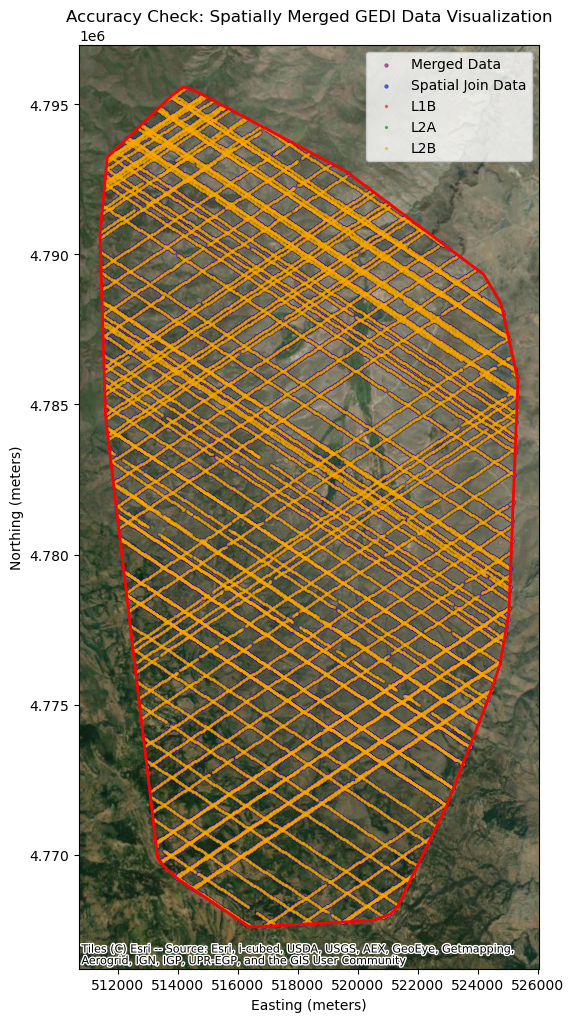

In [30]:
# Plot the merged dataset
fig, ax = plt.subplots(figsize=(10, 12))

# Plot different datasets with different colors
final_merged_gdf.plot(ax=ax, color="purple", markersize=5, alpha=0.5, label="Merged Data")
final_spatial_gdf.plot(ax=ax, color="blue", markersize=5, alpha=0.5, label="Spatial Join Data")
merged_gedi_gdf_l1b.to_crs(projected_crs).plot(ax=ax, color="red", markersize=2, alpha=0.5, label="L1B")
merged_gedi_gdf_l2a.to_crs(projected_crs).plot(ax=ax, color="green", markersize=2, alpha=0.5, label="L2A")
merged_gedi_gdf_l2b.to_crs(projected_crs).plot(ax=ax, color="orange", markersize=2, alpha=0.5, label="L2B")
ax.plot(region_lon, region_lat, linewidth=2, color='r')

# Add a basemap (Optional)
ctx.add_basemap(ax, crs=final_spatial_gdf.crs, source=ctx.providers.Esri.WorldImagery)
# ctx.add_basemap(ax, crs=final_spatial_gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)
# ctx.add_basemap(ax, crs=final_spatial_gdf.crs, source=ctx.providers.CartoDB.Positron)

# Formatting the map
plt.legend()
plt.title("Accuracy Check: Spatially Merged GEDI Data Visualization")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.show()

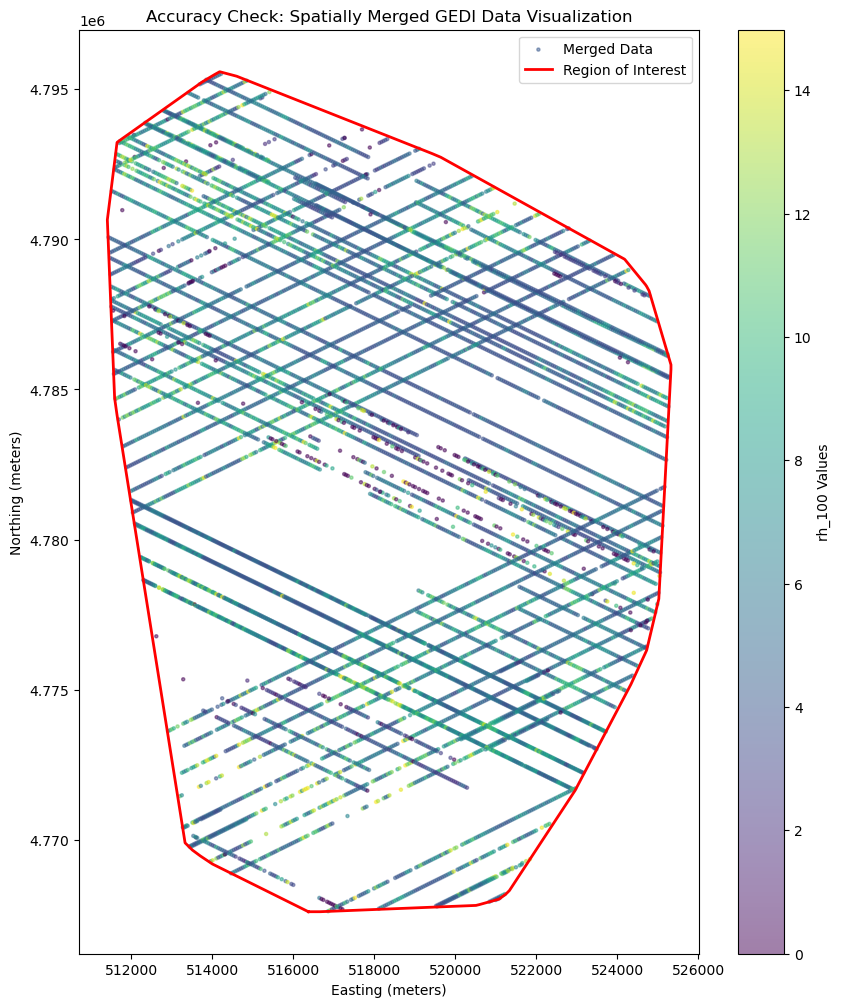

In [31]:
# import geopandas as gpd
# import matplotlib.pyplot as plt
# import contextily as ctx
# import numpy as np

# Plot the merged dataset
fig, ax = plt.subplots(figsize=(10, 12))
final_merged_gdf22 = final_merged_gdf[final_merged_gdf["rh_100"] <= 15]
# Create a scatter plot where color is based on 'rh_100' values
scatter = ax.scatter(final_merged_gdf22.geometry.x, final_merged_gdf22.geometry.y,
                     c=final_merged_gdf22["rh_100"], cmap='viridis', s=5, alpha=0.5, label="Merged Data")

# Plot the region boundary
ax.plot(region_lon, region_lat, linewidth=2, color='r', label="Region of Interest")

# Add a color bar to the plot
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('rh_100 Values')

# Add a basemap (Optional)
# ctx.add_basemap(ax, crs=final_merged_gdf.crs, source=ctx.providers.Esri.WorldImagery)

# Formatting the map
plt.legend()
plt.title("Accuracy Check: Spatially Merged GEDI Data Visualization")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.show()


In [32]:
# L2A: num_detectedmodes, quality_flag, rh_90, rh_95
# L2B: cover, fhd_normal, l2a_quality_flag, l2b_quality_flag, pai, pai_z_29, pavd_z_0, pavd_z_29, rhog, rhov

In [33]:
# for col in final_merged_gdf.columns:
#     print(col)

## GEDI Slopes 
This code is incomplete, but the idea is use the detected modes to comoute vegeatation height.

In [34]:
display(final_merged_gdf[["GEDI02_A_slope_ratio_utm", "GEDI02_A_slope_degrees_utm", "GEDI02_A_slope_rise_run"]].describe())
final_spatial_gdf[["GEDI02_A_slope_ratio_utm", "GEDI02_A_slope_degrees_utm", "GEDI02_A_slope_rise_run"]].describe()

GEDI02_A_slope_ratio_utm  GEDI02_A_slope_degrees_utm  \
count              13408.000000                13408.000000   
mean                  -0.014527                   -0.768897   
std                    0.219831                   11.768084   
min                   -1.376192                  -53.996242   
25%                   -0.115584                   -6.593217   
50%                    0.000007                    0.000409   
75%                    0.087271                    4.987641   
max                    1.311372                   52.672299   

       GEDI02_A_slope_rise_run  
count             13408.000000  
mean                 -0.791666  
std                  11.793693  
min                 -53.996242  
25%                  -6.639881  
50%                   0.000403  
75%                   4.961182  
max                  52.672299

GEDI02_A_slope_ratio_utm  GEDI02_A_slope_degrees_utm  \
count              23265.000000                23265.000000   
mean                  -0.018502                   -0.992401   
std                    0.225152                   12.055229   
min                   -1.376192                  -53.996242   
25%                   -0.128341                   -7.313409   
50%                    0.000006                    0.000350   
75%                    0.088066                    5.032820   
max                    1.602004                   58.026842   

       GEDI02_A_slope_rise_run  
count             23265.000000  
mean                 -1.000148  
std                  12.060512  
min                 -53.996242  
25%                  -7.332390  
50%                   0.000346  
75%                   5.034112  
max                  58.026842

In [35]:
# for col in final_merged_gdf.columns:
#     print(col)
# display(final_merged_gdf[["geometry", "elevation"]].head())
# final_merged_gdf[["Easting_l2a", "Northing_l2a", "elevation_NAVD88_gedi_from_crs_l2a", "rh_100", "elevation_l2a", "elevation_NAVD88_gedi_from_pipe_l2a"]]#.to_csv("gedi_xyz_transform_l2a.csv", index=False)
# display(final_merged_gdf[["Easting_l2a", "Northing_l2a", "elevation_NAVD88_gedi_from_crs_l2a", "rh_100", "elevation_l2a", "elevation_NAVD88_gedi_from_pipe_l2a"]])

In [36]:
# final_merged_gdf[final_merged_gdf["rh_100"] < 1.5]["rh_100"].describe()

## Loading ICESat-2 Data

**The ATL03 geojson file is about 14 million rows. This takes excessively to long to load. So I am loading it as a csv file.**

In [4]:
from helper_functions import load_icesat2_data
# Projected CRS
projected_crs = "epsg:6340"  # Horizontal transformation: The EPSG code for NAD83/UTM zone 11N is 26911 (1983) or 6340 (2011).
icesat2_dir = "/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/"
atl03 = icesat2_dir+f'{"rcew_icesat2_atl03_all_new_final2.geojson"}' 
atl08 = icesat2_dir+f'{"rcew_icesat2_atl08_all_new_final.geojson"}'
atl03

'/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/rcew_icesat2_atl03_all_new_final2.geojson'

In [ ]:
%%time
# icesat2_gdf_atl03, _, icesat2_gdf_atl03_veg_ground = load_icesat2_data(atl03, "ATL03", process = True)
icesat2_gdf_atl03 = load_icesat2_data(atl03, "ATL03", process = True)
print(icesat2_gdf_atl03.crs, "\n")
icesat2_gdf_atl03.crs

In [ ]:
# filename1 = "/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/icesat2_gdf_atl03_veg_ground.geojson" #set name of the output
# filename2 = "/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/icesat2_gdf_atl03_photons.geojson" #set name of the output
# icesat2_gdf_atl03_veg_ground.to_file(filename1, driver="GeoJSON")  # Export to GeoJSON
# _.to_file(filename2, driver="GeoJSON")  # Export to GeoJSON

In [ ]:
icesat2_gdf_atl03.head()

In [ ]:
# icesat2_gdf_atl03["quality_ph"].unique()#.columns
icesat2_gdf_atl03.columns

In [ ]:
from helper_functions import reduce_dataframe
# from sliderule import icesat2
# print(icesat2_gdf_atl03['rgt'].unique())
beam_type = 'strong'
project_crs = "EPSG:6430+EPSG:5703"
D3 = reduce_dataframe(icesat2_gdf_atl03, RGT=59, track=2, beam=beam_type, crs=project_srs)
# D3 = reduce_dataframe(icesat2_gdf_atl03, RGT=59, track=2, beam=beam_type) # RGT=501, 463, 905, 943, 1347, 59
D3.head()

In [ ]:
import shapely
import warnings
import geoviews as gv
import holoviews as hv
gv.extension('bokeh', 'matplotlib')
from geoviews import opts, tile_sources as gvts
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

# the photon’s ATL08 classification (0: noise, 1: ground, 2: canopy, 3: top of canopy, 4: unclassified)
colors={0:['black', 'noise'], 
        4:['gray','unclassified'],  
        2:['green','canopy'], 
        3:['lime', 'canopy_top'], 
        1:['brown', 'ground']
        }
d0=np.min(D3['segment_dist'])

plt.figure(figsize=[14,5])

vis_list = []
for class_val, color_name in colors.items():
    ii=D3['atl08_class']==class_val
    vis_name = color_name[1]+'Vis'
    vis_name = hv.Scatter((D3['segment_dist'][ii]+D3['x_atc'][ii]-d0, D3['height'][ii]), label=color_name[1])
    vis_name = vis_name.opts(color=color_name[0], height=500, width=800, fontsize={'xlabel':16, 'ylabel': 16}, size=1.5)
    vis_list.append(vis_name)

# Combine all three scatterplots
# (vis_list[0] * vis_list[1] * vis_list[2] * vis_list[3] * vis_list[4]).opts(show_legend=True, 
#                                                                            legend_position='top_left',fontsize={'title':14, 'xlabel':16, 'ylabel': 16}, 
#                                                                            title=f'ICESat-2 Photon Classification',
#                                                                            tools=['hover'], xlabel=r"$x_{ATC}$ (m)", ylabel='height (m)')
    
# Plot Digital Elevation Model
hv.extension('bokeh')
# Assuming vis_list contains HoloViews elements
composite_plot = (vis_list[0] * vis_list[1] * vis_list[2] * vis_list[3] * vis_list[4]).opts(
    show_legend=True,
    legend_position='top_left', #bottom_right
    fontsize={'title': 14, 'xlabel': 16, 'ylabel': 16},
    title='ICESat-2 Photon Classification',
    tools=['hover'],
    # xlabel=r"$x_{ATC}$ (m)",
    xlabel=r"x_atc (m)", #x_atc: along track distance of the photon in meters (with respect to the center of the segment)
    ylabel='elevation (m)'
)

composite_plot

In [ ]:
# icesat2_gdf_atl03["atl08_class"]

### Subset ATL03
Here, subset the atl03 product to eliminate photons classified as either `noise` or `unclassified`.

In [ ]:
icesat2_gdf_atl03_veg_ground["vegetation_height"].describe()

In [ ]:
print(len(icesat2_gdf_atl03), len(_), len(icesat2_gdf_atl03_veg_ground))

## The ATL08 Product

In [ ]:
# # Load the ICESat2 GeoJSON file
# icesat2_gdf_atl08 = gpd.read_file(atl08)
# icesat2_gdf_atl08 = icesat2_gdf_atl08.to_crs(merged_gedi_gdf_l1b.crs) ## Reproject the ICESat2 geometries to the same CRS as the GEDI data

# # # This condition means we are only interested in strong beams
# # icesat2_gdf_atl08 = icesat2_gdf_atl08[icesat2_gdf_atl08["pair"] == icesat2_gdf_atl03["sc_orient"]]
# # subset snow-off months, we consider months, from May to October as snow-off months
# icesat2_gdf_atl08['date'] = pd.to_datetime(icesat2_gdf_atl08['time'])
# icesat2_gdf_atl08 = icesat2_gdf_atl08[(icesat2_gdf_atl08['date'].dt.month >= 5)&(icesat2_gdf_atl08['date'].dt.month <= 10)]
# # icesat2_gdf_atl08

# # merged_icesat2_gdf_atl03 = icesat2_gdf_atl03.merge(icesat2_gdf_atl08[["gnd_ph_count", "veg_ph_count", "h_te_median", "h_max_canopy", 
# #                                                                       "h_min_canopy", "h_mean_canopy", "h_canopy", "canopy_openness", 
# #                                                                       "canopy_h_metrics", "segment_id", "extent_id"]], 
# #                                                    left_on=["segment_id", "extent_id"], right_on=["segment_id", "extent_id"])


####################################################################
####################################################################

In [5]:
%%time
icesat2_gdf_atl08 = load_icesat2_data(atl08, "ATL08", process = True)
print(icesat2_gdf_atl08.crs, "\n")
icesat2_gdf_atl08.crs

EPSG:6340 

CPU times: user 15.8 s, sys: 54.3 ms, total: 15.9 s
Wall time: 15.9 s


<Projected CRS: EPSG:6340>
Name: NAD83(2011) / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United States (USA) - between 120°W and 114°W onshore and offshore - California, Idaho, Nevada, Oregon, Washington.
- bounds: (-120.0, 30.88, -114.0, 49.01)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [6]:
print(len(icesat2_gdf_atl08))
icesat2_gdf_atl08.columns

34863


Index(['time', 'x_atc', 'h_min_canopy', 'h_te_median', 'gt', 'spot', 'rgt',
       'gnd_ph_count', 'h_mean_canopy', 'h_canopy', 'h_max_canopy',
       'snowcover', 'ph_count', 'canopy_h_metrics', 'solar_elevation_x',
       'segment_id', 'veg_ph_count', 'landcover', 'extent_id',
       'canopy_openness', 'cycle', 'num_bins', 'binsize', 'waveform',
       'pce_mframe_cnt', 'solar_elevation_y', 'h_dif_ref', 'Longitude',
       'Latitude', 'Easting', 'Northing', 'elevation_NAVD88_icesat2_from_pipe',
       'elevation_NAVD88_icesat2_from_crs', 'Date', 'date', 'geometry',
       'ICESat2_slope_ratio_utm', 'ICESat2_slope_degrees_utm',
       'ICESat2_slope_rise_run'],
      dtype='object')

In [7]:
display(icesat2_gdf_atl08.crs)
icesat2_gdf_atl08.head()

<Projected CRS: EPSG:6340>
Name: NAD83(2011) / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United States (USA) - between 120°W and 114°W onshore and offshore - California, Idaho, Nevada, Oregon, Washington.
- bounds: (-120.0, 30.88, -114.0, 49.01)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

time       x_atc  h_min_canopy  h_te_median  gt  spot  \
0 2019-05-01 02:00:18.797  15261785.0      0.518799    1669.7802  10     1   
1 2019-05-01 02:00:18.808  15261861.0      0.620728    1673.5652  10     1   
2 2019-05-01 02:00:18.821  15261956.0      1.001221    1687.0344  10     1   
3 2019-05-01 02:00:18.837  15262066.0      1.146484    1718.3307  10     1   
4 2019-05-01 02:00:18.849  15262149.0      0.557983    1720.0553  10     1   

   rgt  gnd_ph_count  h_mean_canopy   h_canopy  ...        Easting  \
0  501            21       1.062189   3.419067  ...  512378.580431   
1  501            40       1.759356   5.692627  ...  512371.297938   
2  501             6       4.087218  15.897949  ...  512362.262794   
3  501             7       4.224749   8.523682  ...  512351.895277   
4  501            21       1.534317   3.273193  ...  512344.028471   

       Northing  elevation_NAVD88_icesat2_from_pipe  \
0  4.784034e+06                         1686.422704   
1  4.783958e+06                         1690.205964   
2  4.783863e+06                         1703.672988   
3  4.783754e+06                         1734.966712   
4  4.783672e+06                         1736.689424   

  elevation_NAVD88_icesat2_from_crs                    Date  \
0                       1686.967398 2019-05-01 02:00:18.797   
1                       1690.750670 2019-05-01 02:00:18.808   
2                       1704.217710 2019-05-01 02:00:18.821   
3                       1735.511452 2019-05-01 02:00:18.837   
4                       1737.234177 2019-05-01 02:00:18.849   

                     date                        geometry  \
0 2019-05-01 02:00:18.797   POINT (512378.58 4784034.098)   
1 2019-05-01 02:00:18.808  POINT (512371.298 4783958.308)   
2 2019-05-01 02:00:18.821  POINT (512362.263 4783863.402)   
3 2019-05-01 02:00:18.837  POINT (512351.895 4783753.969)   
4 2019-05-01 02:00:18.849  POINT (512344.028 4783672.001)   

   ICESat2_slope_ratio_utm  ICESat2_slope_degrees_utm  ICESat2_slope_rise_run  
0              -999.000000                -999.000000                2.844641  
1                 0.049689                   2.844641                8.040405  
2                 0.141260                   8.040405               15.891063  
3                 0.284689                  15.891063                1.198500  
4                 0.020921                   1.198500               -0.410367  

[5 rows x 39 columns]

### ML Data

In [8]:
cvs_name = "/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/ml_data/icesat2_ml_final.csv" #set name of the output #set name of the output
icesat2_gdf_atl08.to_csv(cvs_name)

outName = cvs_name.replace(".csv", ".geojson")  # Create an output file name using the input file name
icesat2_gdf_atl08.to_file(outName, driver="GeoJSON")  # Export to GeoJSON

In [9]:
icesat2_gdf_atl08.shape
# icesat2_gdf_atl08[["solar_elevation_x", "solar_elevation_y"]]

(34863, 39)

## Load Already Processed Data

In [28]:
from helper_functions import load_icesat2_data
# Projected CRS
projected_crs = "epsg:6340"  # Horizontal transformation: The EPSG code for NAD83/UTM zone 11N is 26911 (1983) or 6340 (2011).
icesat2_dir = "/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/"
atl03 = icesat2_dir+f'{"icesat2_gdf_atl03_veg_ground.geojson"}' 
atl08 = icesat2_dir+f'{"rcew_icesat2_atl08_all_new.geojson"}'
atl03

# atl03 = icesat2_dir+f'{"rcew_icesat2_atl03_all_new_final.geojson"}' 
# atl08 = icesat2_dir+f'{"rcew_icesat2_atl08_all_new_final.geojson"}'
# atl03


atl08 = icesat2_dir+f'{"rcew_icesat2_atl08_all_new_final.geojson"}'
icesat2_gdf_atl03_veg_ground = load_icesat2_data(atl08, "ATL08", process = False)

/bsuhome/tnde/miniconda3/envs/lidar/lib/python3.9/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/bsuhome/tnde/miniconda3/envs/lidar/lib/python3.9/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/bsuhome/tnde/miniconda3/envs/lidar/lib/python3.9/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)


In [29]:
icesat2_gdf_atl03_veg_ground

time  h_te_median  gt  segment_id  \
0     2019-05-01 02:00:18.797    1669.7802  10      761971   
1     2019-05-01 02:00:18.808    1673.5652  10      761976   
2     2019-05-01 02:00:18.822    1687.0344  10      761981   
3     2019-05-01 02:00:18.837    1718.3307  10      761986   
4     2019-05-01 02:00:18.849    1720.0553  10      761991   
...                       ...          ...  ..         ...   
34858 2024-10-19 02:34:51.121    2071.9326  40      762745   
34859 2024-10-19 02:34:51.132    2058.4739  60      762754   
34860 2024-10-19 02:34:51.146    2064.4272  60      762759   
34861 2024-10-19 02:34:51.160    2071.3079  60      762764   
34862 2024-10-19 02:34:51.171    2082.6477  60      762769   

                                        canopy_h_metrics  landcover  cycle  \
0      (0.9278564453125, 0.9278564453125, 0.927856445...         30      3   
1      (1.6063232421875, 1.6063232421875, 1.606323242...         30      3   
2      (1.82666015625, 1.82666015625, 1.82666015625, ...         30      3   
3      (1.983642578125, 1.983642578125, 1.98364257812...         30      3   
4      (1.5433349609375, 1.5433349609375, 1.543334960...         30      3   
...                                                  ...        ...    ...   
34858  (1.340087890625, 1.340087890625, 1.34008789062...         30     25   
34859  (1.423095703125, 1.423095703125, 1.42309570312...        126     25   
34860  (1.648193359375, 1.648193359375, 1.64819335937...         30     25   
34861  (1.59521484375, 1.59521484375, 1.59521484375, ...         30     25   
34862  (1.91845703125, 1.91845703125, 1.91845703125, ...         30     25   

       h_max_canopy       x_atc  gnd_ph_count   h_canopy  canopy_openness  \
0          3.419067  15261782.0            21   3.419067         0.816917   
1          5.692627  15261863.0            40   5.692627         1.201639   
2         15.897949  15261964.0             6  15.897949         4.197688   
3          8.523682  15262066.0             7   8.523682         2.087010   
4          3.273193  15262153.0            21   3.273193         0.800312   
...             ...         ...           ...        ...              ...   
34858      1.340088  15277265.0            28   1.340088         0.225091   
34859      5.248047  15277454.0            29   5.248047         1.344724   
34860      2.389404  15277553.0            32   2.389404         0.442881   
34861      4.461914  15277654.0            37   4.461914         0.936304   
34862      2.462646  15277735.0            25   2.462646         0.372037   

       rgt  h_min_canopy  ph_count  snowcover            extent_id  \
0      501      0.518799        32          1  2256303646314594738   
1      501      0.620728        54          1  2256303646314594742   
2      501      1.001221        45          1  2256303646314594746   
3      501      1.146484        43          1  2256303646314594750   
4      501      0.557983        54          1  2256303646314594754   
...    ...           ...       ...        ...                  ...   
34858  501      0.568359        47          1  2256305159216825255   
34859  501      0.541992        60          1  2256305160290567159   
34860  501      0.680908        50          1  2256305160290567163   
34861  501      0.653320        91          1  2256305160290567167   
34862  501      1.262940        35          1  2256305160290567171   

       solar_elevation_x  spot  veg_ph_count  h_mean_canopy  binsize  \
0               7.485894     1            11       1.062189      1.0   
1               7.485723     1            14       1.759356      1.0   
2               7.485555     1            39       4.087218      1.0   
3               7.485390     1            36       4.224749      1.0   
4               7.485191     1            33       1.534317      1.0   
...                  ...   ...           ...            ...      ...   
34858         -18.334984     4            19       0.809455      1.0   
3

In [30]:
lowest_date = icesat2_gdf_atl03_veg_ground['Date'].min()
highest_date = icesat2_gdf_atl03_veg_ground['Date'].max()

# Print the results
print(f"Lowest Date: {lowest_date}")
print(f"Highest Date: {highest_date}")

Lowest Date: 2019-05-01 02:00:18.797000
Highest Date: 2024-10-19 02:34:51.171000


In [5]:
%%time
icesat2_gdf_atl03_veg_ground = load_icesat2_data(atl03, "ATL03", process = False)
# icesat2_gdf_atl03_veg_ground = gpd.read_file(atl03)
display(len(icesat2_gdf_atl03_veg_ground), "\n")
display(icesat2_gdf_atl03_veg_ground.crs, "\n")
icesat2_gdf_atl03_veg_ground.head()

Skipping field coords: unsupported OGR type: 3


1141953

'\n'

<Projected CRS: EPSG:6340>
Name: NAD83(2011) / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United States (USA) - between 120°W and 114°W onshore and offshore - California, Idaho, Nevada, Oregon, Washington.
- bounds: (-120.0, 30.88, -114.0, 49.01)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

'\n'

CPU times: user 1min 30s, sys: 1.62 s, total: 1min 32s
Wall time: 1min 31s


time  segment_dist  cycle  track  pair  sc_orient  rgt  \
0  2019/07/30 21:39:57.220  1.525087e+07      4      1     0          0  501   
1  2019/07/30 21:39:57.220  1.525087e+07      4      1     0          0  501   
2  2019/07/30 21:39:57.220  1.525087e+07      4      1     0          0  501   
3  2019/07/30 21:39:57.220  1.525087e+07      4      1     0          0  501   
4  2019/07/30 21:39:57.220  1.525087e+07      4      1     0          0  501   

   region            extent_id  segment_id  ...   Latitude        Easting  \
0       6  2256303715034071040      761428  ...  43.306958  513400.108866   
1       6  2256303715034071040      761428  ...  43.306952  513400.037433   
2       6  2256303715034071040      761428  ...  43.306952  513400.040011   
3       6  2256303715034071040      761428  ...  43.306952  513400.036200   
4       6  2256303715034071040      761428  ...  43.306952  513400.038398   

       Northing  elevation_NAVD88_icesat2_from_pipe  \
0  4.794916e+06                         1757.705976   
1  4.794915e+06                         1758.349760   
2  4.794915e+06                         1757.935209   
3  4.794915e+06                         1758.547514   
4  4.794915e+06                         1758.194853   

   elevation_NAVD88_icesat2_from_crs                     Date  \
0                        1758.248804  2019/07/30 21:39:57.220   
1                        1758.892589  2019/07/30 21:39:57.220   
2                        1758.478038  2019/07/30 21:39:57.220   
3                        1759.090342  2019/07/30 21:39:57.220   
4                        1758.737681  2019/07/30 21:39:57.220   

                     date  vegetation_height  ICESat2_slope_rise_run  \
0 2019-07-30 21:39:57.219                0.0               42.413097   
1 2019-07-30 21:39:57.220                0.0              -89.520707   
2 2019-07-30 21:39:57.220                0.0               89.522193   
3 2019-07-30 21:39:57.220                0.0              -89.525308   
4 2019-07-30 21:39:57.220                0.0               -5.777946   

                         geometry  
0   POINT (513400.109 4794915.65)  
1  POINT (513400.037 4794914.949)  
2   POINT (513400.04 4794914.946)  
3   POINT (513400.036 4794914.95)  
4  POINT (513400.038 4794914.948)  

[5 rows x 34 columns]

In [6]:
%%time
icesat2_gdf_atl08 = load_icesat2_data(atl08, "ATL08", process = False)
print(len(icesat2_gdf_atl08))
display(icesat2_gdf_atl08.crs)
icesat2_gdf_atl08.head()

315185


<Projected CRS: EPSG:6340>
Name: NAD83(2011) / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United States (USA) - between 120°W and 114°W onshore and offshore - California, Idaho, Nevada, Oregon, Washington.
- bounds: (-120.0, 30.88, -114.0, 49.01)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

CPU times: user 21.5 s, sys: 418 ms, total: 22 s
Wall time: 22 s


time  gt  segment_id  rgt  solar_elevation_x  spot  \
0 2018-11-26 21:09:05.582  10      239560  905          22.218178     6   
1 2018-11-26 21:09:05.584  10      239561  905          22.218178     6   
2 2018-11-26 21:09:05.589  10      239562  905          22.217854     6   
3 2018-11-26 21:09:05.601  10      239567  905          22.217052     6   
4 2018-11-26 21:09:05.605  10      239568  905          22.216892     6   

   cycle  snowcover  ph_count  h_max_canopy  ...  \
0      1        255        27           0.0  ...   
1      1        255        20           0.0  ...   
2      1        255        14           0.0  ...   
3      1        255        20           0.0  ...   
4      1        255        22           0.0  ...   

                                    canopy_h_metrics  pce_mframe_cnt  \
0  (8.339676470195002e-39, 0.0, 1.077174374003453...       277331720   
1  (2.245070449932661e+29, 9.183269356106256e-41,...       277331720   
2  (-4.87036544844278e+27, 9.183269356106256e-41,...       277331720   
3  (8.339676470195002e-39, 0.0, 1.077174374003453...       277331721   
4  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       277331721   

   solar_elevation_y      asr%   Longitude   Latitude        Easting  \
0          22.218096  0.020536 -116.691730  43.163289  525061.181184   
1          22.217970  0.020536 -116.691747  43.163413  525059.785500   
2          22.217763  0.020536 -116.691788  43.163722  525056.347387   
3          22.216988  0.020536 -116.691891  43.164515  525047.621973   
4          22.216791  0.020536 -116.691922  43.164754  525044.974345   

       Northing                    Date                        geometry  
0  4.778994e+06 2018-11-26 21:09:05.582  POINT (525061.181 4778993.623)  
1  4.779007e+06 2018-11-26 21:09:05.584    POINT (525059.785 4779007.4)  
2  4.779042e+06 2018-11-26 21:09:05.589  POINT (525056.347 4779041.682)  
3  4.779130e+06 2018-11-26 21:09:05.601  POINT (525047.622 4779129.723)  
4  4.779156e+06 2018-11-26 21:09:05.605  POINT (525044.974 4779156.262)  

[5 rows x 30 columns]

## Merging ICESat2 Data Sets

In [7]:
# Search for common columns in the three data sets. These columns will give us the basis/critterion for merging the data sets.
common_cols = set(icesat2_gdf_atl03_veg_ground.columns)&set(icesat2_gdf_atl08.columns)
common_cols = list(common_cols) # Convert back to list
common_cols

['spot',
 'Latitude',
 'geometry',
 'extent_id',
 'time',
 'Date',
 'rgt',
 'cycle',
 'segment_id',
 'Longitude',
 'Easting',
 'x_atc',
 'snowcover',
 'Northing',
 'landcover']

In [9]:
common_col = "Date"
print("ATL03")
print(len(icesat2_gdf_atl03_veg_ground))
print(len(icesat2_gdf_atl03_veg_ground[common_col].unique()))
print("\nATL08")
print(len(icesat2_gdf_atl08))
print(len(icesat2_gdf_atl08[common_col].unique()))

ATL03
1141953
43209

ATL08
315185
179059


### Saving Data as CSV File

In [81]:
# data_xyz = pd.DataFrame()

# # data = icesat2_gdf_atl03_veg_ground.copy()
# # csv_name_xyz = "/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/icesat2_gdf_atl03_veg_ground_xyz.csv" #set name of the output

# data = _.copy()
# csv_name_xyz = "/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/icesat2_gdf_atl03_photons.csv" #set name of the output

# data_xyz["X"] = data["Easting"]
# data_xyz["Y"] = data["Northing"]
# data_xyz["Z"] = data["elevation_NAVD88_icesat2_from_crs"]
# data_xyz["elevation_NAVD88_icesat2_from_pipe"] = data["elevation_NAVD88_icesat2_from_pipe"]
# # data_xyz["vegetation_height"] = data["vegetation_height"]
# data_xyz["height"] = data["height"]
# data_xyz["rgt"] = data["rgt"]
# data_xyz["time"] = data["Date"]

# # data_xyz = data_xyz.set_index("time")
# display(data_xyz.head())
# data_xyz.to_csv(csv_name_xyz, index=False)

### Savng Data as LAS File

In [82]:
# import laspy
# import numpy as np
# import pandas as pd

# # Load csv file
# data_xyz = pd.read_csv('/bsuhome/tnde/scratch/carbon_estimation/gedi_cloudcompare/icesat2_gdf_atl03_veg_ground_xyz.csv')
# # data_xyz = pd.read_csv('/bsuhome/tnde/scratch/carbon_estimation/gedi_cloudcompare/icesat2_gdf_atl03_photons.csv')

# # Assign 'x', 'y', 'z' columns
# x = data_xyz["X"].values
# y = data_xyz["Y"].values
# z = data_xyz["Z"].values

# # Create a LAS file with the necessary header information
# las = laspy.LasData(header=laspy.LasHeader(point_format=3, version="1.4"))

# # Assign point cloud data to the LAS object
# las.x = x
# las.y = y
# las.z = z

# # Write to a LAS file
# las.write("/bsuhome/tnde/scratch/carbon_estimation/gedi_cloudcompare/icesat2_gdf_atl03_veg_ground_xyz_2.las")
# # las.write("/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/icesat2_gdf_atl03_photons_2.las")


# import laspy
# import numpy as np
# import pandas as pd
# from laspy.point import format

# # Load csv file
# data_xyz = pd.read_csv('/bsuhome/tnde/scratch/carbon_estimation/gedi_cloudcompare/icesat2_gdf_atl03_veg_ground_xyz.csv')
# # data_xyz = pd.read_csv('/bsuhome/tnde/scratch/carbon_estimation/gedi_cloudcompare/icesat2_gdf_atl03_photons.csv')

# # Assign 'x', 'y', 'z' columns and custom field 'vegetation_height'
# x = data_xyz["X"].values
# y = data_xyz["Y"].values
# z = data_xyz["Z"].values
# vegetation_height = data_xyz["vegetation_height"].values

# # Create a LAS file with the necessary header information
# header = laspy.LasHeader(point_format=3, version="1.4")

# # Define the extra bytes parameter for 'vegetation_height' with the data type as float64 (8 bytes)
# extra_param = format.ExtraBytesParams(name="vegetation_height", type="float64")

# # Add the custom extra attribute for 'vegetation_height'
# header.add_extra_dim(extra_param)

# # Create a LAS data object with the header
# las = laspy.LasData(header)

# # Assign point cloud data to the LAS object
# las.x = x
# las.y = y
# las.z = z
# las.vegetation_height = vegetation_height

# # Write to a LAS file
# las.write("/bsuhome/tnde/scratch/carbon_estimation/gedi_cloudcompare/icesat2_gdf_atl03_veg_ground_xyz_3.las")
# # las.write("/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/icesat2_gdf_atl03_photons_3.las")

In [19]:
import laspy
import numpy as np
import pandas as pd

# Load csv file
data_raw = pd.read_csv("/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/rcew_icesat2_atl08_all_new_final.csv")

data_xyz = pd.DataFrame()

data_xyz["X"] = data_raw["Easting"]
data_xyz["Y"] = data_raw["Northing"]
data_xyz["Z"] = data_raw["elevation_NAVD88_icesat2_from_crs"]
data_xyz["Z_non_ground"] = data_raw["elevation_NAVD88_icesat2_from_crs"]+data_raw["h_mean_canopy"]
data_xyz["h_mean_canopy"] = data_raw["h_mean_canopy"]
data_xyz["h_canopy"] = data_raw["h_canopy"]
data_xyz["elevation_NAVD88_icesat2_from_pipe"] = data_raw["elevation_NAVD88_icesat2_from_pipe"]
data_xyz["time"] = data_raw["Date"]

data_xyz = data_xyz.set_index("time")
csv_name_xyz = "/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/rcew_icesat2_atl08_all_xyz_non_ground.csv"
data_xyz.to_csv(csv_name_xyz)
data_xyz#.head()

# Assign 'x', 'y', 'z' columns
x = data_xyz["X"].values
y = data_xyz["Y"].values
z = data_xyz["Z_non_ground"].values

# Create a LAS file with the necessary header information
las = laspy.LasData(header=laspy.LasHeader(point_format=3, version="1.4"))

# Assign point cloud data to the LAS object
las.x = x
las.y = y
las.z = z

# Write to a LAS file
las.write("/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/rcew_icesat2_atl08_all_xyz_non_ground.las")

data_raw

time       x_atc  h_min_canopy  h_te_median  \
0      2019-05-01 02:00:18.797694464  15261785.0      0.518799    1669.7802   
1      2019-05-01 02:00:18.808412672  15261861.0      0.620728    1673.5652   
2      2019-05-01 02:00:18.821864192  15261956.0      1.001221    1687.0344   
3      2019-05-01 02:00:18.837420288  15262066.0      1.146484    1718.3307   
4      2019-05-01 02:00:18.849041152  15262149.0      0.557983    1720.0553   
...                              ...         ...           ...          ...   
34858  2024-10-19 02:34:51.121177088  15277260.0      0.568359    2071.9326   
34859  2024-10-19 02:34:51.132636928  15277456.0      0.541992    2058.4739   
34860  2024-10-19 02:34:51.147795712  15277565.0      0.680908    2064.4272   
34861  2024-10-19 02:34:51.160603648  15277656.0      0.653320    2071.3079   
34862  2024-10-19 02:34:51.172120832  15277738.0      1.262940    2082.6477   

       gt  spot  rgt  gnd_ph_count  h_mean_canopy   h_canopy  ...  \
0      10     1  501            21       1.062189   3.419067  ...   
1      10     1  501            40       1.759356   5.692627  ...   
2      10     1  501             6       4.087218  15.897949  ...   
3      10     1  501             7       4.224749   8.523682  ...   
4      10     1  501            21       1.534317   3.273193  ...   
...    ..   ...  ...           ...            ...        ...  ...   
34858  40     4  501            28       0.809455   1.340088  ...   
34859  60     6  501            29       1.678144   5.248047  ...   
34860  60     6  501            32       1.333686   2.389404  ...   
34861  60     6  501            37       2.127057   4.461914  ...   
34862  60     6  501            25       1.801587   2.462646  ...   

       solar_elevation_y  h_dif_ref   Longitude   Latitude        Easting  \
0               7.485723  -4.134033 -116.847629  43.208991  512378.580431   
1               7.485624  -7.536011 -116.847721  43.208309  512371.297938   
2               7.485455  -7.536011 -116.847834  43.207454  512362.262794   
3               7.485221   0.887329 -116.847964  43.206469  512351.895277   
4               7.485191   0.887329 -116.848063  43.205731  512344.028471   
...                  ...        ...         ...        ...            ...   
34858         -18.334984  -2.014404 -116.759182  43.062749  519609.988519   
34859         -18.305922  -3.049316 -116.798951  43.063809  516371.443271   
34860         -18.305927  -2.347168 -116.799081  43.062839  516361.143401   
34861         -18.305929  -2.347168 -116.799197  43.062024  516351.942851   
34862         -18.305933   3.875244 -116.799296  43.061291  516344.077639   

           Northing  elevation_NAVD88_icesat2_from_pipe  \
0      4.784034e+06                         1686.422704   
1      4.783958e+06                         1690.205964   
2      4.783863e+06                         1703.672988   
3      4.783754e+06                         1734.966712   
4      4.783672e+06                         1736.689424   
...             ...                                 ...   
34858  4.767811e+06                         2088.240554   
34859  4.767920e+06                         2074.762686   
34860  4.767812e+06                         2080.716638   
34861  4.767722e+06                         2087.597749   
34862  4.767640e+06                         2098.938047   

       elevation_NAVD88_icesat2_from_crs                           Date  \
0                            1686.967398  2019-05-01 02:00:18.797694464   
1                            1690.750670  2019-05-01 02:00:18.808412672   
2                            1704.217710  2019-05-01 02:00:18.821864192   
3                            1735.511452  2019-05-01 02:00:18.837420288   
4                            1737.234177  2019-05-01 02:00:18.849041152   
...                                  ...                            ...   
34858                        2088.790431  2024-10-19 02:34:51.121177088   
34859               

In [83]:
# icesat2_gdf_atl08[["Easting", "Northing", "snowcover", "h_mean_canopy"]].to_csv("output_icesat2.csv", index=False)

In [84]:
# len(icesat2_gdf_atl03['segment_id'].unique())

In [85]:
# icesat2_gdf_atl08[['h_max_canopy']].describe()

In [86]:
# %matplotlib inline  
# icesat2_gdf_atl08['h_max_canopy'].hist(bins=50)
# # plt.plot(icesat2_gdf_atl08['h_te_median'])
# plt.show()

## Reproject to a Specific Coordinate System.

This step is also optional, but necessary if our analysis requires a particular projection. Though our analysis does not strictly require any specific projection, we will reproject our data to the UMT zone for Boise area in Idaho. This reprojection is the same for our region of interest, Reynolds Creek Experimental Watershed. The ICESat2 data has already been reporjected to the UTM zone for Boise Idaho area. So we will only reproject the GEDI data.

In [87]:
# # Reproject to UTM zone for Boise Idaho.
# # The EPSG code for NAD83/UTM zone 11N is 26911
# utm_code = 'epsg:26911' 
# merged_gedi_gdf_l1b['Longitude'] = merged_gedi_gdf_l1b['geometry'].x
# merged_gedi_gdf_l1b['Latitude'] = merged_gedi_gdf_l1b['geometry'].y
# eastnorths = merged_gedi_gdf_l1b['geometry'].to_crs(utm_code)
# merged_gedi_gdf_l1b['Easting'] = eastnorths.x
# merged_gedi_gdf_l1b['Northing'] = eastnorths.y
# merged_gedi_gdf_l1b.head()

## Plotting data

Below we plot both GEDI and ICESat2 tracks together. 

In [88]:
# # Specify region of interest shapefile
# shp = "/bsuhome/tnde/geoscience/carbon_estimation/shapefiles/RCEW-outline_WGS84.shp"
# shapefile = gpd.read_file(shp)
# # shapefile.to_file('DryCreek/boundDCEW/boundDCEW_WGS84.geojson', driver='GeoJSON')
# shapefile.crs is None

# # Specify region of interest from geojson
# poly_fn = '/bsuhome/tnde/geoscience/carbon_estimation/shapefiles/RCEW-outline_WGS84.geojson'
# pregion = gpd.read_file(poly_fn)
# region = sliderule.toregion(poly_fn)["poly"] # symplify 
# # region

# # Prepare coordinate lists for plotting the region of interest polygon
# region_lon = [e["lon"] for e in region]
# region_lat = [e["lat"] for e in region]

In [89]:
# pregion.plot()

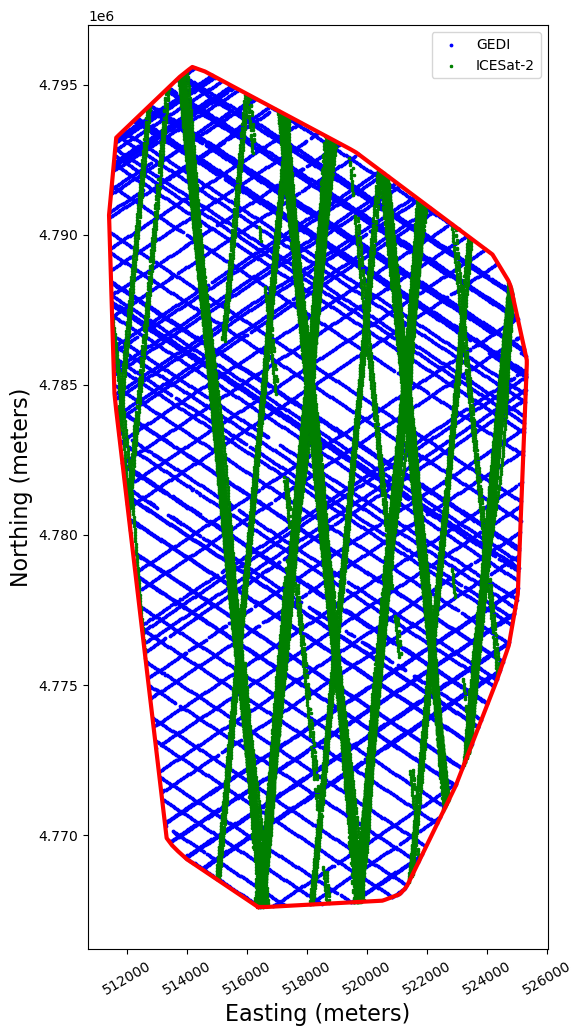

In [31]:
%matplotlib inline  
fig, ax = plt.subplots(figsize=(12, 12))
# ax.set_title("ICESat-2 Points")
ax.set_aspect('equal')
# Plot GEDI and ICESat-2 points
# pregion.plot(); #plot origonal boundery 
merged_gedi_gdf_l1b.plot(ax=ax, marker='o', color='blue', markersize=3, label="GEDI")
icesat2_gdf_atl03_veg_ground.plot(ax=ax, marker='x', color='green', markersize=3, label="ICESat-2")
ax.plot(region_lon, region_lat, linewidth=3, color='r')

# plt.title("GEDI and ICESat-2 Tracks in RCEW")
plt.xlabel("Easting (meters)", fontsize = 16)
plt.xticks(rotation=30)
plt.ylabel("Northing (meters)", fontsize = 16)
plt.legend(loc="upper right")  # or "lower left", "upper left", etc.
# plt.legend(fontsize=6, loc="upper right") # or "lower left", "upper left", etc.
plt.show()

## Save the Georeferenced Data to GeoJson

In [91]:
# # Save the data to GeoJSON files
# merged_gedi_gdf_l1b.to_file("gedi_georeferenced.geojson", driver="GeoJSON")
# icesat2_gdf_atl03.to_file("icesat2_georeferenced.geojson", driver="GeoJSON")

## Computing Vegetation height

The approach here is to compute the difference between the ground elevation and the canopy top elevation.
With the GEDI data, it is quite straight forward. In other words, we use the elevations of the detected modes in the received waveform, `rxwaveform`, to compute the vegetation. We simply find the difference between the elevations of the highest and lowest detected modes to calculate the Relative Height(RH) metrics or simply the vegetation height. If the received waveform has only one detected mode, then it represents bare ground and the vegetation height is zero. Thus, for such a received waveform, the elevations of the highest and lowest detected modes are equal. 

```
Interpretation of RH Metrics
The GEDI L2A data product provides relative height (RH) metrics, which are “lidar perceived” metrics that have the following characteristics:
    1. RH100 = elev_highestreturn - elev_lowestmode
    2. The RH metrics are intended for vegetated surfaces. Results over bare/water surfaces are still valid but may present some confusing results.
    3. The lower RH metrics (e.g., RH10) will often have negative values, particularly in low canopy cover conditions. This is because a relatively high fraction of the waveform energy is from the ground and below elev_lowestmode. For example, if the ground return contains 30% of the energy, then RH1 through 15 are likely to be below 0 since half of the ground energy from the ground return is below the center of the ground return, which is used to determine the mean ground elevation in the footprint (elev_lowestmode).
```

`elev_highestreturn:` "Elevation of highest detected return relative to reference ellipsoid". This is the elevation of the canopy top.

`elev_lowestmode:` "Elevation of center of lowest mode relative to reference ellipsoid". This is the ground elevation.

<!-- For the ICESat-2 data we use two different approaches: -->
<!-- - First, we use the ICESat-2 ATLO8 photon classification to separate canopy top photons from ground photons. We then we group the photons into segments using their segment IDs. In each segment, we take the maximum height of the canopy top photons as the canopy top elevation in that segment. In the same way, in each segment, we take the minimum height of the ground photons as the ground elevation in that segment. We then take the difference between the canopy top elevation and the ground elevation as the vegetation height. -->


For the ICESat-2 data, we use a simpple nearest neighbors approach. For each ground photon, we use the `cKDTree` algorithm to find the nearest canopy top photon spatially and temporally. We then take the difference between the heights of the canopy top photon and the ground photon as the vegetation height. In the absence of a canopy top photon we use the canopy photon.

In [92]:
# # Filter canopy and ground photons based on `atl08_class`
# # the photon’s ATL08 classification (0: noise, 1: ground, 2: canopy, 3: top of canopy, 4: unclassified)
# canopytop_photons = icesat2_gdf_atl03[icesat2_gdf_atl03['atl08_class'] == 3]  # atl08 classification code for canopy top is 3
# canopy_photons = icesat2_gdf_atl03[icesat2_gdf_atl03['atl08_class'] == 2]  # atl08 classification code for canopy is 3
# ground_photons = icesat2_gdf_atl03[icesat2_gdf_atl03['atl08_class'] == 1]  # atl08 classification code for the ground is 1

# # Group by segment and calculate max canopy height and min ground height for each group
# canopytop_heights = canopytop_photons.groupby('segment_id')['height'].max()
# canopy_heights = canopy_photons.groupby('segment_id')['height'].max()
# ground_heights = ground_photons.groupby('segment_id')['height'].min()

# # Merge canopy and ground heights into a single DataFrame
# vegetation_heights = pd.DataFrame({'canopytop_height': canopytop_heights, 'canopy_height': canopy_heights, 'ground_height': ground_heights})

# # Calculate vegetation height (canopy height - ground height) for each segment
# vegetation_heights['vegetation_height'] = vegetation_heights['canopy_height'] - vegetation_heights['ground_height']

# # Remove rows with NaN values in 'vegetation_height'
# vegetation_heights.dropna(subset=['vegetation_height'], inplace=True)
# # vegetation_heights.fillna(0)

# # Display the vegetation heights
# print(vegetation_heights[['vegetation_height']].describe())
# print(len(canopy_heights), len(ground_heights))


In [93]:
# from helper_functions import calculate_vegetation_height

# # # Filter canopy and ground photons based on `atl08_class`
# # # the photon’s ATL08 classification (0: noise, 1: ground, 2: canopy, 3: top of canopy, 4: unclassified)
# # # The second condition means we are only interested in strong beams
# # canopytop_photons = icesat2_gdf_atl03[(icesat2_gdf_atl03['atl08_class'] == 3) & (icesat2_gdf_atl03['sc_orient'] == icesat2_gdf_atl03['pair'])]    # Canopy top
# # canopy_photons = icesat2_gdf_atl03[(icesat2_gdf_atl03['atl08_class'] == 2) & (icesat2_gdf_atl03['sc_orient'] == icesat2_gdf_atl03['pair'])]   # Canopy
# # ground_photons = icesat2_gdf_atl03[(icesat2_gdf_atl03['atl08_class'] == 1) & (icesat2_gdf_atl03['sc_orient'] == icesat2_gdf_atl03['pair'])]   # Ground

# canopytop_photons = icesat2_gdf_atl03[icesat2_gdf_atl03['atl08_class'] == 3]    # Canopy top
# canopy_photons = icesat2_gdf_atl03[icesat2_gdf_atl03['atl08_class'] == 2]   # Canopy
# ground_photons = icesat2_gdf_atl03[icesat2_gdf_atl03['atl08_class'] == 1]   # Ground


# # Group by segment and calculate max canopy top height, max canopy height, and min ground height for each group
# canopytop_heights = canopytop_photons.groupby('segment_id')['height'].max()
# canopy_heights = canopy_photons.groupby('segment_id')['height'].max()
# ground_heights = ground_photons.groupby('segment_id')['height'].min()


# # # Group by segment and calculate max canopy top height, max canopy height, and min ground height for each group
# # canopytop_heights = pd.DataFrame(canopytop_photons.groupby('segment_id')['height'].max())
# # canopy_heights = pd.DataFrame(canopy_photons.groupby('segment_id')['height'].max())
# # ground_heights = pd.DataFrame(ground_photons.groupby('segment_id')['height'].min())

# # # Perform an outer join on the segment_id column
# # merged_df = (
# #     canopytop_heights
# #     .merge(canopy_heights, on='segment_id', how='outer', suffixes=('_canopytop', '_canopy'))
# #     .merge(ground_heights, on='segment_id', how='outer', suffixes=('', '_ground'))
# # )

# # # Rename the columns for clarity (optional)
# # merged_df.columns = ['canopytop_height', 'canopy_height', 'ground_height']

# # # Reset index (optional)
# # merged_df.reset_index(inplace=True)

# # # Display the merged DataFrame
# # print(merged_df)

# # Merge canopy and ground heights into a single DataFrame
# vegetation_heights = pd.DataFrame({
#     'canopytop_height': canopytop_heights, 
#     'canopy_height': canopy_heights, 
#     'ground_height': ground_heights
# })



# # Apply the calculation to each row
# vegetation_heights['vegetation_height'] = vegetation_heights.apply(calculate_vegetation_height, axis=1)

# # Replace NaN vegetation heights (if any exist due to missing canopy top height and canopy height) with 0
# vegetation_heights['vegetation_height'] = vegetation_heights['vegetation_height'].fillna(0)


# # Display the vegetation heights
# print(vegetation_heights[(vegetation_heights['vegetation_height'] >= 0)&(vegetation_heights['vegetation_height'] < 25)].describe())
# print(len(canopytop_heights), len(canopy_heights), len(ground_heights))


In [94]:
# vegetation_heights = vegetation_heights[(vegetation_heights["vegetation_height"] >= 0)&(vegetation_heights["vegetation_height"] < 30)]
# vegetation_heights.describe()

In [95]:
# print(icesat2_gdf_atl03.columns, "\n")
# # icesat2_gdf_atl08.columns

In [96]:
# import pandas as pd
# import numpy as np
# from scipy.spatial import cKDTree

# # # Separate canopy and ground points
# # canopytop_photons = icesat2_gdf_atl03[
# #     (icesat2_gdf_atl03['atl08_class'] == 3) & 
# #     (icesat2_gdf_atl03['sc_orient'] == icesat2_gdf_atl03['pair'])
# # ]  # Canopy top

# # canopy_photons = icesat2_gdf_atl03[
# #     (icesat2_gdf_atl03['atl08_class'] == 2) & 
# #     (icesat2_gdf_atl03['sc_orient'] == icesat2_gdf_atl03['pair'])
# # ]  # Canopy

# # ground_photons = icesat2_gdf_atl03[
# #     (icesat2_gdf_atl03['atl08_class'] == 1) & 
# #     (icesat2_gdf_atl03['sc_orient'] == icesat2_gdf_atl03['pair'])
# # ]  # Ground


# # Filter canopy and ground photons based on `atl08_class`
# # # # the photon’s ATL08 classification (0: noise, 1: ground, 2: canopy, 3: top of canopy, 4: unclassified)
# canopytop_photons = icesat2_gdf_atl03[icesat2_gdf_atl03['atl08_class'] == 3]  # canopy top
# canopy_photons = icesat2_gdf_atl03[icesat2_gdf_atl03['atl08_class'] == 2]  # canopy
# ground_photons = icesat2_gdf_atl03[icesat2_gdf_atl03['atl08_class'] == 1]  # ground

# # Convert latitude and longitude to radians for accurate distance calculations
# canopytop_coords = np.radians(canopytop_photons[['Latitude', 'Longitude']].values)
# canopy_coords = np.radians(canopy_photons[['Latitude', 'Longitude']].values)
# ground_coords = np.radians(ground_photons[['Latitude', 'Longitude']].values)

# # Create KDTree for canopy top and canopy photons
# canopytop_tree = cKDTree(canopytop_coords)
# canopy_tree = cKDTree(canopy_coords)

# # Find the nearest canopy top photon to every ground photon
# # Distance in radians (e.g., 100 meters on Earth's surface is approx 0.0009 radians)
# distances_top, indices_top = canopytop_tree.query(ground_coords, distance_upper_bound=0.0000009)  # ~100 meters

# # Find the nearest canopy photon to every ground photon
# # Distance in radians (e.g., 100 meters on Earth's surface is approx 0.0009 radians)
# distances_canopy, indices_canopy = canopy_tree.query(ground_coords, distance_upper_bound=0.0000009)  # ~100 meters

# # Compute vegetation height
# veg_heights = []
# for i, (dist_top, index_top, dist_canopy, index_canopy) in enumerate(
#     zip(distances_top, indices_top, distances_canopy, indices_canopy)
# ):
#     if dist_top != np.inf:  # canopy top photon exists in the neighborhood
#         vegetation_height = canopytop_photons.iloc[index_top]['height'] - ground_photons.iloc[i]['height']
#     elif dist_canopy != np.inf:  # fall back to canopy photon
#         vegetation_height = canopy_photons.iloc[index_canopy]['height'] - ground_photons.iloc[i]['height']
#     else:  # no canopy photon found
#         vegetation_height = 0
#     veg_heights.append(vegetation_height)

# # Add vegetation heights as a new column to the ground_photons DataFrame
# # ground_photons.loc[:, 'vegetation_height'] = veg_heights
# icesat2_gdf_atl03_veg_height = ground_photons.copy()
# icesat2_gdf_atl03_veg_height['vegetation_height'] = veg_heights

# # Display results
# print(icesat2_gdf_atl03_veg_height[['Latitude', 'Longitude', 'height', 'vegetation_height']])
# print(icesat2_gdf_atl03_veg_height[['Latitude', 'Longitude', 'height', 'vegetation_height']].describe())

In [97]:
# icesat2_gdf_atl03_veg_height = icesat2_gdf_atl03_veg_height[(icesat2_gdf_atl03_veg_height["vegetation_height"] > 0)&(icesat2_gdf_atl03_veg_height["vegetation_height"] < 25)]
# icesat2_gdf_atl03_veg_height["vegetation_height"].describe()

In [98]:
# # import pandas as pd
# # import numpy as np
# # from scipy.spatial import cKDTree

# # Convert dates to numeric format (days since first observation)
# icesat2_gdf_atl03['date_numeric'] = (pd.to_datetime(icesat2_gdf_atl03['date']) - 
#                                      pd.to_datetime(icesat2_gdf_atl03['date']).min()).dt.days

# # Apply Min-Max Scaling to date (best for small date ranges)
# min_date = icesat2_gdf_atl03['date_numeric'].min()
# max_date = icesat2_gdf_atl03['date_numeric'].max()
# icesat2_gdf_atl03['date_scaled'] = (icesat2_gdf_atl03['date_numeric'] - min_date) / (max_date - min_date)

# # Filter canopy and ground photons based on `atl08_class`
# # ATL08 classification: (0: noise, 1: ground, 2: canopy, 3: top of canopy, 4: unclassified)
# canopytop_photons = icesat2_gdf_atl03[icesat2_gdf_atl03['atl08_class'] == 3]  # Canopy top
# canopy_photons = icesat2_gdf_atl03[icesat2_gdf_atl03['atl08_class'] == 2]  # Canopy
# ground_photons = icesat2_gdf_atl03[icesat2_gdf_atl03['atl08_class'] == 1]  # Ground

# # Convert latitude, longitude to radians for accurate distance calculations
# canopytop_coords = np.radians(canopytop_photons[['Latitude', 'Longitude']].values)
# canopy_coords = np.radians(canopy_photons[['Latitude', 'Longitude']].values)
# ground_coords = np.radians(ground_photons[['Latitude', 'Longitude']].values)

# # Include date (normalized) in the search
# canopytop_tree_coords = np.column_stack((canopytop_coords, canopytop_photons['date_scaled'].values))
# canopy_tree_coords = np.column_stack((canopy_coords, canopy_photons['date_scaled'].values))
# ground_tree_coords = np.column_stack((ground_coords, ground_photons['date_scaled'].values))

# # Create KDTree for canopy top and canopy photons (considering spatial + temporal dimensions)
# canopytop_tree = cKDTree(canopytop_tree_coords)
# canopy_tree = cKDTree(canopy_tree_coords)

# # Distance thresholds (approx. 30 meters in radians)
# distance_threshold = 4.71e-6 #0.00000471

# # Find the nearest canopy top photon (considering distance & date)
# distances_top, indices_top = canopytop_tree.query(ground_tree_coords, distance_upper_bound=distance_threshold)

# # Find the nearest canopy photon (considering distance & date)
# distances_canopy, indices_canopy = canopy_tree.query(ground_tree_coords, distance_upper_bound=distance_threshold)

# # Compute vegetation height
# veg_heights = []
# for i, (dist_top, index_top, dist_canopy, index_canopy) in enumerate(
#     zip(distances_top, indices_top, distances_canopy, indices_canopy)
# ):
#     if dist_top != np.inf:  # closest canopy top photon exists within the threshold
#         vegetation_height = canopytop_photons.iloc[index_top]['height'] - ground_photons.iloc[i]['height']
#     elif dist_canopy != np.inf:  # if there is no canopy top photon, fall back to closest canopy photon
#         vegetation_height = canopy_photons.iloc[index_canopy]['height'] - ground_photons.iloc[i]['height']
#     else:  # if there is not canopy top or canopy photon found, then the vegetation height is zero.
#         vegetation_height = 0
#     veg_heights.append(vegetation_height)

# # Store vegetation height in the DataFrame
# icesat2_gdf_atl03_veg_ground = ground_photons.copy()
# icesat2_gdf_atl03_veg_ground['vegetation_height'] = veg_heights

# # Display results
# # print(icesat2_gdf_atl03_veg_height[['Latitude', 'Longitude', 'height', 'vegetation_height']])
# print(icesat2_gdf_atl03_veg_ground[['Latitude', 'Longitude', 'height', 'vegetation_height']].describe())
# # icesat2_gdf_atl03_veg_ground = icesat2_gdf_atl03_veg_ground[(icesat2_gdf_atl03_veg_ground["vegetation_height"] >= 0)&(icesat2_gdf_atl03_veg_ground["vegetation_height"] < 5)]
# icesat2_gdf_atl03_veg_ground["vegetation_height"].describe() 

In [99]:
len(icesat2_gdf_atl03_veg_ground[icesat2_gdf_atl03_veg_ground["atl08_class"] == 1]) # select only ground photons

1141953

In [100]:
icesat2_gdf_atl03_veg_ground.columns

Index(['time', 'segment_dist', 'cycle', 'track', 'pair', 'sc_orient', 'rgt',
       'region', 'extent_id', 'segment_id', 'background_rate',
       'solar_elevation', 'atl03_cnf', 'height', 'relief', 'y_atc', 'x_atc',
       'quality_ph', 'snowcover', 'yapc_score', 'atl08_class', 'landcover',
       'spot', 'Longitude', 'Latitude', 'Easting', 'Northing',
       'elevation_NAVD88_icesat2_from_pipe',
       'elevation_NAVD88_icesat2_from_crs', 'Date', 'date',
       'vegetation_height', 'ICESat2_slope_rise_run', 'geometry'],
      dtype='object')

**The algorithm in this code:**
1. Finds all canopy top and canopy photons that were taken on the same date as each ground photon
2. Selects the spatially closest canopy top photon within the radius threshold
3. If no canopy top photon is found, selects the spatially closest canopy photon
4. If neither is found, vegetation height is set to zero
5. Ensures that each canopy top or canopy photon is assigned to only one ground photon (unique matching).

**Summary**
1. Filters canopy top and canopy photons by the same date as each ground photon first
    * `same_date_canopytop = canopytop_photons[canopytop_photons['date'] == ground_date]`
    * `same_date_canopy = canopy_photons[canopy_photons['date'] == ground_date]`

2. Uses `cKDTree` for spatial matching on same-date photons and maintains priority order
    * Finds the closest canopy top photon within 30m
    * If none are found, finds the closest canopy photon within 30m
    * If neither are found, sets vegetation height to 0

3. Stops searching after finding the best match
    * This avoids unnecessary distance calculations.
    
4. Ensures that each canopy top or canopy photon is assigned to only one ground photon.
    * Uses `used_canopytop_indices` and `used_canopy_indices` to keep track of assigned photons.
    * A photon can only be used once as a nearest neighbor.

5. Avoids duplicate matches by checking `if idx_top not in used_canopytop_indices` before assigning a match.
    * Prevents multiple ground photons from using the same canopy top/canopy photon.
    
**Output**
* Each ground photon gets matched to a unique canopy top or canopy photon that was taken on the same date.
* Only the spatially closest photon (within 30m) is used.
* If no match is found, the vegetation height is set to 0.


**Return**
* The function returns a geodataframe with ICESat2 vegetation heights computed

In [101]:
# from scipy.spatial import cKDTree
# import pandas as pd
# import numpy as np

# # Convert dates to pandas datetime format
# icesat2_gdf_atl03['date'] = pd.to_datetime(icesat2_gdf_atl03['date'])

# # Filter canopy and ground photons based on `atl08_class`
# # ATL08 classification: (0: noise, 1: ground, 2: canopy, 3: top of canopy, 4: unclassified)
# canopytop_photons = icesat2_gdf_atl03[icesat2_gdf_atl03['atl08_class'] == 3].copy()  # Canopy top
# canopy_photons = icesat2_gdf_atl03[icesat2_gdf_atl03['atl08_class'] == 2].copy()  # Canopy
# ground_photons = icesat2_gdf_atl03[icesat2_gdf_atl03['atl08_class'] == 1].copy()  # Ground

# # Convert latitude, longitude to radians for accurate spatial distance calculations
# ground_photons['coords'] = np.radians(ground_photons[['Latitude', 'Longitude']].values.tolist())

# # Distance threshold (approx. 30 meters in radians)
# distance_threshold = 4.71e-6  # ~30 meters

# # Dictionary to store unique matches for canopy top and canopy photons
# used_canopytop_indices = set()
# used_canopy_indices = set()

# # Initialize list for vegetation heights
# veg_heights = []

# # Iterate over each ground photon
# for i, ground in ground_photons.iterrows():
#     ground_date = ground['date']
    
#     # **Step 1: Filter Canopy Top and Canopy Photons to the Same Date**
#     same_date_canopytop = canopytop_photons[canopytop_photons['date'] == ground_date]
#     same_date_canopy = canopy_photons[canopy_photons['date'] == ground_date]
    
#     # Convert coordinates to radians
#     canopytop_coords = np.radians(same_date_canopytop[['Latitude', 'Longitude']].values)
#     canopy_coords = np.radians(same_date_canopy[['Latitude', 'Longitude']].values)
    
#     # **Step 2: If any canopy top photons exist on the same date, find the spatially closest one**
#     if not same_date_canopytop.empty:
#         canopytop_tree = cKDTree(canopytop_coords)
#         dist_top, idx_top = canopytop_tree.query(ground['coords'], distance_upper_bound=distance_threshold)
        
#         if dist_top != np.inf and idx_top not in used_canopytop_indices:  # Unique match
#             vegetation_height = same_date_canopytop.iloc[idx_top]['height'] - ground['height']
#             veg_heights.append(vegetation_height)
#             used_canopytop_indices.add(idx_top)  # Mark as used
#             continue  # Stop here as we found a match

#     # **Step 3: If no canopy top photon was found, look for a canopy photon**
#     if not same_date_canopy.empty:
#         canopy_tree = cKDTree(canopy_coords)
#         dist_canopy, idx_canopy = canopy_tree.query(ground['coords'], distance_upper_bound=distance_threshold)
        
#         if dist_canopy != np.inf and idx_canopy not in used_canopy_indices:  # Unique match
#             vegetation_height = same_date_canopy.iloc[idx_canopy]['height'] - ground['height']
#             veg_heights.append(vegetation_height)
#             used_canopy_indices.add(idx_canopy)  # Mark as used
#             continue  # Stop here as we found a match

#     # **Step 4: If no valid canopy top or canopy photon was found, set vegetation height to 0**
#     veg_heights.append(0)

# # Store vegetation height in the DataFrame
# icesat2_gdf_atl03_veg_ground = ground_photons.copy()
# icesat2_gdf_atl03_veg_ground['vegetation_height'] = veg_heights

# Display first few rows
# print(icesat2_gdf_atl03_veg_ground.head())

# Display results
icesat2_gdf_atl03_veg_ground = icesat2_gdf_atl03_veg_ground[icesat2_gdf_atl03_veg_ground["vegetation_height"]>=0]
print(icesat2_gdf_atl03_veg_ground[['Latitude', 'Longitude', 'height', 'vegetation_height']].describe())
icesat2_gdf_atl03_veg_ground["vegetation_height"].describe() 

           Latitude     Longitude        height  vegetation_height
count  1.141952e+06  1.141952e+06  1.141952e+06       1.141952e+06
mean   4.319154e+01 -1.167696e+02  1.465510e+03       4.233689e-05
std    5.947494e-02  3.675045e-02  2.697679e+02       1.172574e-02
min    4.306083e+01 -1.168554e+02  6.944468e+02       0.000000e+00
25%    4.314652e+01 -1.167942e+02  1.208001e+03       0.000000e+00
50%    4.319995e+01 -1.167736e+02  1.421129e+03       0.000000e+00
75%    4.323722e+01 -1.167411e+02  1.685917e+03       0.000000e+00
max    4.331117e+01 -1.166940e+02  2.102514e+03       6.481700e+00


count    1.141952e+06
mean     4.233689e-05
std      1.172574e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.481700e+00
Name: vegetation_height, dtype: float64

## Computing slope.

### Method 1: The Haversine Approach

In [102]:
# # This code was transferred to load_gedi_data in helper_functions
# # # Extract coordinates and elevation data for GEDI
# # latitudes_gedi = merged_gedi_gdf_l1b['Latitude'][:]
# # longitudes_gedi = merged_gedi_gdf_l1b['Longitude'][:]
# # elevations_gedi = merged_gedi_gdf_l1b['geolocation_digital_elevation_model'][:] 

# # # Extract coordinates and elevation data for ICESat-2
# # latitudes_icesat2 = icesat2_gdf_atl03['Latitude'][:]
# # longitudes_icesat2 = icesat2_gdf_atl03['Longitude'][:]
# # elevations_icesat2 = icesat2_gdf_atl03['height'][:]

# # Extract coordinates and elevation data for ICESat-2
# latitudes_icesat2 = icesat2_gdf_atl03_veg_ground['Latitude'][:]
# longitudes_icesat2 = icesat2_gdf_atl03_veg_ground['Longitude'][:]
# elevations_icesat2 = icesat2_gdf_atl03_veg_ground['height'][:]

# # # Create GEDI GeoDataFrame
# # gedi_points = [Point(lon, lat) for lon, lat in zip(longitudes_gedi, latitudes_gedi)]
# # gedi_gdf2 = gpd.GeoDataFrame({'elevation': elevations_gedi}, geometry=gedi_points, crs="EPSG:6340")

# # Create ICESat-2 GeoDataFrame
# icesat2_points = [Point(lon, lat) for lon, lat in zip(longitudes_icesat2, latitudes_icesat2)]
# icesat2_gdf2 = gpd.GeoDataFrame({'elevation': elevations_icesat2}, geometry=icesat2_points, crs="EPSG:6340")

In [103]:
# from helper_functions import haversine
# # # This code was transferred to load_gedi_data in helper_functions
# # # Calculate slope for GEDI data
# # gedi_slopes = []
# # for i in range(1, len(gedi_gdf2)):
# #     dist = haversine(latitudes_gedi.iloc[i-1], longitudes_gedi.iloc[i-1], latitudes_gedi.iloc[i], longitudes_gedi.iloc[i])
# #     delta_elevation = elevations_gedi.iloc[i] - elevations_gedi.iloc[i-1]
# #     slope = delta_elevation / dist if dist != 0 else 0
# #     gedi_slopes.append(slope)

# # Calculate slope for ICESat-2 data
# icesat2_slopes = [-999]
# for i in range(1, len(icesat2_gdf2)):
#     dist = haversine(latitudes_icesat2.iloc[i-1], longitudes_icesat2.iloc[i-1], latitudes_icesat2.iloc[i], longitudes_icesat2.iloc[i])
#     delta_elevation = elevations_icesat2.iloc[i] - elevations_icesat2.iloc[i-1]
#     slope = delta_elevation / dist if dist != 0 else 0
#     icesat2_slopes.append(slope)
    
# # icesat2_slopes
# prefix = "ICESat2"
# icesat2_gdf_atl03_veg_ground[prefix+f'{"_slope_haversine"}'] = icesat2_slopes

### Method 2: The Rise/Run Approach
Here, we use the difference in elevation and coordinates between successive points to compute the slope between those points. To calculate the slope between successive points,  we will calculate the rate of change in elevation over distance between points in the data. Thus, we will compute the change in elevation (rise) and the change in horizontal distance (run) between each consecutive point. Finally, the slope is the ratio of the two, rise/run.

In [104]:
# # import numpy as np
# # import geopandas as gpd
# # from shapely.geometry import Point
# # from math import atan2, degrees

# from helper_functions import calculate_slope
# The EPSG code for NAD83/UTM zone 11N is 26911
# # gedi_gdf3 and icesat2_gdf3 already contain points with a projected CRS (e.g., UTM)
# # gedi_gdf3 = gedi_gdf2.to_crs("EPSG:26911")  
# # Change to a projected CRS for easier distance calculation
# icesat2_gdf3 = icesat2_gdf2.to_crs("EPSG:26911")
# # icesat2_gdf3 = canopy_photons.to_crs("EPSG:26911")

# # # Calculate slope for GEDI data
# # gedi_gdf = calculate_slope(gedi_gdf3)

# # Calculate slope for ICESat-2 data
# col_name = prefix+f'{"_slope_rise_run"}'
# icesat2_gdf = calculate_slope(icesat2_gdf3, prefix)
# icesat2_gdf_atl03_veg_ground[col_name] = icesat2_gdf[col_name]
# print(icesat2_gdf[['elevation', col_name]].head())

In [106]:
# icesat2_gdf.describe()
# icesat2_gdf

In [109]:
np.abs(icesat2_gdf_atl03_veg_ground["ICESat2_slope_rise_run"]).describe()

count    1.141952e+06
mean     3.448467e+01
std      4.016839e+01
min      0.000000e+00
25%      3.012025e-01
50%      5.681381e+00
75%      8.819753e+01
max      8.993054e+01
Name: ICESat2_slope_rise_run, dtype: float64

## Data Filtering

### Filter GEDI Data


In [135]:
for col in final_merged_gdf.columns:
    print(col)

BEAM_l2a
shot_number
Latitude_l2a
Longitude_l2a
index_l2a
degrade_flag
delta_time
digital_elevation_model
digital_elevation_model_srtm
elev_lowestmode
elevation_bias_flag
num_detectedmodes
quality_flag
rh_0
rh_1
rh_2
rh_3
rh_4
rh_5
rh_6
rh_7
rh_8
rh_9
rh_10
rh_11
rh_12
rh_13
rh_14
rh_15
rh_16
rh_17
rh_18
rh_19
rh_20
rh_21
rh_22
rh_23
rh_24
rh_25
rh_26
rh_27
rh_28
rh_29
rh_30
rh_31
rh_32
rh_33
rh_34
rh_35
rh_36
rh_37
rh_38
rh_39
rh_40
rh_41
rh_42
rh_43
rh_44
rh_45
rh_46
rh_47
rh_48
rh_49
rh_50
rh_51
rh_52
rh_53
rh_54
rh_55
rh_56
rh_57
rh_58
rh_59
rh_60
rh_61
rh_62
rh_63
rh_64
rh_65
rh_66
rh_67
rh_68
rh_69
rh_70
rh_71
rh_72
rh_73
rh_74
rh_75
rh_76
rh_77
rh_78
rh_79
rh_80
rh_81
rh_82
rh_83
rh_84
rh_85
rh_86
rh_87
rh_88
rh_89
rh_90
rh_91
rh_92
rh_93
rh_94
rh_95
rh_96
rh_97
rh_98
rh_99
rh_100
rx_assess_quality_flag
selected_algorithm
sensitivity
solar_elevation
surface_flag
geometry_l2a
acquisition_date_l2a
date_l2a
Easting_l2a
Northing_l2a
elevation_l2a
elevation_NAVD88_gedi_from_pipe_l2a


In [122]:
print("Before:", len(final_merged_gdf))

gedi_slope_col1 = "GEDI02_A_slope_rise_run"
gedi_slope_col2 = "GEDI02_A_slope_degrees_utm"

# Place a cut on vegetation height
final_merged_gdf[gedi_slope_col1] = np.abs(final_merged_gdf[gedi_slope_col1])
final_merged_gdf[gedi_slope_col2] = np.abs(final_merged_gdf[gedi_slope_col2])
# final_merged_gdf = final_merged_gdf[(final_merged_gdf["rh_100"] >= 0)&(final_merged_gdf["rh_100"] <= 5)]

print("After:", len(final_merged_gdf))

Before: 23262
After: 23262


In [123]:
final_merged_gdf[[gedi_slope_col1, gedi_slope_col2]].describe()

GEDI02_A_slope_rise_run  GEDI02_A_slope_degrees_utm
count             2.326200e+04                2.326200e+04
mean              8.518279e+00                8.510024e+00
std               8.596433e+00                8.594407e+00
min               1.420441e-07                1.420441e-07
25%               1.065424e+00                1.068968e+00
50%               6.150921e+00                6.136765e+00
75%               1.346162e+01                1.345587e+01
max               5.802684e+01                5.802684e+01

### Filter ICESat2 Data

In [127]:
# for col in icesat2_gdf_atl03_veg_ground.columns:
#     print(col)

In [131]:
print("Before:", len(icesat2_gdf_atl03_veg_ground))

icesat2_slope_col1 = "ICESat2_slope_degrees_utm"
icesat2_slope_col2 = "ICESat2_slope_rise_run"

# # Drop rows with missing values encoded as NaN's and -999.
# icesat2_gdf_atl03_veg_ground = icesat2_gdf_atl03_veg_ground.dropna()
# icesat2_gdf_atl03_veg_ground = icesat2_gdf_atl03_veg_ground[icesat2_gdf_atl03_veg_ground[icesat2_slope_col1] != -999]

# Place a cut on vegetation height
# icesat2_gdf_atl03_veg_ground[icesat2_slope_col1] = np.abs(icesat2_gdf_atl03_veg_ground[icesat2_slope_col1])
icesat2_gdf_atl03_veg_ground[icesat2_slope_col2] = np.abs(icesat2_gdf_atl03_veg_ground[icesat2_slope_col2])
# icesat2_gdf_atl03_veg_ground_final = icesat2_gdf_atl03_veg_ground[(icesat2_gdf_atl03_veg_ground["vegetation_height"] >= 0)&(icesat2_gdf_atl03_veg_ground["vegetation_height"] <= 5)]
# print("After:", len(icesat2_gdf_atl03_veg_ground_final))

Before: 1141952


### Plotting data

Below we plot both GEDI and ICESat2 tracks together after the filtering. 

In [132]:
# # Specify region of interest shapefile
# shp = "/bsuhome/tnde/geoscience/carbon_estimation/shapefiles/RCEW-outline_WGS84.shp"
# shapefile = gpd.read_file(shp)
# # shapefile.to_file('DryCreek/boundDCEW/boundDCEW_WGS84.geojson', driver='GeoJSON')
# shapefile.crs is None

# # Specify region of interest from geojson
# poly_fn = '/bsuhome/tnde/geoscience/carbon_estimation/shapefiles/RCEW-outline_WGS84.geojson'
# pregion = gpd.read_file(poly_fn)
# region = sliderule.toregion(poly_fn)["poly"] # symplify 
# # region

# # Prepare coordinate lists for plotting the region of interest polygon
# region_lon = [e["lon"] for e in region]
# region_lat = [e["lat"] for e in region]

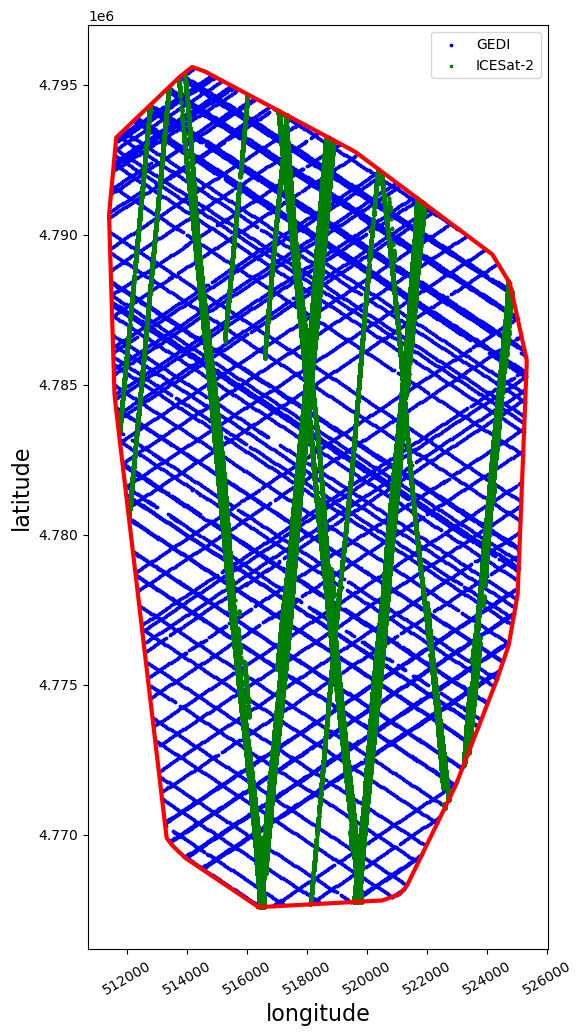

In [133]:
%matplotlib inline  
fig, ax = plt.subplots(figsize=(12, 12))
# ax.set_title("ICESat-2 Points")
ax.set_aspect('equal')
# Plot GEDI and ICESat-2 points
# pregion.plot(); #plot origonal boundery 
final_merged_gdf.plot(ax=ax, marker='o', color='blue', markersize=3, label="GEDI")
icesat2_gdf_atl03_veg_ground.plot(ax=ax, marker='x', color='green', markersize=3, label="ICESat-2")
ax.plot(region_lon, region_lat, linewidth=3, color='r')


# plt.title("GEDI and ICESat-2 Tracks in RCEW")
plt.xlabel("longitude", fontsize = 16)
plt.xticks(rotation=30)
plt.ylabel("latitude", fontsize = 16)
plt.legend(loc="upper right")  # or "lower left", "upper left", etc.
# plt.legend(fontsize=6, loc="upper right") # or "lower left", "upper left", etc.
plt.show()

## Co-registration of GEDI and ICESat2 Data

### Method 1: Spatial Resampling or Aggregation

Here, we divide the ROI into smaller grid cells. We then perform spatially resample or aggregate the data into common spatial grid cells. Here we use a spatial grids of 0.01 degrees over the ROI and then compute the statistic of interest for each grid cells. In our case we use aggregate the values in each grid cell by taking the mean of the data in that cell. In this approach, we use GEDI coordinaates to create a bounding box ROI and then divided it into smaller grid cells.

In [134]:
print(final_merged_gdf.total_bounds)
print(icesat2_gdf_atl03_veg_ground.total_bounds)

[ 511433.53364427 4767616.13680433  525306.78456622 4795514.58817924]
[ 511745.49587003 4767589.26214134  524845.43412746 4795384.27246755]


In [166]:
# # Define grid parameters
# # grid_size = 0.005  # a 0.01° grid
# grid_size = 0.01  # 
# # minx, miny, maxx, maxy = icesat2_gdf_atl03.total_bounds
# minx, miny, maxx, maxy = merged_gedi_gdf_l1b.total_bounds

# # # Create grid cells
# x_cells = np.arange(minx, maxx, grid_size)
# y_cells = np.arange(miny, maxy, grid_size)
# grid_cells = [box(x, y, x + grid_size, y + grid_size) for x in x_cells for y in y_cells]
# grid_gdf = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs="EPSG:6340")

# # Spatial join GEDI and ICESat-2 points with grid to aggregate
# # gedi_aggregated = gpd.sjoin(merged_gedi_gdf_l1b_final, grid_gdf, predicate='within').groupby('index_right').mean()
# # icesat2_aggregated = gpd.sjoin(icesat2_gdf_atl03, grid_gdf, predicate='within').groupby('index_right').mean()

# # Perform spatial join
# gedi_joined_l1b = gpd.sjoin(merged_gedi_gdf_l1b_final, grid_gdf, predicate='within')
# icesat2_joined_atl03 = gpd.sjoin(icesat2_gdf_atl03_veg_ground_final, grid_gdf, predicate='within')

# # Separate numeric columns
# # It is important to retain the 'index_right' column before separating non-numeric columns
# # This will make it easier to merge the numeric and non-numeric columns back together.
# numeric_columns_gedi_l1b = gedi_joined_l1b.select_dtypes(include=['number']).columns
# numeric_columns_icesat2_atl03 = icesat2_joined_atl03.select_dtypes(include=['number']).columns

# # Separate non-numeric columns (including 'geometry' and other relevant fields such as rxwaveform)
# # In the code below we use drop instead of select_dtypes to keep 'index_right' in non-numeric columns
# # Again, this will make it easier to merge the numeric and non-numeric columns back together.
# non_numeric_columns_gedi_l1b = gedi_joined_l1b.drop(columns=numeric_columns_gedi_l1b[:-1])
# non_numeric_columns_icesat2_atl03 = icesat2_joined_atl03.drop(columns=numeric_columns_icesat2_atl03[:-1])

# # Aggregate numeric columns by taking the mean
# gedi_aggregated_l1b = gedi_joined_l1b[numeric_columns_gedi_l1b].groupby(gedi_joined_l1b['index_right']).mean()
# icesat2_aggregated_atl03 = icesat2_joined_atl03[numeric_columns_icesat2_atl03].groupby('index_right').mean()

# # Merge the non-numeric columns back with the aggregated results
# # Note: We use 'index_right' as the joining key
# gedi_aggregated_l1b = gedi_aggregated_l1b.merge(non_numeric_columns_gedi_l1b[non_numeric_columns_gedi_l1b.columns], 
#                                         left_index=True, right_on='index_right', how='left')
# icesat2_aggregated_atl03 = icesat2_aggregated_atl03.merge(non_numeric_columns_icesat2_atl03[non_numeric_columns_icesat2_atl03.columns], 
#                                               left_index=True, right_on='index_right', how='left')

# # Remove duplicate rows based on 'index_right'
# gedi_aggregated_l1b = gedi_aggregated_l1b.drop_duplicates(subset=['index_right'])
# icesat2_aggregated_atl03 = icesat2_aggregated_atl03.drop_duplicates(subset=['index_right'])

# # # Convert the results to GeoDataFrames and reattach the geometry from grid_gdf
# # gedi_aggregated = gpd.GeoDataFrame(gedi_aggregated, geometry=grid_gdf.geometry.loc[gedi_aggregated['index_right']])
# # icesat2_aggregated = gpd.GeoDataFrame(icesat2_aggregated, geometry=grid_gdf.geometry.loc[icesat2_aggregated['index_right']])

# # gedi_aggregated = gpd.GeoDataFrame(gedi_aggregated, geometry=grid_gdf.geometry.iloc[gedi_aggregated.index])
# # icesat2_aggregated = gpd.GeoDataFrame(icesat2_aggregated, geometry=grid_gdf.geometry.iloc[icesat2_aggregated.index])

# # Drop duplicate rows based on 'index_right'
# gedi_aggregated_l1b = gedi_aggregated_l1b.drop(columns=['index_right_x', 'index_right_y'], errors='ignore')
# icesat2_aggregated_atl03 = icesat2_aggregated_atl03.drop(columns=['index_right_x', 'index_right_y'], errors='ignore')

# # Set CRS if necessary
# gedi_aggregated_l1b.crs = grid_gdf.crs
# icesat2_aggregated_atl03.crs = grid_gdf.crs

In [169]:
# print(len(gedi_aggregated_l1b), len(icesat2_aggregated_atl03))

In [168]:
# # import matplotlib.pyplot as plt

# # Plot grid cells
# fig, ax = plt.subplots(figsize=(10, 10))
# grid_gdf.boundary.plot(ax=ax, color="gray", linewidth=0.5, label="Grid Cells")

# # Plot GEDI points
# merged_gedi_gdf_l1b_final.plot(ax=ax, marker='o', color='blue', markersize=5, alpha=0.6, label="GEDI Points")

# # Plot ICESat-2 points
# icesat2_gdf_atl03_veg_ground_final.plot(ax=ax, marker='x', color='green', markersize=5, alpha=0.6, label="ICESat-2 Points")

# ax.plot(region_lon, region_lat, linewidth=3, color='r')

# # Add legend and labels
# plt.legend()
# plt.xlabel("Longitude")
# plt.xticks(rotation=45)
# plt.ylabel("Latitude")
# plt.title("Grid Cells with GEDI and ICESat-2 Points")
# plt.show()

### Method 2: Nearest Neighbor Matching

This approach helps to match corresponding GEDI and ICESat-2 points that are spatially and temporally very close to each other. The idea is to ensure best match in both spatial and temporal proximity betweem GEDI and ICESat-2 points. With this approach we can match points within a certain radius. 

In this approach, we rely on `cKDTree` from the `scipy` library. In our approach, we resample ICESat-2 at GEDI points. This approach ensures nearest ICESat-2 points are chosen based on both space and time and andles missing matches by preserving only the closest valid match. It is efficient for large datasets using vectorized NumPy operations and cKDTree. With this, we ensures that GEDI and ICESat-2 points are coregistered optimally in both space and time. 

In [49]:
# 4.71e-6 #0.00000471  # ~30 meters in radians

# merged_gedi_gdf_l1b_final = merged_gedi_gdf_l1b_final.to_crs("EPSG:6340")
# icesat2_gdf_atl03_veg_ground_final = icesat2_gdf_atl03_veg_ground_final.to_crs("EPSG:6340")
print("GEDI CRS:", merged_gedi_gdf_l1b_final.crs)
print("ICESat-2 CRS:", icesat2_gdf_atl03_veg_ground_final.crs)

GEDI CRS: EPSG:4326
ICESat-2 CRS: EPSG:4326


#### Method 1

* Find the three closest ICESat-2 points for each GEDI point within a given spatial radius.
* Select the ICESat-2 point closest in time (date difference) to the GEDI point.
* Ensure uniqueness: Assign each GEDI point a unique ICESat-2 match so that no two GEDI points share the same ICESat-2 neighbor.

**Summary**
1. Finds the Three Closest ICESat-2 Points
    * Uses `k=3` in `cKDTree.query()` to retrieve the three nearest neighbors within the spatial threshold.

2. Filters Based on Temporal Closeness
    * Computes the absolute date difference (`|GEDI_date - ICESat2_date|` in days).
    * Selects the ICESat-2 point closest in time.

3. Ensures Unique Matches
    * Prevents two different GEDI points from being assigned the same ICESat-2 point.
    * Uses a dictionary (`unique_matches`) to track assigned ICESat-2 indices.

**Output**
* Each GEDI point will be matched with one unique ICESat-2 point that is:
    * Spatially close (within some meters)
    * Temporally close (smallest date difference)
    
* No duplicate ICESat-2 points will be assigned to multiple GEDI points.

In [58]:
from scipy.spatial import cKDTree
import pandas as pd
import numpy as np
from shapely.geometry import Point

# Create ICESat-2 GeoDataFrame with elevation and date
icesat2_gdf_atl03_veg_ground_final2 = icesat2_gdf_atl03_veg_ground_final.copy()
icesat2_gdf_atl03_veg_ground_final2["elevation"] = elevations_icesat2

# Convert coordinates to arrays for fast processing with KDTree
gedi_coords = merged_gedi_gdf_l1b_final.geometry.apply(lambda point: (point.x, point.y)).tolist()
icesat2_coords = icesat2_gdf_atl03_veg_ground_final2.geometry.apply(lambda point: (point.x, point.y)).tolist()

# Build KDTree for ICESat-2 data
icesat2_tree = cKDTree(icesat2_coords, copy_data=True, balanced_tree=True)

# Find the 3 nearest ICESat-2 neighbors for each GEDI point within a maximum radius (e.g., 100 meters)
distances, indices = icesat2_tree.query(gedi_coords, k=3, distance_upper_bound=1e-3)  # 100 meters in radians

# Ensure indices is a 2D list (if fewer than 3 neighbors are found, they get padded with len(icesat2_coords))
indices = np.array(indices)
distances = np.array(distances)

# Convert dates to pandas datetime format
gedi_dates = pd.to_datetime(merged_gedi_gdf_l1b_final['date_x'])
icesat2_dates = pd.to_datetime(icesat2_gdf_atl03_veg_ground_final2['date'])

# Dictionary to store the final unique matches
unique_matches = {}

# Iterate through each GEDI point and find the best ICESat-2 match
for i, (dists, idxs) in enumerate(zip(distances, indices)):
    valid_idxs = idxs[idxs < len(icesat2_coords)]  # Remove invalid indices (out of range)
    
    if len(valid_idxs) > 0:
        # Compute time difference (absolute difference in days) between GEDI and ICESat-2 points
        time_diffs = np.abs(gedi_dates.iloc[i] - icesat2_dates.iloc[valid_idxs]).dt.days
        
        # Select the ICESat-2 point with the minimum time difference
        min_time_idx = valid_idxs[np.argmin(time_diffs)]

        # Ensure uniqueness: Assign the ICESat-2 point to this GEDI point if not already used
        if min_time_idx not in unique_matches:
            unique_matches[min_time_idx] = i  # Store the index of the matched GEDI point

# Extract matched indices for GEDI and ICESat-2 points
unique_icesat2_indices = list(unique_matches.keys())
unique_gedi_indices = list(unique_matches.values())

# Extract matched coordinates and elevations
matched_icesat2 = [icesat2_coords[j] for j in unique_icesat2_indices]
matched_gedi = [gedi_coords[i] for i in unique_gedi_indices]
icesat2_elevations_matched = [icesat2_gdf_atl03_veg_ground_final2.iloc[j].elevation for j in unique_icesat2_indices]
gedi_elevations_matched = [merged_gedi_gdf_l1b_final.iloc[i].elevation for i in unique_gedi_indices]

# Extract matched dates for reference
gedi_dates_matched = [gedi_dates.iloc[i] for i in unique_gedi_indices]
icesat2_dates_matched = [icesat2_dates.iloc[j] for j in unique_icesat2_indices]

# Create DataFrame with unique coregistered data
coregistered_df = pd.DataFrame({
    'gedi_lat': [point[1] for point in matched_gedi],
    'gedi_lon': [point[0] for point in matched_gedi],
    'icesat2_lat': [point[1] for point in matched_icesat2],
    'icesat2_lon': [point[0] for point in matched_icesat2],
    'gedi_elevation': gedi_elevations_matched,
    'icesat2_elevation': icesat2_elevations_matched,
    'gedi_date': gedi_dates_matched,
    'icesat2_date': icesat2_dates_matched
})

# Display the first few rows
print(coregistered_df.head())

    gedi_lat    gedi_lon  icesat2_lat  icesat2_lon  gedi_elevation  \
0  43.304448 -116.827098    43.304329  -116.827940       1749.9028   
1  43.301384 -116.803230    43.301379  -116.802852       1631.6250   
2  43.273928 -116.846683    43.273865  -116.846116       1720.0085   
3  43.140850 -116.788331    43.140776  -116.787762       1778.0482   
4  43.141133 -116.787746    43.141129  -116.787717       1772.3922   

   icesat2_elevation           gedi_date                  icesat2_date  
0          1754.2620 2022-06-13 16:27:25 2019-08-26 08:08:34.655424256  
1          1611.2341 2022-06-13 16:27:25 2020-10-26 23:58:59.602326528  
2          1714.0575 2022-06-13 16:27:25 2020-10-26 23:59:00.061926656  
3          1777.5349 2022-10-01 20:47:55 2022-10-23 13:18:07.536942848  
4          1778.0255 2022-10-01 20:47:55 2022-10-23 13:18:07.531442944  


#### Method 2

* After finding the three closest spatial neighbors, the code checks if the time difference is greater than 180 days.
* If all three candidates exceed 180 days, no match is assigned for that GEDI point.
* Ensures unique ICESat-2 matches.


**Summary**
1. Time Threshold Check (≤ 180 Days)
    * After finding the three closest ICESat-2 points, the code filters out points where the date difference is greater than 180 days.
    * If all three candidates exceed 180 days, the GEDI point remains unmatched.

2. Prevents Duplicate ICESat-2 Matches
    * Each ICESat-2 point is assigned to only one GEDI point to avoid conflicts.

3. Maintains Spatial and Temporal Priority
    * First filters by spatial closeness (3 nearest neighbors).
    * Then selects the closest in time (days).
    * Finally, enforces uniqueness.

**Output**
1. Each GEDI point gets a single matched ICESat-2 point that:
    * Is one of the three closest spatially.
    * Has the smallest time difference (≤ 180 days).
    * Is not assigned to another GEDI point.
    
2. GEDI points with no valid matches (spatially close but time > 180 days) are removed.

In [ ]:
from scipy.spatial import cKDTree
import pandas as pd
import numpy as np
from shapely.geometry import Point

# Create ICESat-2 GeoDataFrame with elevation and date
icesat2_gdf_atl03_veg_ground_final2 = icesat2_gdf_atl03_veg_ground_final.copy()
icesat2_gdf_atl03_veg_ground_final2["elevation"] = elevations_icesat2

# Convert coordinates to arrays for fast processing with KDTree
gedi_coords = merged_gedi_gdf_l1b_final.geometry.apply(lambda point: (point.x, point.y)).tolist()
icesat2_coords = icesat2_gdf_atl03_veg_ground_final2.geometry.apply(lambda point: (point.x, point.y)).tolist()

# Build KDTree for ICESat-2 data
icesat2_tree = cKDTree(icesat2_coords, copy_data=True, balanced_tree=True)

# Find the 3 nearest ICESat-2 neighbors for each GEDI point within a maximum radius (e.g., 100 meters)
distances, indices = icesat2_tree.query(gedi_coords, k=3, distance_upper_bound=1e-3)  # 100 meters in radians

# Ensure indices is a 2D list (if fewer than 3 neighbors are found, they get padded with len(icesat2_coords))
indices = np.array(indices)
distances = np.array(distances)

# Convert dates to pandas datetime format
gedi_dates = pd.to_datetime(merged_gedi_gdf_l1b_final['date_x'])
icesat2_dates = pd.to_datetime(icesat2_gdf_atl03_veg_ground_final2['date'])

# Dictionary to store the final unique matches
unique_matches = {}
max_time_difference = 180  # Maximum allowed time difference in days

# Iterate through each GEDI point and find the best ICESat-2 match
for i, (dists, idxs) in enumerate(zip(distances, indices)):
    valid_idxs = idxs[idxs < len(icesat2_coords)]  # Remove invalid indices (out of range)
    
    if len(valid_idxs) > 0:
        # Compute time difference (absolute difference in days) between GEDI and ICESat-2 points
        time_diffs = np.abs(gedi_dates.iloc[i] - icesat2_dates.iloc[valid_idxs]).dt.days
        
        # Filter only those within the allowed time difference (<= 180 days)
        valid_time_mask = time_diffs <= max_time_difference
        valid_time_idxs = valid_idxs[valid_time_mask]
        
        if len(valid_time_idxs) > 0:
            # Select the ICESat-2 point with the minimum time difference
            min_time_idx = valid_time_idxs[np.argmin(time_diffs[valid_time_mask])]

            # Ensure uniqueness: Assign the ICESat-2 point to this GEDI point if not already used
            if min_time_idx not in unique_matches:
                unique_matches[min_time_idx] = i  # Store the index of the matched GEDI point

# Extract matched indices for GEDI and ICESat-2 points
unique_icesat2_indices = list(unique_matches.keys())
unique_gedi_indices = list(unique_matches.values())

# Extract matched coordinates and elevations
matched_icesat2 = [icesat2_coords[j] for j in unique_icesat2_indices]
matched_gedi = [gedi_coords[i] for i in unique_gedi_indices]
icesat2_elevations_matched = [icesat2_gdf_atl03_veg_ground_final2.iloc[j].elevation for j in unique_icesat2_indices]
gedi_elevations_matched = [merged_gedi_gdf_l1b_final.iloc[i].elevation for i in unique_gedi_indices]

# Extract matched dates for reference
gedi_dates_matched = [gedi_dates.iloc[i] for i in unique_gedi_indices]
icesat2_dates_matched = [icesat2_dates.iloc[j] for j in unique_icesat2_indices]

# Create DataFrame with unique coregistered data
coregistered_df = pd.DataFrame({
    'gedi_lat': [point[1] for point in matched_gedi],
    'gedi_lon': [point[0] for point in matched_gedi],
    'icesat2_lat': [point[1] for point in matched_icesat2],
    'icesat2_lon': [point[0] for point in matched_icesat2],
    'gedi_elevation': gedi_elevations_matched,
    'icesat2_elevation': icesat2_elevations_matched,
    'gedi_date': gedi_dates_matched,
    'icesat2_date': icesat2_dates_matched
})

# Display the first few rows
print(coregistered_df.head())


### Approach 2: Nearest Neighbor Matching
#### Method 3

1. **Time-first filtering**: First, we find all ICESat-2 points within the maximum time difference (180 days).
2. **Spatial Nearest Filtering**: Out of those time-matching points, we then find the spatially closest ICESat-2 point.
3. **Unique Matching**: Ensures no two GEDI points share the same ICESat-2 match.

**Summary**
1. Finds all ICESat-2 points within 180 days first
    * Uses `time_diffs = np.abs(gedi_date - icesat2_dates).dt.days`
    * Filters only those within `max_time_difference = 180`.

2. Then selects the nearest spatial neighbor
    * Builds a new KDTree only for time-matching points.
    * Finds the closest within `max_distance = k meters`. `k` is 100 meters in this case.

3. Ensures each ICESat-2 point is uniquely matched
    * If an ICESat-2 point is already assigned, it's skipped.

**Output**
1. Each GEDI point is matched to one ICESat-2 point that:
    * Has a time difference ≤ 180 days.
    * Is the closest spatial match among time-filtered points.
    * Is unique (no shared ICESat-2 matches).


In [51]:
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from shapely.geometry import Point

# Create ICESat-2 GeoDataFrame with elevation and date
icesat2_gdf_atl03_veg_ground_final2 = icesat2_gdf_atl03_veg_ground_final.copy()
icesat2_gdf_atl03_veg_ground_final2["elevation"] = icesat2_gdf_atl03_veg_ground_final2['height'][:]

# Convert coordinates to arrays for fast processing with KDTree
gedi_coords = merged_gedi_gdf_l1b_final.geometry.apply(lambda point: (point.x, point.y)).tolist()
icesat2_coords = icesat2_gdf_atl03_veg_ground_final2.geometry.apply(lambda point: (point.x, point.y)).tolist()

# Convert dates to pandas datetime format
gedi_dates = pd.to_datetime(merged_gedi_gdf_l1b_final['date_x'])
icesat2_dates = pd.to_datetime(icesat2_gdf_atl03_veg_ground_final2['date'])

# Maximum allowed thresholds
max_time_difference = 180  # Maximum days difference allowed
max_distance = 1e-3  # 100 meters in radians

# Dictionary to store the final unique matches
unique_matches = {}

# Iterate through each GEDI point
for i, gedi_point in enumerate(gedi_coords):
    gedi_date = gedi_dates.iloc[i]
    
    # Compute time differences for all ICESat-2 points
    time_diffs = np.abs(gedi_date - icesat2_dates).dt.days
    
    # Get ICESat-2 indices that meet the time condition (<= 180 days)
    valid_time_idxs = np.where(time_diffs <= max_time_difference)[0]

    if len(valid_time_idxs) > 0:
        # Get coordinates of valid ICESat-2 points
        valid_icesat2_coords = [icesat2_coords[j] for j in valid_time_idxs]

        # Build a KDTree only for time-filtered ICESat-2 points
        icesat2_tree_filtered = cKDTree(valid_icesat2_coords)

        # Find the nearest ICESat-2 neighbor within max spatial threshold
        dist, nearest_idx = icesat2_tree_filtered.query(gedi_point, distance_upper_bound=max_distance)

        if nearest_idx < len(valid_time_idxs):  # Check if found within threshold
            selected_idx = valid_time_idxs[nearest_idx]

            # Ensure uniqueness (only assign if not already used)
            if selected_idx not in unique_matches:
                unique_matches[selected_idx] = i

# Extract matched indices for GEDI and ICESat-2 points
unique_icesat2_indices = list(unique_matches.keys())
unique_gedi_indices = list(unique_matches.values())

# Extract matched coordinates and elevations
matched_icesat2 = [icesat2_coords[j] for j in unique_icesat2_indices]
matched_gedi = [gedi_coords[i] for i in unique_gedi_indices]
icesat2_elevations_matched = [icesat2_gdf_atl03_veg_ground_final2.iloc[j].elevation for j in unique_icesat2_indices]
gedi_elevations_matched = [merged_gedi_gdf_l1b_final.iloc[i].elevation for i in unique_gedi_indices]

# Extract matched dates for reference
gedi_dates_matched = [gedi_dates.iloc[i] for i in unique_gedi_indices]
icesat2_dates_matched = [icesat2_dates.iloc[j] for j in unique_icesat2_indices]

# Create DataFrame with unique coregistered data
coregistered_df = pd.DataFrame({
    'gedi_lat': [point[1] for point in matched_gedi],
    'gedi_lon': [point[0] for point in matched_gedi],
    'icesat2_lat': [point[1] for point in matched_icesat2],
    'icesat2_lon': [point[0] for point in matched_icesat2],
    'gedi_elevation': gedi_elevations_matched,
    'icesat2_elevation': icesat2_elevations_matched,
    'gedi_date': gedi_dates_matched,
    'icesat2_date': icesat2_dates_matched
})

# Display the first few rows
print(coregistered_df.head())

    gedi_lat    gedi_lon  icesat2_lat  icesat2_lon  gedi_elevation  \
0  43.140850 -116.788331    43.140776  -116.787762       1778.0482   
1  43.141133 -116.787746    43.141129  -116.787717       1772.3922   
2  43.174217 -116.705130    43.173805  -116.704274       1456.0839   
3  43.174502 -116.704539    43.174489  -116.704191       1459.0975   
4  43.174786 -116.703949    43.174807  -116.704151       1480.2487   

   icesat2_elevation           gedi_date                  icesat2_date  
0          1777.5349 2022-10-01 20:47:55 2022-10-23 13:18:07.536942848  
1          1778.0255 2022-10-01 20:47:55 2022-10-23 13:18:07.531442944  
2          1447.0028 2022-10-01 20:47:55 2022-10-23 13:18:06.963042816  
3          1467.2465 2022-10-01 20:47:55 2022-10-23 13:18:06.952242944  
4          1474.6426 2022-10-01 20:47:55 2022-10-23 13:18:06.947242752  


In [52]:
# print("First GEDI coordinates (lon, lat):", merged_gedi_gdf_l1b_final.geometry.x[:5], merged_gedi_gdf_l1b_final.geometry.y[:5])
# print("First ICESat-2 coordinates (lon, lat):", icesat2_gdf_atl03_veg_ground_final.geometry.x[:5], icesat2_gdf_atl03_veg_ground_final.geometry.y[:5])
coregistered_df

gedi_lat    gedi_lon  icesat2_lat  icesat2_lon  gedi_elevation  \
0    43.140850 -116.788331    43.140776  -116.787762       1778.0482   
1    43.141133 -116.787746    43.141129  -116.787717       1772.3922   
2    43.174217 -116.705130    43.173805  -116.704274       1456.0839   
3    43.174502 -116.704539    43.174489  -116.704191       1459.0975   
4    43.174786 -116.703949    43.174807  -116.704151       1480.2487   
..         ...         ...          ...          ...             ...   
375  43.252445 -116.842219    43.252400  -116.841891       1665.4037   
376  43.252744 -116.841590    43.252781  -116.841840       1656.4221   
377  43.253028 -116.840998    43.253131  -116.841793       1649.0734   
378  43.255379 -116.822404    43.255464  -116.821848       1418.2097   
379  43.255661 -116.821815    43.255659  -116.821876       1418.5898   

     icesat2_elevation           gedi_date                  icesat2_date  
0            1777.5349 2022-10-01 20:47:55 2022-10-23 13:18:07.536942848  
1            1778.0255 2022-10-01 20:47:55 2022-10-23 13:18:07.531442944  
2            1447.0028 2022-10-01 20:47:55 2022-10-23 13:18:06.963042816  
3            1467.2465 2022-10-01 20:47:55 2022-10-23 13:18:06.952242944  
4            1474.6426 2022-10-01 20:47:55 2022-10-23 13:18:06.947242752  
..                 ...                 ...                           ...  
375          1656.8782 2019-06-01 22:46:35 2019-07-30 21:39:58.076067328  
376          1660.6232 2019-06-01 22:46:35 2019-07-30 21:39:58.070067200  
377          1661.7683 2019-06-01 22:46:35 2019-07-30 21:39:58.064567296  
378          1415.6199 2019-06-01 22:46:35 2019-08-26 08:08:33.888624384  
379          1424.1426 2019-06-01 22:46:35 2019-08-26 08:08:33.891724288  

[380 rows x 8 columns]

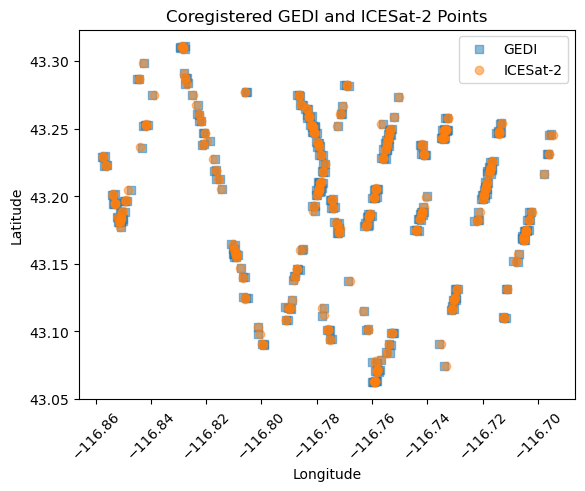

In [53]:
plt.scatter(coregistered_df['gedi_lon'], coregistered_df['gedi_lat'], label='GEDI', alpha=0.5, marker="s")
plt.scatter(coregistered_df['icesat2_lon'], coregistered_df['icesat2_lat'], label='ICESat-2', alpha=0.5, marker="o")
plt.xlabel('Longitude')
plt.xticks(rotation=45)
plt.ylabel('Latitude')
plt.legend()
plt.title('Coregistered GEDI and ICESat-2 Points')
plt.show()

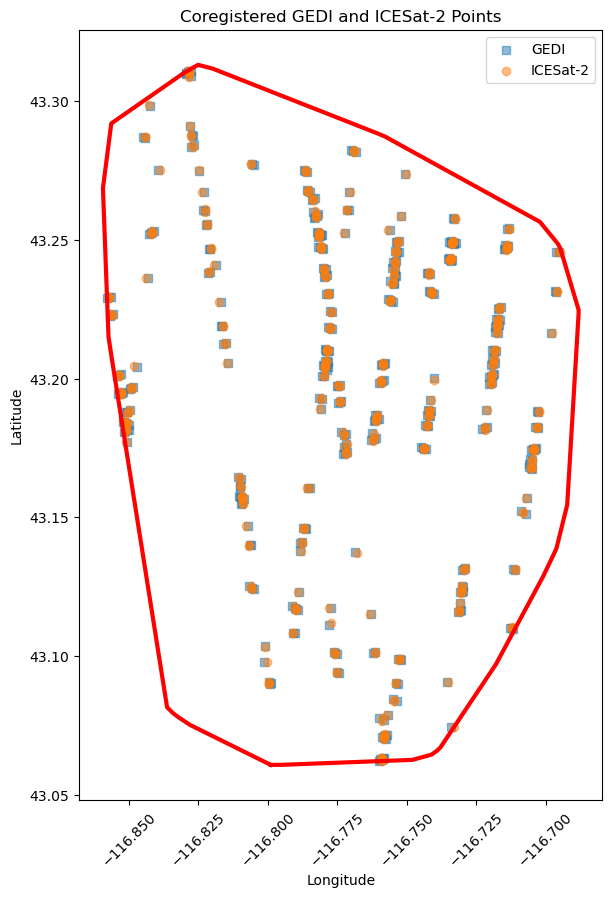

In [54]:
%matplotlib inline  

# Plot grid cells
fig, ax = plt.subplots(figsize=(14, 10))
ax.set_aspect('equal')
ax.plot(region_lon, region_lat, linewidth=3, color='r')

ax.scatter(coregistered_df['gedi_lon'], coregistered_df['gedi_lat'], label='GEDI', alpha=0.5, marker="s")
ax.scatter(coregistered_df['icesat2_lon'], coregistered_df['icesat2_lat'], label='ICESat-2', alpha=0.5, marker="o")


# Add legend and labels
plt.legend()
plt.xlabel("Longitude")
plt.xticks(rotation=45)
plt.ylabel("Latitude")
plt.title("Coregistered GEDI and ICESat-2 Points")
plt.show()

In [55]:
coregistered_df['elevation_difference'] = coregistered_df['icesat2_elevation'] - coregistered_df['gedi_elevation']
len(coregistered_df['elevation_difference'])

380

In [56]:
coregistered_df

gedi_lat    gedi_lon  icesat2_lat  icesat2_lon  gedi_elevation  \
0    43.140850 -116.788331    43.140776  -116.787762       1778.0482   
1    43.141133 -116.787746    43.141129  -116.787717       1772.3922   
2    43.174217 -116.705130    43.173805  -116.704274       1456.0839   
3    43.174502 -116.704539    43.174489  -116.704191       1459.0975   
4    43.174786 -116.703949    43.174807  -116.704151       1480.2487   
..         ...         ...          ...          ...             ...   
375  43.252445 -116.842219    43.252400  -116.841891       1665.4037   
376  43.252744 -116.841590    43.252781  -116.841840       1656.4221   
377  43.253028 -116.840998    43.253131  -116.841793       1649.0734   
378  43.255379 -116.822404    43.255464  -116.821848       1418.2097   
379  43.255661 -116.821815    43.255659  -116.821876       1418.5898   

     icesat2_elevation           gedi_date                  icesat2_date  \
0            1777.5349 2022-10-01 20:47:55 2022-10-23 13:18:07.536942848   
1            1778.0255 2022-10-01 20:47:55 2022-10-23 13:18:07.531442944   
2            1447.0028 2022-10-01 20:47:55 2022-10-23 13:18:06.963042816   
3            1467.2465 2022-10-01 20:47:55 2022-10-23 13:18:06.952242944   
4            1474.6426 2022-10-01 20:47:55 2022-10-23 13:18:06.947242752   
..                 ...                 ...                           ...   
375          1656.8782 2019-06-01 22:46:35 2019-07-30 21:39:58.076067328   
376          1660.6232 2019-06-01 22:46:35 2019-07-30 21:39:58.070067200   
377          1661.7683 2019-06-01 22:46:35 2019-07-30 21:39:58.064567296   
378          1415.6199 2019-06-01 22:46:35 2019-08-26 08:08:33.888624384   
379          1424.1426 2019-06-01 22:46:35 2019-08-26 08:08:33.891724288   

     elevation_difference  
0                 -0.5133  
1                  5.6333  
2                 -9.0811  
3                  8.1490  
4                 -5.6061  
..                    ...  
375               -8.5255  
376                4.2011  
377               12.6949  
378               -2.5898  
379                5.5528  

[380 rows x 9 columns]

## Vegetation Height Distribution

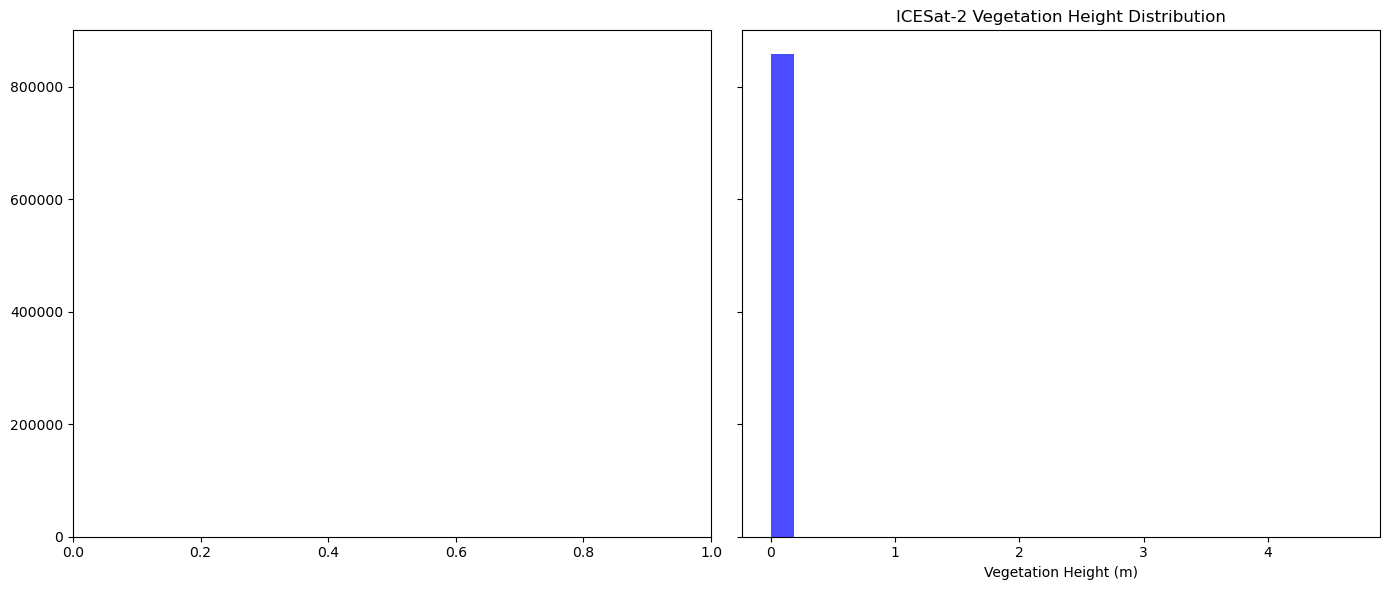

In [58]:
# Create subplots for GEDI and ICESat-2 histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# GEDI histogram
axes[0].hist(merged_gedi_gdf_l1b_final['rh_100'], bins=25, color='green', alpha=0.7)
axes[0].set_title('GEDI Vegetation Height Distribution')
axes[0].set_xlabel('Vegetation Height (m)')
axes[0].set_ylabel('Frequency')

# ICESat-2 histogram
axes[1].hist(icesat2_gdf_atl03_veg_ground_final['vegetation_height'], bins=25, color='blue', alpha=0.7)
# axes[1].hist(vegetation_heights['vegetation_height'], bins=25, color='blue', alpha=0.7)
axes[1].set_title('ICESat-2 Vegetation Height Distribution')
axes[1].set_xlabel('Vegetation Height (m)')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

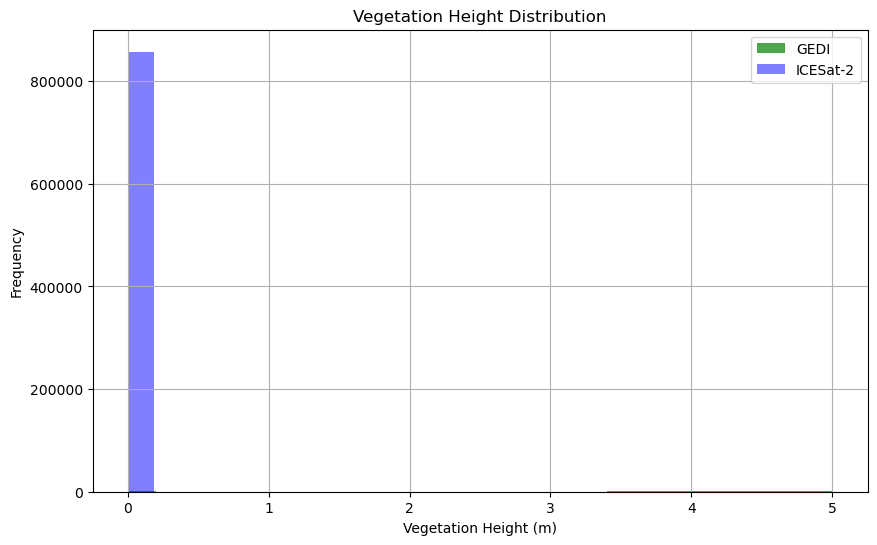

In [60]:
# Histogram of vegetation height for both GEDI and ICESat-2
plt.figure(figsize=(10, 6))

# GEDI histogram
merged_gedi_gdf_l1b_final['rh_100'].hist(bins=25, color='green', alpha=0.7, label='GEDI')

# ICESat-2 histogram
icesat2_gdf_atl03_veg_ground_final['vegetation_height'].hist(bins=25, color='blue', alpha=0.5, label='ICESat-2')

# Add title, labels, and legend
plt.title('Vegetation Height Distribution')
plt.xlabel('Vegetation Height (m)')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

## Topographic Influence on Vegetation Height
### 1. Correlation

In [61]:
merged_gedi_gdf_l1b_final[['rh_100']].describe()

rh_100
count  7707.000000
mean      3.801906
std       1.137446
min       0.000000
25%       3.620000
50%       4.000000
75%       4.490000
max       5.000000

In [62]:
# merged_gedi_gdf_l1b_final["slope"] = gedi_gdf["slope"]
# correlation = merged_gedi_gdf_l1b_final[['rh_100', 'slope', 'geolocation_digital_elevation_model']].corr()
correlation_gedi = merged_gedi_gdf_l1b_final[['rh_100', 'GEDI01_B_slope_haversine', 'elev_lowestmode']].corr()
print(correlation_gedi)

# test_gedi = merged_gedi_gdf_l1b_final.iloc[1:, :]
# test_gedi["slope"] = np.array(gedi_slopes)
correlation_gedi = merged_gedi_gdf_l1b_final[['rh_100', 'GEDI01_B_slope_rise_run', 'elev_lowestmode']].corr()
print(correlation_gedi)

                            rh_100  GEDI01_B_slope_haversine  elev_lowestmode
rh_100                    1.000000                 -0.033257        -0.653353
GEDI01_B_slope_haversine -0.033257                  1.000000         0.109405
elev_lowestmode          -0.653353                  0.109405         1.000000
                           rh_100  GEDI01_B_slope_rise_run  elev_lowestmode
rh_100                   1.000000                 0.011467        -0.653353
GEDI01_B_slope_rise_run  0.011467                 1.000000        -0.016408
elev_lowestmode         -0.653353                -0.016408         1.000000


In [63]:
# icesat2_gdf_atl03_veg_height["slope"] = icesat2_gdf["slope"]
correlation = icesat2_gdf_atl03_veg_ground_final[['height', 'ICESat2_slope_haversine', 'vegetation_height']].corr()
print(correlation, "\n")


# test_icesat2 = icesat2_gdf_atl03_veg_height.iloc[1:, :]
# test_icesat2["slope"] = np.array(icesat2_slopes)
# icesat2_gdf_atl03_veg_height["slope"] = icesat2_gdf["slope"]
correlation = icesat2_gdf_atl03_veg_ground_final[['height', 'ICESat2_slope_rise_run', 'vegetation_height']].corr()
print(correlation)

                           height  ICESat2_slope_haversine  vegetation_height
height                   1.000000                -0.037849           0.001835
ICESat2_slope_haversine -0.037849                 1.000000          -0.002857
vegetation_height        0.001835                -0.002857           1.000000 

                          height  ICESat2_slope_rise_run  vegetation_height
height                  1.000000               -0.046089           0.001835
ICESat2_slope_rise_run -0.046089                1.000000          -0.002495
vegetation_height       0.001835               -0.002495           1.000000


### 2. Graphical Inspection: Scatter Plot

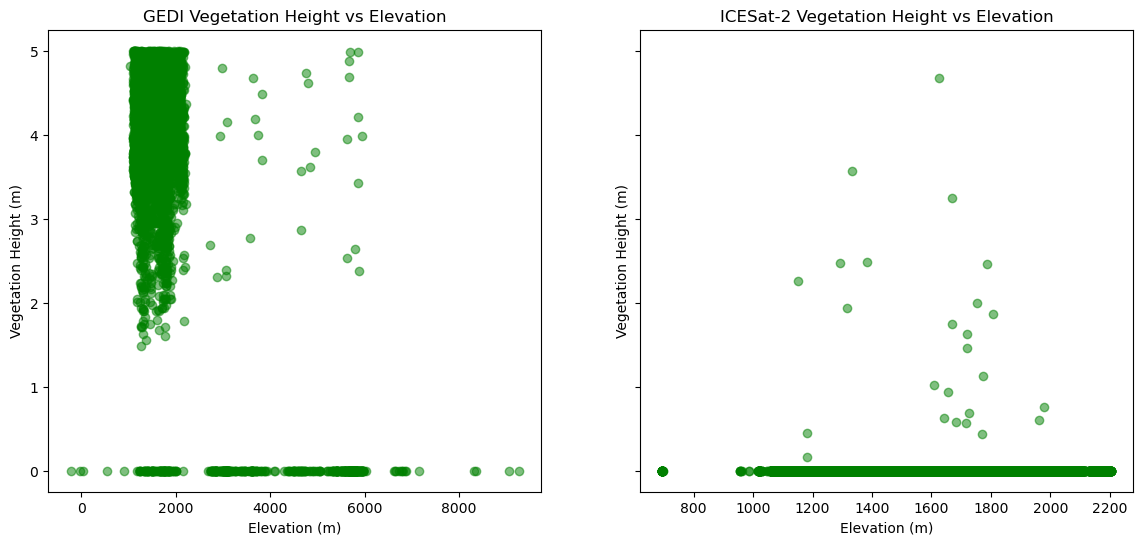

<Figure size 1000x600 with 0 Axes>

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot vegetation height vs elevation
plt.figure(figsize=(10, 6))
axes[0].scatter(merged_gedi_gdf_l1b_final['elev_lowestmode'], merged_gedi_gdf_l1b_final['rh_100'], alpha=0.5, c='green')
axes[0].set_title('GEDI Vegetation Height vs Elevation')
axes[0].set_xlabel('Elevation (m)')
axes[0].set_ylabel('Vegetation Height (m)')

axes[1].scatter(icesat2_gdf_atl03_veg_ground_final['height'], icesat2_gdf_atl03_veg_ground_final['vegetation_height'], alpha=0.5, c='green')
axes[1].set_title('ICESat-2 Vegetation Height vs Elevation')
axes[1].set_xlabel('Elevation (m)')
axes[1].set_ylabel('Vegetation Height (m)')

plt.tight_layout()
plt.show()

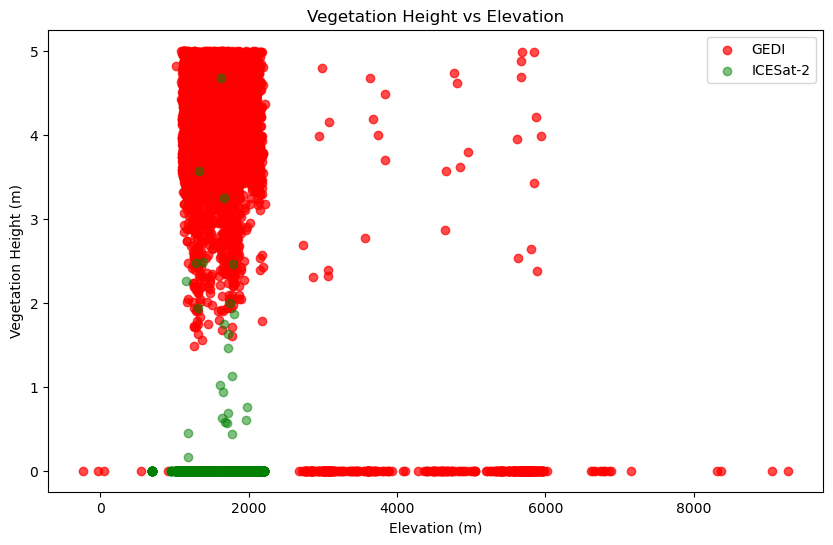

In [65]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_gedi_gdf_l1b_final['elev_lowestmode'], merged_gedi_gdf_l1b_final['rh_100'], alpha=0.7, c="red", label="GEDI")
plt.scatter(icesat2_gdf_atl03_veg_ground_final['height'], icesat2_gdf_atl03_veg_ground_final['vegetation_height'], alpha=0.5, c="green", label="ICESat-2")
plt.title('Vegetation Height vs Elevation')
plt.xlabel('Elevation (m)')
plt.ylabel('Vegetation Height (m)')
plt.legend()
plt.show()

### 3. Landscape Fragmentation

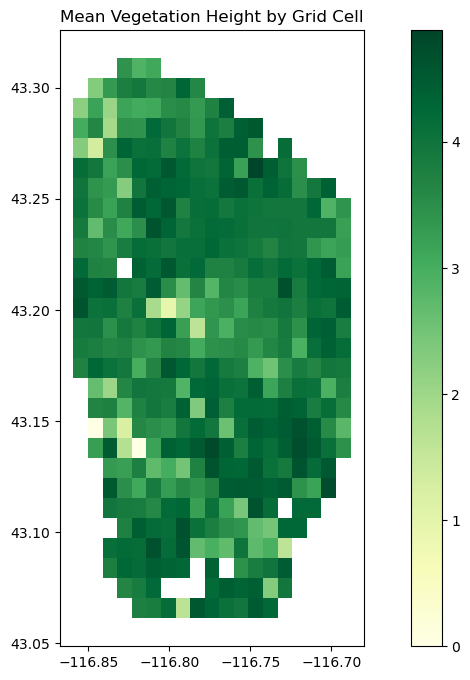

In [66]:
from shapely.geometry import box

# Define grid parameters
grid_size = 0.009  # Grid cell size in degrees
minx_gedi, miny_gedi, maxx_gedi, maxy_gedi = merged_gedi_gdf_l1b_final.total_bounds
x_cells_gedi = np.arange(minx_gedi, maxx_gedi, grid_size)
y_cells_gedi = np.arange(miny_gedi, maxy_gedi, grid_size)

# Create grid cells
grid_cells_gedi = [box(x, y, x + grid_size, y + grid_size) for x in x_cells_gedi for y in y_cells_gedi]
grid_gdf_gedi = gpd.GeoDataFrame({'geometry': grid_cells_gedi}, crs=merged_gedi_gdf_l1b_final.crs)

# Spatial join: Assign vegetation heights to grid cells
joined = gpd.sjoin(merged_gedi_gdf_l1b_final, grid_gdf_gedi, predicate='within')

# Calculate statistics for each grid cell
grid_stats_gedi = joined.groupby('index_right')['rh_100'].agg(['mean', 'std', 'min', 'max']).reset_index()

# Merge stats back to grid GeoDataFrame
grid_gdf_gedi = grid_gdf_gedi.merge(grid_stats_gedi, left_index=True, right_on='index_right')

# Plot the mean vegetation height per grid cell
grid_gdf_gedi.plot(column='mean', cmap='YlGn', legend=True, figsize=(12, 8))
# grid_gdf_gedi.plot(column='std', cmap='YlGn', legend=True, figsize=(12, 8))
plt.title('Mean Vegetation Height by Grid Cell')
plt.show()


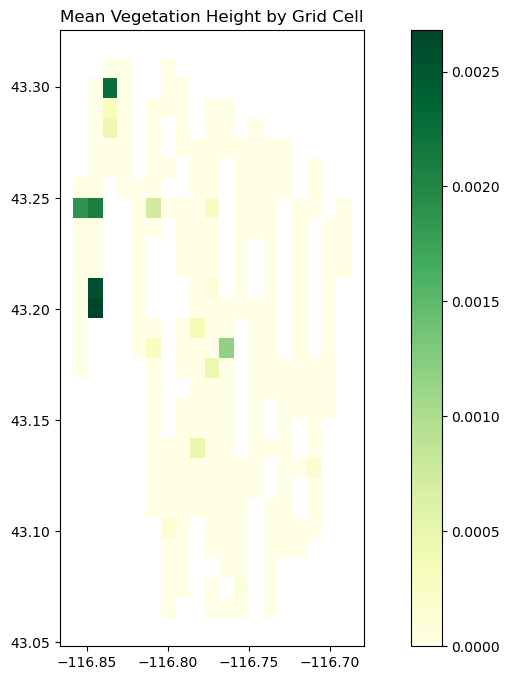

In [67]:
# Define grid parameters
grid_size = 0.009  # Grid cell size in degrees
minx_icesat2, miny_icesat2, maxx_icesat2, maxy_icesat2 = icesat2_gdf_atl03_veg_ground_final.total_bounds
x_cells_icesat2 = np.arange(minx_icesat2, maxx_icesat2, grid_size)
y_cells_icesat2 = np.arange(miny_icesat2, maxy_icesat2, grid_size)

# Create grid cells
grid_cells_icesat2 = [box(x, y, x + grid_size, y + grid_size) for x in x_cells_icesat2 for y in y_cells_icesat2]
grid_gdf_icesat2 = gpd.GeoDataFrame({'geometry': grid_cells_icesat2}, crs=merged_gedi_gdf_l1b_final.crs)

# Spatial join: Assign vegetation heights to grid cells
joined = gpd.sjoin(icesat2_gdf_atl03_veg_ground_final, grid_gdf_icesat2, predicate='within')

# Calculate statistics for each grid cell
grid_stats_icesat2 = joined.groupby('index_right')['vegetation_height'].agg(['mean', 'std', 'min', 'max']).reset_index()

# Merge stats back to grid GeoDataFrame
grid_gdf_icesat2 = grid_gdf_icesat2.merge(grid_stats_icesat2, left_index=True, right_on='index_right')

# Plot the mean vegetation height per grid cell
grid_gdf_icesat2.plot(column='mean', cmap='YlGn', legend=True, figsize=(12, 8))
# grid_gdf_gedi.plot(column='std', cmap='YlGn', legend=True, figsize=(12, 8))
plt.title('Mean Vegetation Height by Grid Cell')
plt.show()


In [68]:
import matplotlib.pyplot as plt
from shapely.geometry import box
import geopandas as gpd
import numpy as np

# Define grid parameters
grid_size = 0.009  # Grid cell size in degrees

# --- GEDI Grid ---
minx_gedi, miny_gedi, maxx_gedi, maxy_gedi = merged_gedi_gdf_l1b_final.total_bounds
x_cells_gedi = np.arange(minx_gedi, maxx_gedi, grid_size)
y_cells_gedi = np.arange(miny_gedi, maxy_gedi, grid_size)

# Create grid cells
grid_cells_gedi = [box(x, y, x + grid_size, y + grid_size) for x in x_cells_gedi for y in y_cells_gedi]
grid_gdf_gedi = gpd.GeoDataFrame({'geometry': grid_cells_gedi}, crs=merged_gedi_gdf_l1b_final.crs)

# Spatial join: Assign vegetation heights to grid cells
joined = gpd.sjoin(merged_gedi_gdf_l1b_final, grid_gdf_gedi, predicate='within')

# Calculate statistics for each grid cell
grid_stats_gedi = joined.groupby('index_right')['rh_100'].agg(['mean', 'std', 'min', 'max']).reset_index()

# Merge stats back to grid GeoDataFrame
grid_gdf_gedi = grid_gdf_gedi.merge(grid_stats_gedi, left_index=True, right_on='index_right')

# --- ICESat-2 Grid ---
minx_icesat2, miny_icesat2, maxx_icesat2, maxy_icesat2 = icesat2_gdf_atl03_veg_ground_final.total_bounds
x_cells_icesat2 = np.arange(minx_icesat2, maxx_icesat2, grid_size)
y_cells_icesat2 = np.arange(miny_icesat2, maxy_icesat2, grid_size)

# Create grid cells
grid_cells_icesat2 = [box(x, y, x + grid_size, y + grid_size) for x in x_cells_icesat2 for y in y_cells_icesat2]
grid_gdf_icesat2 = gpd.GeoDataFrame({'geometry': grid_cells_icesat2}, crs=merged_gedi_gdf_l1b_final.crs)

# Spatial join: Assign vegetation heights to grid cells
joined = gpd.sjoin(icesat2_gdf_atl03_veg_ground_final, grid_gdf_icesat2, predicate='within')

# Calculate statistics for each grid cell
grid_stats_icesat2 = joined.groupby('index_right')['vegetation_height'].agg(['mean', 'std', 'min', 'max']).reset_index()

# Merge stats back to grid GeoDataFrame
grid_gdf_icesat2 = grid_gdf_icesat2.merge(grid_stats_icesat2, left_index=True, right_on='index_right')



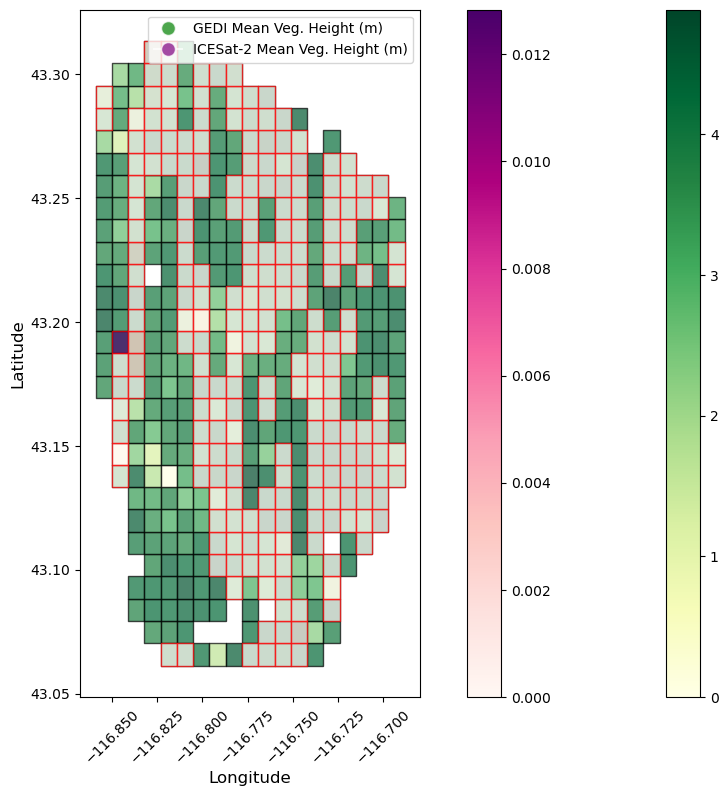

In [69]:
import matplotlib.pyplot as plt
from shapely.geometry import box
import geopandas as gpd
import numpy as np

# Define grid parameters
grid_size = 0.009  # Grid cell size in degrees

# --- Create Grid Based on GEDI Coordinates ---
minx_gedi, miny_gedi, maxx_gedi, maxy_gedi = merged_gedi_gdf_l1b_final.total_bounds
x_cells = np.arange(minx_gedi, maxx_gedi, grid_size)
y_cells = np.arange(miny_gedi, maxy_gedi, grid_size)

# Create grid cells
grid_cells = [box(x, y, x + grid_size, y + grid_size) for x in x_cells for y in y_cells]
grid_gdf = gpd.GeoDataFrame({'geometry': grid_cells}, crs=merged_gedi_gdf_l1b_final.crs)

# --- Assign GEDI Vegetation Heights to Grid Cells ---
joined_gedi = gpd.sjoin(merged_gedi_gdf_l1b_final, grid_gdf, predicate='within')
gedi_stats = joined_gedi.groupby('index_right')['rh_100'].mean().reset_index()
gedi_stats.rename(columns={'rh_100': 'gedi_mean_height'}, inplace=True)

# --- Assign ICESat-2 Vegetation Heights to the Same Grid Cells ---
joined_icesat2 = gpd.sjoin(icesat2_gdf_atl03_veg_ground_final, grid_gdf, predicate='within')
icesat2_stats = joined_icesat2.groupby('index_right')['vegetation_height'].mean().reset_index()
icesat2_stats.rename(columns={'vegetation_height': 'icesat2_mean_height'}, inplace=True)

# --- Merge GEDI and ICESat-2 Statistics ---
grid_stats = gpd.GeoDataFrame(grid_gdf)
grid_stats = grid_stats.merge(gedi_stats, how='left', left_index=True, right_on='index_right')
grid_stats = grid_stats.merge(icesat2_stats, how='left', left_index=True, right_on='index_right')

# --- Plot Results ---
fig, ax = plt.subplots(figsize=(12, 8))

# Plot GEDI mean heights
grid_stats.plot(ax=ax, column='gedi_mean_height', cmap='YlGn', legend=True, alpha=0.7, edgecolor='black')
gedi_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', alpha=0.7, markersize=10, label='GEDI Mean Veg. Height (m)')

# Plot ICESat-2 mean heights
grid_stats.plot(ax=ax, column='icesat2_mean_height', cmap='RdPu', legend=True, alpha=0.7, edgecolor='red')
icesat2_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', alpha=0.7, markersize=10, label='ICESat-2 Mean Veg. Height (m)')

# Customize the plot
# plt.title('Mean Vegetation Height', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Add a custom legend
ax.legend(handles=[gedi_patch, icesat2_patch], loc='upper right', fontsize=10)

plt.show()


In [70]:
# joined_gedi.columns
# joined_icesat2.columns
gedi_stats1 = joined_gedi.groupby('index_right')['elev_lowestmode'].mean().reset_index()
gedi_stats2 = joined_gedi.groupby('index_right')['rh_100'].mean().reset_index()


# Merge the two datasets on the "index_right" column
merged_gedi_stats = gedi_stats1.merge(gedi_stats2, on="index_right")

# Compute the correlation
correlation_gedi = merged_gedi_stats["elev_lowestmode"].corr(merged_gedi_stats["rh_100"])
print(f"Correlation between elev_lowestmode and rh_100: {correlation_gedi}")


Correlation between elev_lowestmode and rh_100: -0.5939321450545825


### 4. Mean elevation across grid

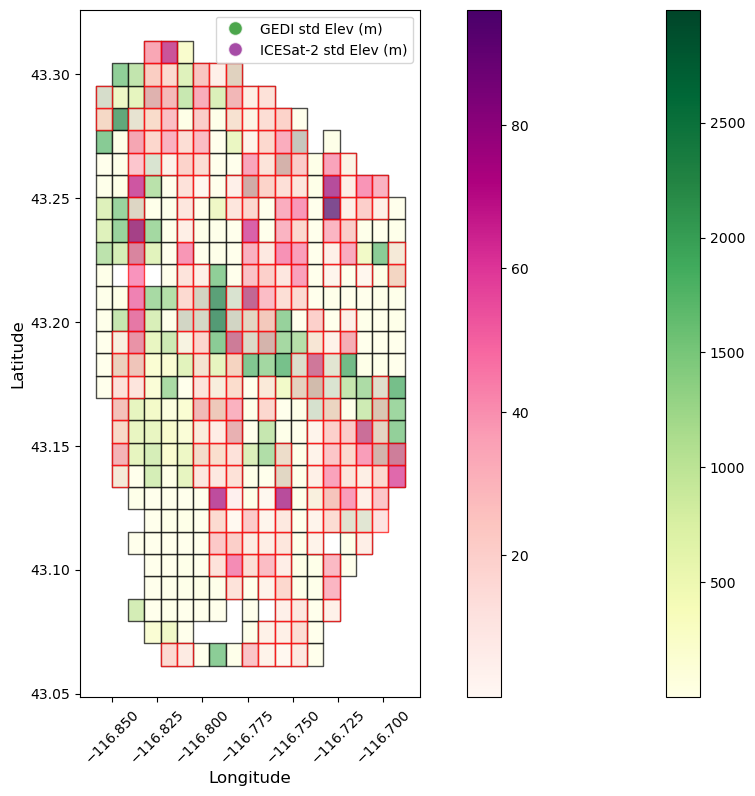

In [71]:
import matplotlib.pyplot as plt
from shapely.geometry import box
import geopandas as gpd
import numpy as np

# Define grid parameters
grid_size = 0.009  # Grid cell size in degrees

# --- Create Grid Based on GEDI Coordinates ---
minx_gedi, miny_gedi, maxx_gedi, maxy_gedi = merged_gedi_gdf_l1b_final.total_bounds
x_cells = np.arange(minx_gedi, maxx_gedi, grid_size)
y_cells = np.arange(miny_gedi, maxy_gedi, grid_size)

# Create grid cells
grid_cells = [box(x, y, x + grid_size, y + grid_size) for x in x_cells for y in y_cells]
grid_gdf = gpd.GeoDataFrame({'geometry': grid_cells}, crs=merged_gedi_gdf_l1b_final.crs)

# --- Assign GEDI Vegetation Heights to Grid Cells ---
joined_gedi = gpd.sjoin(merged_gedi_gdf_l1b_final, grid_gdf, predicate='within')
gedi_stats = joined_gedi.groupby('index_right')['elev_lowestmode'].std().reset_index()
gedi_stats.rename(columns={'elev_lowestmode': 'gedi_mean_elev'}, inplace=True)

# --- Assign ICESat-2 Vegetation Heights to the Same Grid Cells ---
joined_icesat2 = gpd.sjoin(icesat2_gdf_atl03_veg_ground_final, grid_gdf, predicate='within')
icesat2_stats = joined_icesat2.groupby('index_right')['height'].std().reset_index()
icesat2_stats.rename(columns={'height': 'icesat2_mean_elev'}, inplace=True)

# --- Merge GEDI and ICESat-2 Statistics ---
grid_stats = gpd.GeoDataFrame(grid_gdf)
grid_stats = grid_stats.merge(gedi_stats, how='left', left_index=True, right_on='index_right')
grid_stats = grid_stats.merge(icesat2_stats, how='left', left_index=True, right_on='index_right')

# --- Plot Results ---
fig, ax = plt.subplots(figsize=(12, 8))

# Plot GEDI mean heights
grid_stats.plot(ax=ax, column='gedi_mean_elev', cmap='YlGn', legend=True, alpha=0.7, edgecolor='black')
gedi_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', alpha=0.7, markersize=10, label='GEDI std Elev (m)')

# Plot ICESat-2 mean heights
grid_stats.plot(ax=ax, column='icesat2_mean_elev', cmap='RdPu', legend=True, alpha=0.7, edgecolor='red')
icesat2_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', alpha=0.7, markersize=10, label='ICESat-2 std Elev (m)')

# Customize the plot
# plt.title('Mean Vegetation Height', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Add a custom legend
ax.legend(handles=[gedi_patch, icesat2_patch], loc='upper right', fontsize=10)

plt.show()


In [72]:
icesat2_stats1 = joined_icesat2.groupby('index_right')['height'].mean().reset_index()
icesat2_stats2 = joined_icesat2.groupby('index_right')['vegetation_height'].mean().reset_index()


# Merge the two datasets on the "index_right" column
merged_icesat2_stats = icesat2_stats1.merge(icesat2_stats2, on="index_right")

# Compute the correlation
correlation_icesat2 = merged_icesat2_stats["height"].corr(merged_icesat2_stats["vegetation_height"])
print(f"Correlation between vegetation height and rh_100: {correlation_icesat2}")

Correlation between vegetation height and rh_100: 0.08303128182439082


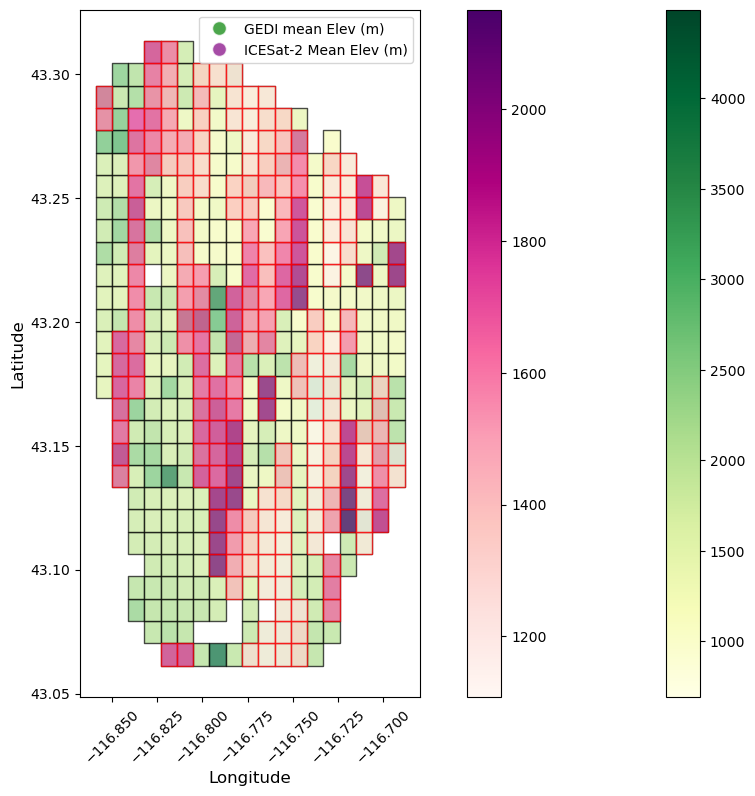

In [73]:
import matplotlib.pyplot as plt
from shapely.geometry import box
import geopandas as gpd
import numpy as np

# Define grid parameters
grid_size = 0.009  # Grid cell size in degrees

# --- Create Grid Based on GEDI Coordinates ---
minx_gedi, miny_gedi, maxx_gedi, maxy_gedi = merged_gedi_gdf_l1b_final.total_bounds
x_cells = np.arange(minx_gedi, maxx_gedi, grid_size)
y_cells = np.arange(miny_gedi, maxy_gedi, grid_size)

# Create grid cells
grid_cells = [box(x, y, x + grid_size, y + grid_size) for x in x_cells for y in y_cells]
grid_gdf = gpd.GeoDataFrame({'geometry': grid_cells}, crs=merged_gedi_gdf_l1b_final.crs)

# --- Assign GEDI Vegetation Heights to Grid Cells ---
joined_gedi = gpd.sjoin(merged_gedi_gdf_l1b_final, grid_gdf, predicate='within')
gedi_stats = joined_gedi.groupby('index_right')['elev_lowestmode'].mean().reset_index()
gedi_stats.rename(columns={'elev_lowestmode': 'gedi_mean_elev'}, inplace=True)

# --- Assign ICESat-2 Vegetation Heights to the Same Grid Cells ---
joined_icesat2 = gpd.sjoin(icesat2_gdf_atl03_veg_ground_final, grid_gdf, predicate='within')
icesat2_stats = joined_icesat2.groupby('index_right')['height'].mean().reset_index()
icesat2_stats.rename(columns={'height': 'icesat2_mean_elev'}, inplace=True)

# --- Merge GEDI and ICESat-2 Statistics ---
grid_stats = gpd.GeoDataFrame(grid_gdf)
grid_stats = grid_stats.merge(gedi_stats, how='left', left_index=True, right_on='index_right')
grid_stats = grid_stats.merge(icesat2_stats, how='left', left_index=True, right_on='index_right')

# --- Plot Results ---
fig, ax = plt.subplots(figsize=(12, 8))

# Plot GEDI mean heights
grid_stats.plot(ax=ax, column='gedi_mean_elev', cmap='YlGn', legend=True, alpha=0.7, edgecolor='black')
gedi_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', alpha=0.7, markersize=10, label='GEDI mean Elev (m)')

# Plot ICESat-2 mean heights
grid_stats.plot(ax=ax, column='icesat2_mean_elev', cmap='RdPu', legend=True, alpha=0.7, edgecolor='red')
icesat2_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', alpha=0.7, markersize=10, label='ICESat-2 Mean Elev (m)')

# Customize the plot
# plt.title('Mean Vegetation Height', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Add a custom legend
ax.legend(handles=[gedi_patch, icesat2_patch], loc='upper right', fontsize=10)

plt.show()


In [74]:
# joined_gedi.columns
# joined_icesat2.columns
icesat2_stats1 = joined_icesat2.groupby('index_right')['height'].mean().reset_index()
icesat2_stats2 = joined_icesat2.groupby('index_right')['vegetation_height'].mean().reset_index()


# Merge the two datasets on the "index_right" column
merged_icesat2_stats = icesat2_stats1.merge(icesat2_stats2, on="index_right")

# Compute the correlation
correlation_icesat2 = merged_icesat2_stats["height"].corr(merged_icesat2_stats["vegetation_height"])
print(f"Correlation between vegetation height and rh_100: {correlation_icesat2}")


Correlation between vegetation height and rh_100: 0.08303128182439082


### 5. Hotspot Analysis

In [75]:
from esda.moran import Moran
from libpysal.weights import Queen

# Create spatial weights
weights_gedi = Queen.from_dataframe(merged_gedi_gdf_l1b_final, use_index=True)
weights_icesat2 = Queen.from_dataframe(icesat2_gdf_atl03_veg_ground_final, use_index=True)

# Calculate Moran's I
moran_gedi = Moran(merged_gedi_gdf_l1b_final['rh_100'], weights_gedi)
moran_icesat2 = Moran(icesat2_gdf_atl03_veg_ground_final['vegetation_height'], weights_icesat2)
print(f"Moran's I for GEDI: {moran_gedi.I}")
print(f"Moran's I for ICESat-2: {moran_icesat2.I}")


Moran's I for GEDI: 0.162055011840871
Moran's I for ICESat-2: -2.3883531460309685e-05


In [76]:
# Example allometric equation: AGB = 0.05 * (vegetation_height)^2.2
merged_gedi_gdf_l1b_final['AGB'] = 0.05 * (merged_gedi_gdf_l1b_final['rh_100'] ** 2.2)

# Estimate carbon stock (assume 50% of biomass is carbon)
merged_gedi_gdf_l1b_final['carbon_stock'] = merged_gedi_gdf_l1b_final['AGB'] * 0.5

# Summarize total carbon stock
total_carbon = merged_gedi_gdf_l1b_final['carbon_stock'].sum()
print(f"Total Carbon Stock: {total_carbon} tons")

Total Carbon Stock: 4040.4996693620215 tons


/bsuhome/tnde/miniconda3/envs/lpdaac_tutorials/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/bsuhome/tnde/miniconda3/envs/lpdaac_tutorials/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### 3D Visualization of Vegetation Height

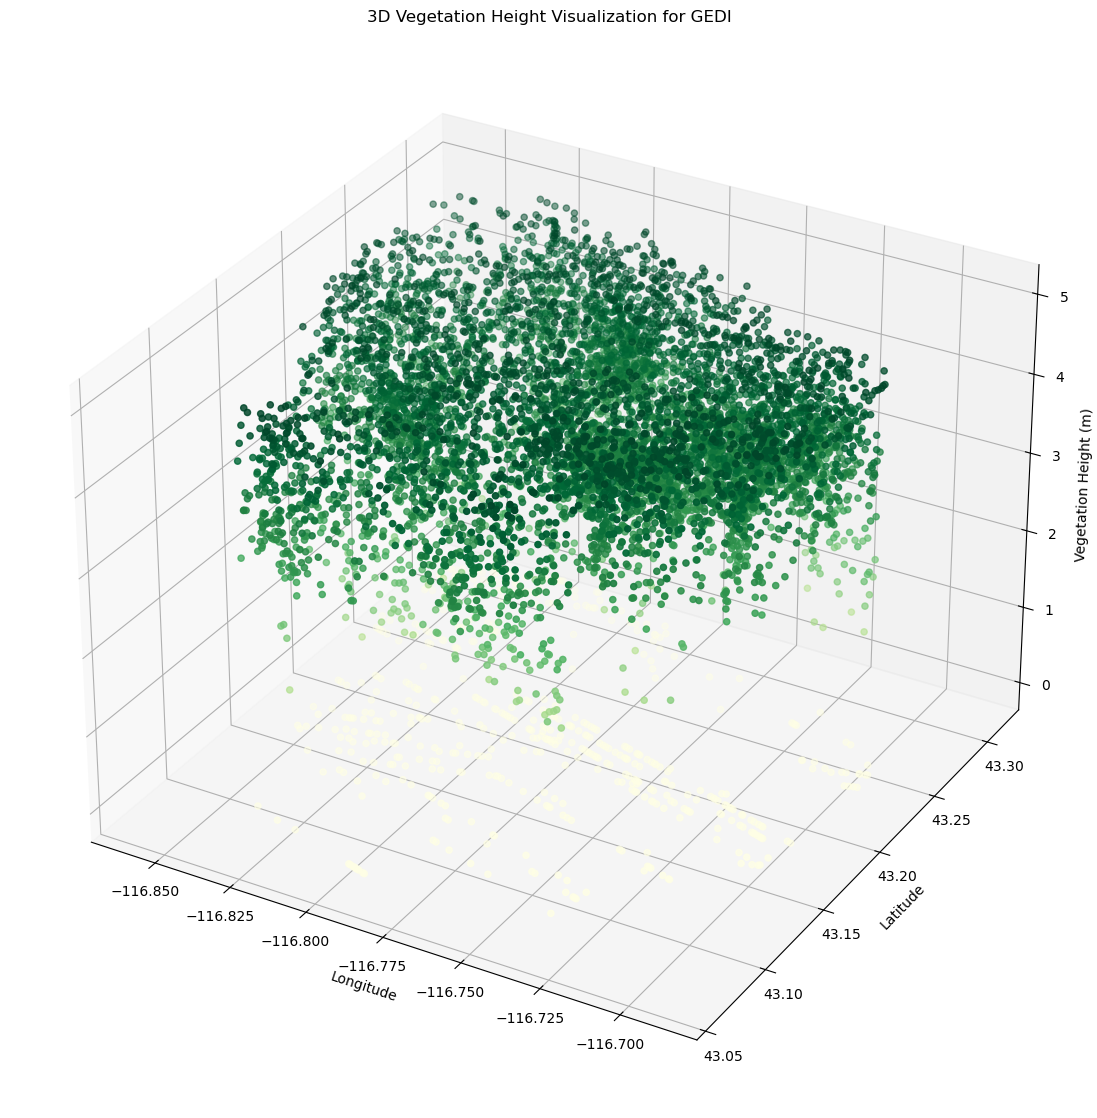

In [77]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(merged_gedi_gdf_l1b_final['geometry'].x, merged_gedi_gdf_l1b_final['geometry'].y, merged_gedi_gdf_l1b_final['rh_100'], c=merged_gedi_gdf_l1b_final['rh_100'], cmap='YlGn')
ax.set_title('3D Vegetation Height Visualization for GEDI')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Vegetation Height (m)')
plt.show()

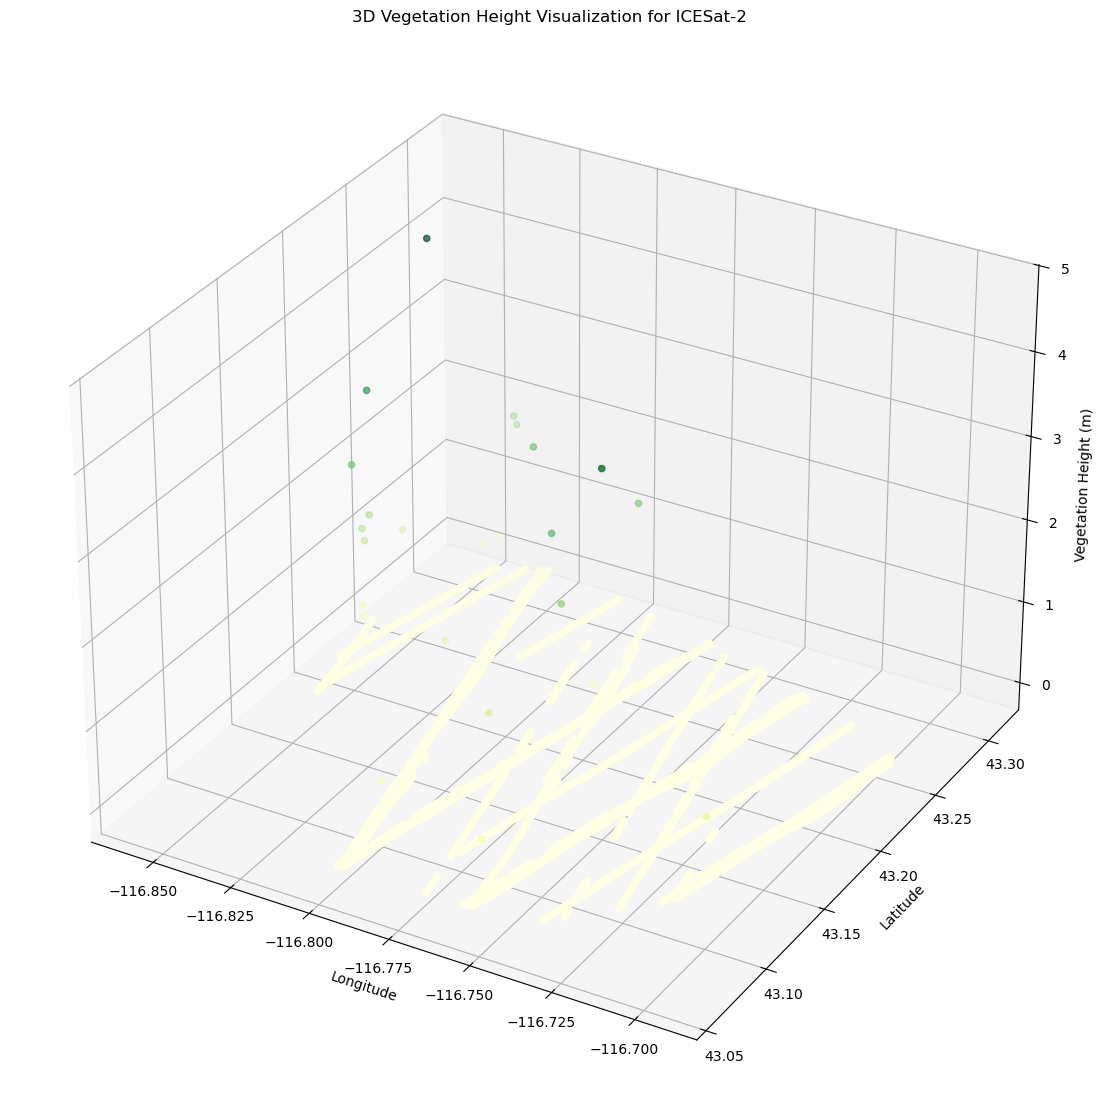

In [78]:
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(icesat2_gdf_atl03_veg_ground_final['geometry'].x, 
                     icesat2_gdf_atl03_veg_ground_final['geometry'].y, 
                     icesat2_gdf_atl03_veg_ground_final['vegetation_height'], 
                     c=icesat2_gdf_atl03_veg_ground_final['vegetation_height'], 
                     cmap='YlGn')
ax.set_title('3D Vegetation Height Visualization for ICESat-2')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Vegetation Height (m)')
plt.show()

In [82]:
# merged_gedi_gdf_l1b_final.plot(column='rh_100', cmap='YlGn', legend=True)


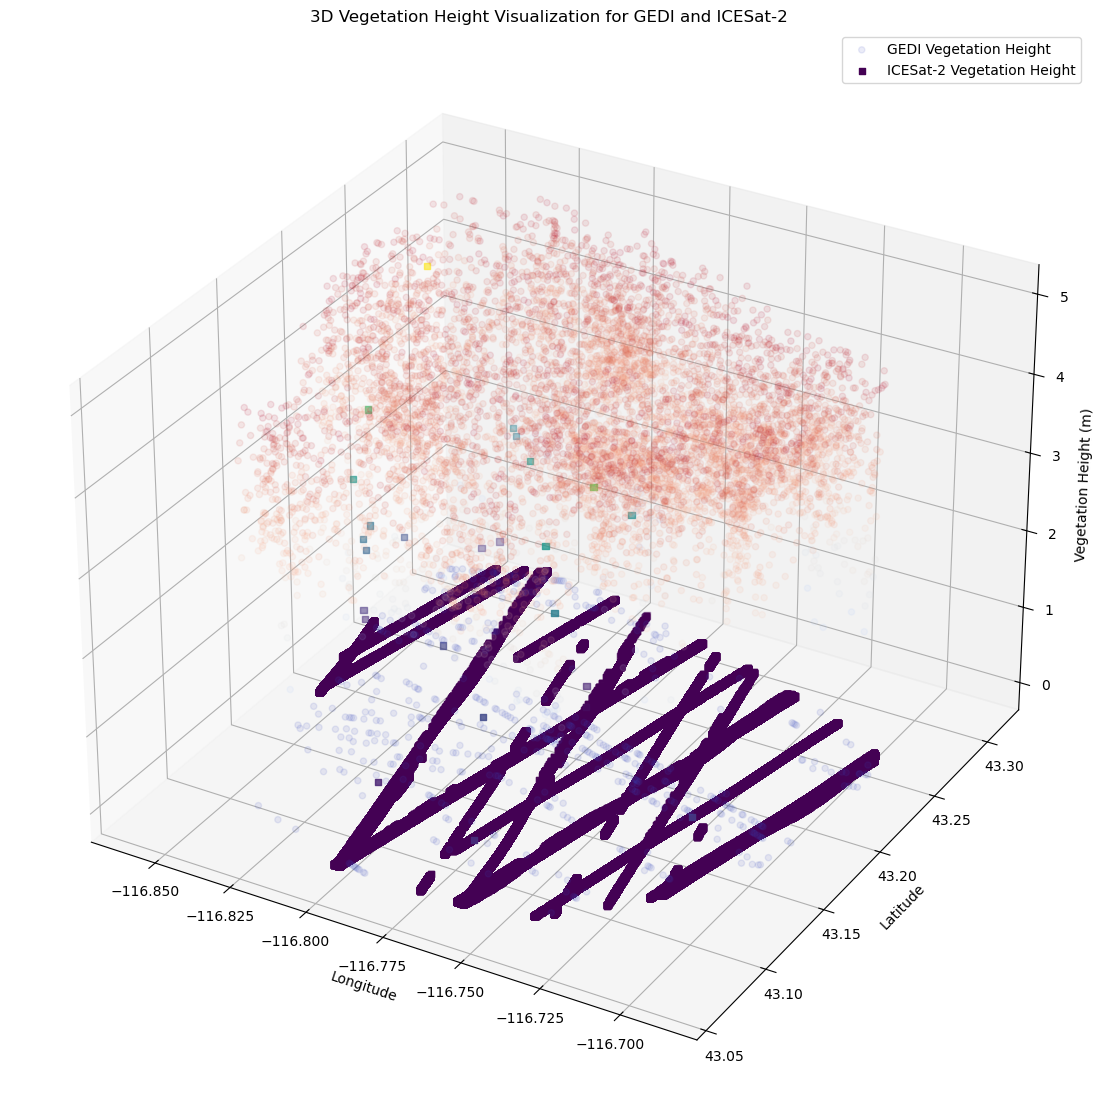

In [79]:
# %matplotlib qt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Create a single 3D plot
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')

# Plot the first dataset (GEDI)
scatter1 = ax.scatter(
    merged_gedi_gdf_l1b_final['geometry'].x, 
    merged_gedi_gdf_l1b_final['geometry'].y, 
    merged_gedi_gdf_l1b_final['rh_100'], 
    c=merged_gedi_gdf_l1b_final['rh_100'], 
    # cmap='YlOrRd',
    cmap='coolwarm', #best
    # cmap='YlGn', 
    # cmap='RdYlBu', 
    alpha=0.1,
    marker="o",
    label='GEDI Vegetation Height'
)

# Plot the second dataset (ICESat-2)
scatter2 = ax.scatter(
    icesat2_gdf_atl03_veg_ground_final['geometry'].x, 
    icesat2_gdf_atl03_veg_ground_final['geometry'].y, 
    icesat2_gdf_atl03_veg_ground_final['vegetation_height'], 
    c=icesat2_gdf_atl03_veg_ground_final['vegetation_height'], 
    cmap='viridis', #best
    # cmap='YlGn', 
    # cmap='Greens', 
    # alpha=0.05,
    marker="s",
    label='ICESat-2 Vegetation Height'
)

# Set titles and labels
ax.set_title('3D Vegetation Height Visualization for GEDI and ICESat-2')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Vegetation Height (m)')

# Add legend
ax.legend()

# Show the plot
plt.show()

In [ ]:
# Goal: Calculate vegetation structure (height) and biomass.
# Motivation: Our methodology underscores the potential of using satellite laser altimetry combined with machine learning to refine our understanding of the global carbon budget. 
# Approach: We combine satellite data on vegetation structure with ground-based measurements to train and validate advanced ML models for dryland carbon stock estimation and uncertainty analysis
# Gaps: Dryland ecosystems, which make up 40% of Earth's land surface and hold significant potential for global carbon storage, have been largely overlooked in laser altimetry research.

## The End